In [1]:
!pip install rasterio
!pip install fiona
!pip install shapely
!pip install geopandas
!pip install pycrs

     ---------------------------------------- 0.0/22.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/22.0 MB ? eta -:--:--
     ---------------------------------------- 0.1/22.0 MB 1.8 MB/s eta 0:00:13
      --------------------------------------- 0.5/22.0 MB 3.6 MB/s eta 0:00:06
     -- ------------------------------------- 1.2/22.0 MB 7.8 MB/s eta 0:00:03
     --- ------------------------------------ 2.0/22.0 MB 9.8 MB/s eta 0:00:03
     ---- ----------------------------------- 2.5/22.0 MB 10.6 MB/s eta 0:00:02
     ----- ---------------------------------- 3.1/22.0 MB 11.0 MB/s eta 0:00:02
     ----- ---------------------------------- 3.1/22.0 MB 9.5 MB/s eta 0:00:02
     ----- ---------------------------------- 3.1/22.0 MB 9.5 MB/s eta 0:00:02
     ----- ---------------------------------- 3.1/22.0 MB 7.4 MB/s eta 0:00:03
     ----- ---------------------------------- 3.1/22.0 MB 7.4 MB/s eta 0:00:03
     ----- ---------------------------------- 3.1/22.0 MB 7.4 MB

In [3]:
from matplotlib import pyplot as plt
from matplotlib import colors, cm
from matplotlib import ticker
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
import re #used for making multiple string splits
import json
import os

from matplotlib.colors import ListedColormap
import numpy as np

In [4]:
#load input file
# fp = r'cgls_landcover_2015_classification.tiff'
fp = r'cci_landcover_2010_v2.0.7cds.tif'
# fp = "dataPreprocessing/precipitationData/my_test_data.tif"
# fp = "dataPreprocessing/temperatureData/tiffTemperatureData/LST2012_avg.tiff"
data = rasterio.open(fp)



In [5]:
def show_land_cover(img):
    #labels for plotting
    labels = {0: {'color': '#282828', 'flag': 'unknown'},
              20: {'color': '#FFBB22', 'flag': 'shrubs'},
              30: {'color': '#FFFF4C', 'flag': 'herbaceous_vegetation'},
              40: {'color': '#F096FF', 'flag': 'cultivated_and_managed_vegetation_or_agriculture'},
              50: {'color': '#FA0000', 'flag': 'urban_or_built_up'},
              60: {'color': '#B4B4B4', 'flag': 'bare_or_sparse_vegetation'},
              70: {'color': '#F0F0F0', 'flag': 'snow_and_ice'},
              80: {'color': '#0032C8', 'flag': 'permanent_water_bodies'},
              90: {'color': '#0096A0', 'flag': 'herbaceous_wetland'},
              100: {'color': '#FAE6A0', 'flag': 'moss_and_lichen'},
              111: {'color': '#58481F', 'flag': 'closed_forest_evergreen_needle_leaf'},
              112: {'color': '#009900', 'flag': 'closed_forest_evergreen_broad_leaf'},
              113: {'color': '#70663E', 'flag': 'closed_forest_deciduous_needle_leaf'},
              114: {'color': '#00CC00', 'flag': 'closed_forest_deciduous_broad_leaf'},
              115: {'color': '#4E751F', 'flag': 'closed_forest_mixed'},
              116: {'color': '#007800', 'flag': 'closed_forest_not_matching_any_of_the_other_definitions'},
              121: {'color': '#666000', 'flag': 'open_forest_evergreen_needle_leaf'},
              122: {'color': '#8DB400', 'flag': 'open_forest_evergreen_broad_leaf'},
              123: {'color': '#8D7400', 'flag': 'open_forest_deciduous_needle_leaf'},
              124: {'color': '#A0DC00', 'flag': 'open_forest_deciduous_broad_leaf'},
              125: {'color': '#929900', 'flag': 'open_forest_mixed'},
              126: {'color': '#648C00', 'flag': 'open_forest_not_matching_any_of_the_other_definitions'},
              200: {'color': '#000080', 'flag': 'oceans_seas'}}
    #colors1 = [label['color'] for label in labels.values()]
    cmap = ListedColormap([label['color'] for label in labels.values()])
    norm = colors.BoundaryNorm(list(labels.keys())+[201], cmap.N+1, extend='max')
    ticks = list(np.mean((list(list(labels.keys())+[201])[i+1], val)) for i, val in enumerate(list(labels.keys())))
    cblabels=[label['flag'] for label in labels.values()]
    
    #file setup
    img_name, _ = img.split("_")
    img_name = img_name + ".tiff"
    # print(img_name)
    
    data = None
    with rasterio.open("landcover/"+img_name) as src:
        data = src.read()
        src.close() # close the rasterio dataset
    
#     data_array = np.array(data)
#     print(np.amin(data_array), np.amax(data_array))
# #     print(np.around(data_array, 1))
#     data_array = data_array[0,:,:]
#     arr = data_array
# #     arr = data_array * 0.02 - 273.15 #convert to celcius
#     print(np.around(arr, 1))
#     plt.imshow(arr)
#     plt.show()
        
#     src = rasterio.open("landcover/"+img_name)
#     data = src.read()
    
    fig, ax = plt.subplots()

    cb = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=200.5), cmap=cmap), ax=ax)
    tick_locator = ticker.FixedLocator(locs=[(i*(200/23)+5) for i in range(len(ticks))])
    cb.locator = tick_locator
    cb.update_ticks()
    cb.set_ticklabels(cblabels[::-1])

    show(data, ax=ax, cmap=cmap, norm=norm) #transform=src.transform
    
    src.close()

In [6]:
#inspiration from https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html
def generate_land_cover_image(satellite_image_name, input_file, view=0.01):
    out_name, coordinates = satellite_image_name.split("_")
    out_name = out_name + ".tiff"
    lat, lon = re.split(", |.png|,", coordinates)[:2]
    lat = float(lat)
    lon = float(lon)
    
    #finding the bounding box of the center coordinate
    up_rightX, up_rightY = round(lat-view,4), round(lon+view,4)
    down_leftX, down_leftY = round(lat+view,4), round(lon-view,4)
    bbox = box(up_rightX,up_rightY,down_leftX,down_leftY)
    # print("bbox", bbox)
    
    #Insert the BB to a GeoDataFrame and reproject it into the coordinate system of the input image
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
    geo = geo.to_crs(crs=data.crs.data)
    
    #Now we can receive the coordinates in the format that rasterio needs. 
    coords = [json.loads(geo.to_json())['features'][0]['geometry']]
    
    #Clips the data with the defined polygon
    out_img, out_transform = mask(input_file, shapes=coords, all_touched=True, crop=True)
    
    #Updating the metadata
    out_meta = data.meta.copy()
    # print(out_meta)
    epsg_code = int(data.crs.data['init'][5:])
    out_meta.update({"driver": "GTiff",
                  "height": out_img.shape[1],
                  "width": out_img.shape[2],
                  "transform": out_transform,
                  "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()
                   })
    
    #Writing the clipped image
    filepath = "./landcover/"+out_name
    if os.path.exists(filepath):
        os.remove(filepath) # delete the file 
    with rasterio.open(filepath, "w", **out_meta) as dest:
        dest.write(out_img)
        dest.close() # close the rasterio dataset
        

Manual testing

C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3098715832.py:25: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=file, input_file = data) #6_28.7472, -16.504.png
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


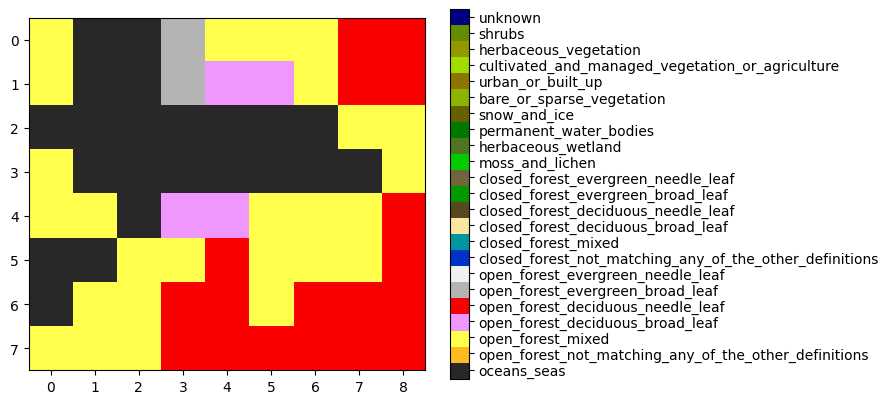

In [7]:
# file = "1_27.3348, -16.9727.png" 
# file = "2_27.3684, -17.479.png" 
# file = "100_27.2562, -16.7782.png"
file = "200_8.8124, 3.7315.png"  #Very good test by manual inspection, clearly on Malabo
# file = "210_31.379, 1.8387.png" # An ok test by manual inspection, we can see it is a bit northwest of lake victoria.


# print(np.amin(data), np.amax(data))


# generate_land_cover_image(satellite_image_name=file, input_file = data, view=2000) #6_28.7472, -16.504.png
# show_land_cover(file)
# generate_land_cover_image(satellite_image_name=file, input_file = data, view=10) #6_28.7472, -16.504.png
# show_land_cover(file)
# generate_land_cover_image(satellite_image_name=file, input_file = data, view=5) #6_28.7472, -16.504.png
# show_land_cover(file)
# generate_land_cover_image(satellite_image_name=file, input_file = data, view=2) #6_28.7472, -16.504.png
# show_land_cover(file)
# generate_land_cover_image(satellite_image_name=file, input_file = data, view=1) #6_28.7472, -16.504.png
# show_land_cover(file)
# generate_land_cover_image(satellite_image_name=file, input_file = data, view=0.5) #6_28.7472, -16.504.png
# show_land_cover(file)
# generate_land_cover_image(satellite_image_name=file, input_file = data, view=0.1) #6_28.7472, -16.504.png
# show_land_cover(file)
generate_land_cover_image(satellite_image_name=file, input_file = data) #6_28.7472, -16.504.png
show_land_cover(file)

In [8]:
import csv
import os

# print(data)

long_lat_year_path = "dataPreprocessing/malariaData/long_lat_year_with_confidential_from2010to18_size10orGreater.csv"
dataset_list = os.listdir('dataset')
fp_first = r'cci_landcovers/cci_landcover_'
fp_last = '.tif'

# Go through long_lat_year file instead of directory with images
with open(long_lat_year_path, encoding="utf8") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        id = row[0]

        if int(id) < 6663:
            continue
        print(row)
        long = row[1]
        lat = row[2]
        year = row[3]
        image_name = id+'_'+long + ", " + lat + ".png"
        fp = fp_first + year + fp_last
        data = rasterio.open(fp)
        generate_land_cover_image(satellite_image_name=image_name, input_file = data)


# dataset_list = os.listdir('dataset')
# for image in dataset_list:
#     if image == '.DS_Store':
#         continue
#     generate_land_cover_image(satellite_image_name=image, input_file = data)

['6663', '-5.64777', '11.16393', '2015', '0.38235294117647056']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['6664', '-6.259125', '11.525399', '2015', '0.4166666666666667']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['6665', '-5.936284', '11.606734', '2015', '0.5185185185185185']
['6666', '-5.551831', '11.935178', '2015', '0.62']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6667', '-6.53903', '11.4858', '2015', '0.47368421052631576']
['6668', '-5.658041', '11.330625', '2015', '0.30303030303030304']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6669', '-5.688306', '11.316045', '2015', '0.23404255319148937']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['6670', '-5.653875', '11.300723', '2015', '0.39215686274509803']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['6671', '-7.662663', '11.745168', '2015', '0.3333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['6672', '-7.420269', '11.857015', '2015', '0.75']
['6673', '-7.611353', '11.894032', '2015', '0.6666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6674', '-6.693509', '11.625117', '2015', '0.5357142857142857']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['6675', '-6.725416', '11.663912', '2015', '0.6666666666666666']
['6676', '-7.479543', '11.4119', '2015', '0.26666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6677', '-5.771669', '10.541938', '2015', '0.1590909090909091']
['6678', '-5.902589', '10.781087', '2015', '0.25925925925925924']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6679', '-6.944003', '11.158386', '2015', '0.3023255813953488']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['6680', '-6.8139', '10.545529', '2015', '0.40816326530612246']
['6681', '-6.684301', '11.098478', '2015', '0.18604651162790697']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6682', '-5.372111', '12.466847', '2015', '0.5185185185185185']
['6683', '-5.163697', '12.588174', '2015', '0.20454545454545456']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6684', '-5.404969', '11.886228', '2015', '0.35294117647058826']
['6685', '-5.609481', '12.622664', '2015', '0.10416666666666667']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6686', '-5.494851', '12.372469', '2015', '0.21739130434782608']
['6687', '-8.272929', '11.229986', '2015', '0.18181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6688', '-8.203969', '11.5185', '2015', '0.9090909090909091']
['6689', '-4.686277', '12.287683', '2015', '0.575']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6690', '-4.568124', '12.7006', '2015', '0.8333333333333334']
['6691', '-4.979681', '12.085925', '2015', '0.6486486486486487']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6692', '-6.142449', '13.528081', '2015', '0.42857142857142855']
['6693', '-6.466104', '13.294804', '2015', '0.5135135135135135']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6694', '-5.866272', '13.67471', '2015', '0.16279069767441862']
['6695', '-5.938846', '13.607162', '2015', '0.26666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6696', '-6.72729', '13.57081', '2015', '0.7241379310344828']
['6697', '-5.40393', '13.415827', '2015', '0.4727272727272727']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6698', '-6.168181', '13.716018', '2015', '0.29545454545454547']
['6699', '-6.269136', '13.431169', '2015', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6700', '-6.234459', '13.417837', '2015', '0.20588235294117646']
['6701', '-6.826302', '13.074899', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6702', '-6.767192', '12.943338', '2015', '0.0196078431372549']
['6703', '-6.260014', '13.171796', '2015', '0.23529411764705882']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6704', '-5.864251', '13.000126', '2015', '0.6290322580645161']
['6705', '-5.618569', '12.951935', '2015', '0.5606060606060606']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6706', '-6.093185', '12.710027', '2015', '0.4461538461538462']
['6707', '-5.329447', '13.07923', '2015', '0.38095238095238093']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6708', '-5.830278', '13.921838', '2015', '0.21052631578947367']
['6709', '-5.346564', '14.319746', '2015', '0.21052631578947367']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6710', '-5.212319', '13.86512', '2015', '0.05714285714285714']
['6711', '-5.943767', '14.248221', '2015', '0.13513513513513514']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6712', '-5.89095', '14.411691', '2015', '0.09375']
['6713', '-5.997413', '14.219086', '2015', '0.3902439024390244']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6714', '-5.878706', '13.853785', '2015', '0.2']
['6715', '-6.044927', '14.675739', '2015', '0.0975609756097561']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6716', '-5.076572', '13.166156', '2015', '0.5862068965517241']
['6717', '-4.853483', '12.648066', '2015', '0.6136363636363636']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6718', '-5.209351', '13.532572', '2015', '0.25806451612903225']
['6719', '-4.680877', '13.394626', '2015', '0.825']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6720', '-4.940883', '13.223646', '2015', '0.45714285714285713']
['6721', '-4.464056', '13.546177', '2015', '0.5625']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6722', '-4.287576', '12.867977', '2015', '0.2413793103448276']
['6723', '-4.397317', '12.938029', '2015', '0.45454545454545453']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6724', '-3.959935', '14.545587', '2015', '0.8181818181818182']
['6725', '-4.134696', '14.663918', '2015', '0.5454545454545454']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6726', '-3.769633', '15.269573', '2015', '0.7555555555555555']
['6727', '-4.089273', '14.383293', '2015', '0.7692307692307693']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6728', '-4.194928', '14.490652', '2015', '0.03225806451612903']
['6729', '-4.08238', '14.5397', '2015', '0.4482758620689655']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6730', '-3.503826', '14.45097', '2015', '0.5833333333333334']
['6731', '-3.820669', '14.714899', '2015', '0.8604651162790697']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6732', '-3.649445', '14.812442', '2015', '0.3235294117647059']
['6733', '-3.203296', '14.758933', '2015', '0.5384615384615384']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6734', '-3.387325', '14.403851', '2015', '0.7058823529411765']
['6735', '-3.419608', '13.765349', '2015', '0.7727272727272727']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6736', '-3.676392', '13.629235', '2015', '0.8484848484848485']
['6737', '-3.690981', '13.299779', '2015', '0.8837209302325582']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6738', '-4.537203', '13.97959', '2015', '0.4444444444444444']
['6739', '-4.553649', '13.892049', '2015', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['6740', '-4.629375', '14.233756', '2015', '0.275']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['6741', '-4.859662', '13.660949', '2015', '0.5901639344262295']
['6742', '-4.419372', '13.976878', '2015', '0.42857142857142855']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6743', '-2.971188', '14.957193', '2015', '0.34545454545454546']
['6744', '-1.804732', '15.253592', '2015', '0.6470588235294118']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6745', '-1.102361', '14.817463', '2015', '0.5416666666666666']
['6746', '-3.278886', '14.180052', '2015', '0.675']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['6747', '-3.054025', '14.757431', '2015', '0.6071428571428571']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['6748', '-2.234467', '14.447273', '2015', '0.7878787878787878']
['6749', '-3.197699', '14.22216', '2015', '0.9761904761904762']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6750', '-3.024446', '14.336706', '2015', '0.7027027027027027']
['6751', '-4.922035', '14.472933', '2015', '0.11764705882352941']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6752', '-4.548304', '14.720504', '2015', '0.09375']
['6753', '-4.609198', '15.514692', '2015', '0.047619047619047616']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6754', '-7.9558', '12.672561', '2015', '0.04']
['6755', '-7.937222', '12.683209', '2015', '0.034482758620689655']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6756', '-7.948577', '12.673594', '2015', '0.2']
['6757', '-7.960769', '12.676286', '2015', '0.02631578947368421']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6758', '-7.934263', '12.676423', '2015', '0.08823529411764706']
['6759', '-7.977244', '12.646115', '2015', '0.07317073170731707']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6760', '-7.971519', '12.638962', '2015', '0.05714285714285714']
['6761', '-8.020106', '12.655449', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6762', '-7.999234', '12.629967', '2015', '0.0']
['6763', '-8.068008', '12.57059', '2015', '0.06060606060606061']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6764', '-8.0417', '12.625701', '2015', '0.021739130434782608']
['6765', '-8.022599', '12.613398', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6766', '-8.03649', '12.636965', '2015', '0.0']
['6767', '-8.054204', '12.623451', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6768', '-7.992603', '12.565524', '2015', '0.0']
['6769', '-7.980962', '12.578107', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6770', '-7.975913', '12.600695', '2015', '0.0']
['6771', '-8.005877', '12.602803', '2015', '0.058823529411764705']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6772', '-8.019926', '12.59333', '2015', '0.06896551724137931']
['6773', '-8.011072', '12.60632', '2015', '0.03225806451612903']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6774', '-7.911379', '12.60896', '2015', '0.21621621621621623']
['6775', '-7.952744', '12.604595', '2015', '0.030303030303030304']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6776', '-7.948224', '12.606093', '2015', '0.10526315789473684']
['6777', '-7.973078', '12.584615', '2015', '0.30434782608695654']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6778', '-7.968629', '12.575975', '2015', '0.034482758620689655']
['6779', '-7.949024', '12.588104', '2015', '0.125']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6780', '-7.921712', '12.524674', '2015', '0.17857142857142858']
['6781', '-7.930952', '12.521108', '2015', '0.037037037037037035']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6782', '-1.761455', '4.905608', '2016', '0.0']
['6783', '-1.763385', '4.94752', '2016', '0.16666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6784', '-1.715126', '4.963866', '2016', '0.16666666666666666']
['6785', '-1.668516', '5.043128', '2016', '0.2631578947368421']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6786', '-1.695968', '5.559759', '2016', '0.45454545454545453']
['6787', '-2.059953', '5.412523', '2016', '0.23076923076923078']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6788', '-2.059932', '5.925286', '2016', '0.3125']
['6789', '-2.545932', '5.62749', '2016', '0.3076923076923077']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6790', '-2.616902', '5.904816', '2016', '0.6923076923076923']
['6791', '-2.490801', '6.227638', '2016', '0.1875']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6792', '-2.300102', '6.314155', '2016', '0.3333333333333333']
['6793', '-3.216545', '6.609328', '2016', '0.21428571428571427']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6794', '-2.994307', '6.052217', '2016', '0.4166666666666667']
['6795', '-1.330583', '5.101655', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6796', '-2.887155', '5.076585', '2016', '0.0']
['6797', '-1.75395', '4.924901', '2016', '0.21428571428571427']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6798', '-1.41055', '5.104308', '2016', '0.375']
['6799', '-1.256099', '5.106839', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6800', '-1.160398', '5.286915', '2016', '0.35714285714285715']
['6801', '-1.116903', '5.184278', '2016', '0.125']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6802', '-1.018206', '5.365915', '2016', '0.6153846153846154']
['6803', '-0.983723', '5.406138', '2016', '0.4']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6804', '-0.875455', '5.345211', '2016', '0.35714285714285715']
['6805', '-0.480198', '5.510204', '2016', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6806', '-0.590541', '5.476133', '2016', '0.5384615384615384']
['6807', '-0.605278', '5.714921', '2016', '0.7']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6808', '-0.617986', '5.603112', '2016', '0.4166666666666667']
['6809', '-0.786553', '5.624372', '2016', '0.4166666666666667']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6810', '-0.959508', '5.592052', '2016', '0.18181818181818182']
['6811', '-1.404217', '5.610134', '2016', '0.391304347826087']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6812', '-1.544618', '5.841057', '2016', '0.38461538461538464']
['6813', '-1.913279', '5.973239', '2016', '0.16666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6814', '-1.032035', '5.221729', '2016', '0.14814814814814814']
['6815', '-0.419876', '5.537801', '2016', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6816', '-0.393308', '5.511548', '2016', '0.058823529411764705']
['6817', '-0.410117', '5.551125', '2016', '0.05263157894736842']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6818', '-0.331812', '5.578178', '2016', '0.047619047619047616']
['6819', '-0.29253', '5.685912', '2016', '0.0625']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6820', '-0.248313', '5.555593', '2016', '0.0']
['6821', '-0.219819', '5.590997', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6822', '-0.241945', '5.603153', '2016', '0.0']
['6823', '-0.131828', '5.752222', '2016', '0.16666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6824', '-0.036779', '5.697115', '2016', '0.0']
['6825', '0.03023', '5.657545', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6826', '-0.287292', '5.603454', '2016', '0.1']
['6827', '-0.189101', '5.684248', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6828', '0.530547', '5.976091', '2016', '0.08333333333333333']
['6829', '0.888437', '5.793879', '2016', '0.07142857142857142']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6830', '0.840533', '5.999507', '2016', '0.07692307692307693']
['6831', '1.175662', '6.107924', '2016', '0.3333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6832', '0.879789', '6.066293', '2016', '0.3157894736842105']
['6833', '0.786568', '6.135754', '2016', '0.07142857142857142']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6834', '0.82622', '6.111477', '2016', '0.3125']
['6835', '0.38656', '6.56584', '2016', '0.3333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6836', '0.489356', '6.646115', '2016', '0.17647058823529413']
['6837', '0.329678', '6.682975', '2016', '0.08333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6838', '0.292056', '8.494269', '2016', '0.391304347826087']
['6839', '0.246147', '8.615465', '2016', '0.41935483870967744']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6840', '-0.137777', '5.975163', '2016', '0.0']
['6841', '-0.266934', '6.100207', '2016', '0.2727272727272727']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6842', '-0.229144', '6.247724', '2016', '0.7']
['6843', '0.012437', '6.158858', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6844', '-0.559643', '6.13599', '2016', '0.16666666666666666']
['6845', '-1.151963', '6.082722', '2016', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6846', '-1.120551', '6.081796', '2016', '0.5']
['6847', '-0.49375', '6.421941', '2016', '0.47619047619047616']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6848', '-0.505844', '5.747672', '2016', '0.2777777777777778']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['6849', '-0.401588', '5.958936', '2016', '0.6470588235294118']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['6850', '-0.809519', '6.036923', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['6851', '-0.165722', '7.038345', '2016', '0.5294117647058824']
['6852', '-2.271691', '6.526514', '2016', '0.20833333333333334']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6853', '-1.859714', '6.560809', '2016', '0.23076923076923078']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['6854', '-1.615679', '6.157843', '2016', '0.1111111111111111']
['6855', '-1.688037', '6.209874', '2016', '0.0625']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6856', '-1.275417', '6.245096', '2016', '0.75']
['6857', '-1.307921', '6.637662', '2016', '0.38095238095238093']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6858', '-1.620993', '6.665811', '2016', '0.0']
['6859', '-1.602648', '6.697971', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6860', '-1.600008', '6.657195', '2016', '0.07692307692307693']
['6861', '-1.594409', '6.689846', '2016', '0.16666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6862', '-1.601026', '6.725819', '2016', '0.1111111111111111']
['6863', '-1.637512', '6.725615', '2016', '0.06666666666666667']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6864', '-1.680681', '6.75594', '2016', '0.041666666666666664']
['6865', '-1.658916', '6.838737', '2016', '0.1111111111111111']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6866', '-1.592865', '6.765063', '2016', '0.0']
['6867', '-1.25433', '6.984275', '2016', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6868', '-1.584858', '6.686727', '2016', '0.0']
['6869', '-1.082772', '6.79849', '2016', '0.23076923076923078']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6870', '-2.494704', '6.498357', '2016', '0.21428571428571427']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['6871', '-2.44848', '6.514499', '2016', '0.6']
['6872', '-2.783654', '7.004411', '2016', '0.8235294117647058']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6873', '-2.879316', '7.260493', '2016', '0.07692307692307693']
['6874', '-1.942586', '7.21615', '2016', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6875', '-2.356429', '7.384453', '2016', '0.0']
['6876', '-2.789751', '7.573959', '2016', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6877', '-2.820545', '7.810821', '2016', '0.375']
['6878', '-2.114436', '7.748885', '2016', '0.05555555555555555']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6879', '-2.087909', '7.879822', '2016', '0.12']
['6880', '-1.943928', '7.577143', '2016', '0.05555555555555555']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6881', '-1.825943', '7.657429', '2016', '0.0625']
['6882', '-0.989367', '7.743556', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6883', '-2.049915', '8.050115', '2016', '0.4']
['6884', '-1.736522', '8.058957', '2016', '0.08333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6885', '-1.984985', '7.690036', '2016', '0.14285714285714285']
['6886', '-2.591965', '9.032565', '2016', '0.5757575757575758']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6887', '-1.818565', '9.081777', '2016', '0.12']
['6888', '-1.148191', '8.719137', '2016', '0.17857142857142858']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6889', '-0.743009', '8.572255', '2016', '0.125']
['6890', '-0.002217', '8.501724', '2016', '0.45652173913043476']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6891', '0.069362', '8.850868', '2016', '0.047619047619047616']
['6892', '0.236961', '9.017759', '2016', '1.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6893', '-0.85292', '9.355199', '2016', '0.17391304347826086']
['6894', '-0.804352', '9.393961', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6895', '-0.84656', '9.407974', '2016', '0.125']
['6896', '-0.944478', '9.761384', '2016', '0.15384615384615385']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6897', '-0.158788', '10.519067', '2016', '0.18867924528301888']
['6898', '-0.179473', '10.625178', '2016', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6899', '-0.255415', '10.477606', '2016', '0.16279069767441862']
['6900', '-0.969897', '9.530166', '2016', '0.08571428571428572']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6901', '-0.206514', '9.678079', '2016', '0.6590909090909091']
['6902', '-1.264539', '10.734998', '2016', '0.0625']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6903', '-1.06767', '10.974981', '2016', '0.0625']
['6904', '-1.020128', '10.934242', '2016', '0.21428571428571427']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6905', '-0.975988', '10.965766', '2016', '0.25']
['6906', '-0.874248', '10.786699', '2016', '0.10526315789473684']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6907', '-0.928778', '10.771207', '2016', '0.0']
['6908', '-0.835086', '10.685516', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6909', '-0.733937', '10.889664', '2016', '0.14814814814814814']
['6910', '-0.441486', '10.771649', '2016', '0.2727272727272727']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6911', '-0.396748', '11.10235', '2016', '0.08108108108108109']
['6912', '-0.110069', '10.877492', '2016', '0.15']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6913', '-0.239341', '11.0509', '2016', '0.05263157894736842']
['6914', '-1.239329', '10.409261', '2016', '0.16']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6915', '-0.209357', '10.923132', '2016', '0.375']
['6916', '-0.166557', '11.06718', '2016', '0.19230769230769232']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6917', '-2.686693', '9.665218', '2016', '0.6190476190476191']
['6918', '-2.735799', '9.935672', '2016', '0.2222222222222222']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6919', '-2.497845', '10.004932', '2016', '0.05555555555555555']
['6920', '-2.529496', '10.062076', '2016', '0.0625']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6921', '-2.203856', '9.954774', '2016', '0.17391304347826086']
['6922', '-1.939383', '10.542932', '2016', '0.125']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6923', '-1.982007', '10.87871', '2016', '0.375']
['6924', '-2.527226', '10.143385', '2016', '0.05555555555555555']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6925', '-2.643295', '10.450652', '2016', '0.2']
['6926', '-2.602273', '10.619566', '2016', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6927', '-2.168228', '10.947258', '2016', '0.2857142857142857']
['6928', '-2.655202', '10.917617', '2016', '0.2857142857142857']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6929', '-2.759454', '10.641916', '2016', '0.45']
['6930', '-2.882381', '10.640043', '2016', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6931', '-2.551337', '10.420661', '2016', '0.0']
['6932', '39.1002649072', '-6.92486262489', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6933', '39.2453143321', '-6.83957967803', '2017', '0.0']
['6934', '39.2061300347', '-6.91880354957', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6935', '39.2535758703', '-6.91505980045', '2017', '0.0']
['6936', '39.253182', '-6.903925', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6937', '39.0991820451', '-8.48549447575', '2017', '0.5555555555555556']
['6938', '38.7699381579', '-8.61283888831', '2017', '0.18181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6939', '39.4371521112', '-9.41511011618', '2017', '0.07142857142857142']
['6940', '39.0307813186', '-8.42966163369', '2017', '0.2692307692307692']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6941', '39.817915352', '-10.103620988', '2017', '0.0']
['6942', '39.2385396774', '-10.0885317139', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6943', '29.582131', '-2.90107', '2017', '0.0']
['6944', '29.39392', '-3.116052', '2017', '0.19047619047619047']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6945', '29.88416', '-2.977729', '2017', '0.35294117647058826']
['6946', '29.824364', '-2.904092', '2017', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6947', '30.164818', '-3.097681', '2016', '0.0']
['6948', '30.612614', '-3.232641', '2016', '0.3076923076923077']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6949', '30.264498', '-2.800321', '2016', '0.4166666666666667']
['6950', '29.788467', '-3.329518', '2016', '0.23076923076923078']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6951', '29.416364', '-3.286195', '2016', '0.16666666666666666']
['6952', '30.516819', '-3.378538', '2016', '0.3333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6953', '29.610695', '-3.184139', '2016', '0.0']
['6954', '-10.621199', '7.886692', '2016', '0.23076923076923078']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6955', '-10.923481', '7.81698', '2016', '0.5555555555555556']
['6956', '-10.885893', '7.886167', '2016', '0.7142857142857143']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6957', '-10.382698', '8.371248', '2016', '0.42857142857142855']
['6958', '-10.319713', '8.452606', '2016', '0.4444444444444444']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6959', '-10.315024', '8.356178', '2016', '0.2']
['6960', '-10.380403', '8.307561', '2016', '0.2727272727272727']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6961', '-10.794864', '8.151728', '2016', '0.48']
['6962', '-10.793683', '8.199121', '2016', '0.6296296296296297']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6963', '-10.582368', '8.080529', '2016', '0.35294117647058826']
['6964', '-10.539609', '8.255591', '2016', '0.5333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6965', '-10.499416', '8.225764', '2016', '0.4']
['6966', '-10.687369', '7.887783', '2016', '0.5769230769230769']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6967', '-10.720076', '7.960149', '2016', '0.5925925925925926']
['6968', '-10.829197', '8.063634', '2016', '0.68']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6969', '-10.906333', '8.046649', '2016', '0.5']
['6970', '-10.68888', '8.344063', '2016', '0.42857142857142855']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6971', '-10.720887', '8.361161', '2016', '0.4782608695652174']
['6972', '-10.656643', '8.111155', '2016', '0.52']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6973', '-10.807068', '8.380128', '2016', '0.4090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['6974', '-10.648638', '7.989646', '2016', '0.5185185185185185']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['6975', '-10.751505', '8.175096', '2016', '0.6111111111111112']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['6976', '-10.585161', '8.27421', '2016', '0.3157894736842105']
['6977', '-10.752738', '7.986305', '2016', '0.35294117647058826']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6978', '-11.141205', '7.798414', '2016', '0.1724137931034483']
['6979', '-11.209029', '7.748925', '2016', '0.16666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6980', '-11.18973', '8.108062', '2016', '0.5882352941176471']
['6981', '-11.443115', '8.526451', '2016', '0.7142857142857143']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6982', '-11.340962', '8.386538', '2016', '0.5']
['6983', '-11.30287', '8.001334', '2016', '0.4827586206896552']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6984', '-11.28745', '7.541006', '2016', '0.4090909090909091']
['6985', '-11.110037', '8.269266', '2016', '0.20833333333333334']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6986', '-11.091445', '8.094864', '2016', '0.4090909090909091']
['6987', '-10.895219', '8.370221', '2016', '0.30434782608695654']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6988', '-11.04372', '7.96175', '2016', '0.5806451612903226']
['6989', '-11.170457', '7.973302', '2016', '0.3125']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6990', '-11.096411', '7.987014', '2016', '0.5833333333333334']
['6991', '-11.30645', '7.829806', '2016', '0.47619047619047616']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6992', '-11.061396', '7.410389', '2016', '0.34615384615384615']
['6993', '-11.109927', '7.506394', '2016', '0.4166666666666667']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6994', '-11.074617', '8.170023', '2016', '0.2727272727272727']
['6995', '-10.98764', '8.222083', '2016', '0.43478260869565216']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6996', '-11.338302', '7.869055', '2016', '0.3333333333333333']
['6997', '-11.170153', '7.875172', '2016', '0.45']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['6998', '-11.198265', '7.897041', '2016', '0.10526315789473684']
['6999', '-11.193222', '7.859855', '2016', '0.23076923076923078']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7000', '-11.203665', '7.872043', '2016', '0.06666666666666667']
['7001', '-10.960092', '8.650707', '2016', '0.29411764705882354']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7002', '-10.96437', '8.65084', '2016', '0.4666666666666667']
['7003', '-10.959807', '8.655817', '2016', '0.4827586206896552']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7004', '-10.986362', '8.643391', '2016', '0.23076923076923078']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['7005', '-10.987606', '8.620544', '2016', '0.5']
['7006', '-10.813701', '8.656751', '2016', '0.23809523809523808']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7007', '-10.841624', '8.481175', '2016', '0.42105263157894735']
['7008', '-10.91605', '8.799588', '2016', '0.42857142857142855']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7009', '-11.176426', '8.374464', '2016', '0.7272727272727273']
['7010', '-10.991335', '8.714818', '2016', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7011', '-10.708229', '8.781556', '2016', '0.3333333333333333']
['7012', '-11.132634', '8.752125', '2016', '0.47368421052631576']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7013', '-11.142742', '8.649126', '2016', '0.5238095238095238']
['7014', '-11.11077', '8.445542', '2016', '0.34782608695652173']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7015', '-11.21285', '8.560439', '2016', '0.4117647058823529']
['7016', '-11.254563', '8.70631', '2016', '0.3333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7017', '-10.986023', '8.966255', '2016', '0.7333333333333333']
['7018', '-11.02917', '8.98038', '2016', '0.7586206896551724']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7019', '-11.092768', '8.848029', '2016', '0.56']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['7020', '-10.626482', '8.671608', '2016', '0.3333333333333333']
['7021', '-10.924627', '8.515587', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7022', '-10.861922', '8.4466', '2016', '0.12121212121212122']
['7023', '-12.053089', '8.885969', '2016', '0.1111111111111111']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7024', '-12.029565', '8.87015', '2016', '0.14285714285714285']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['7025', '-12.047541', '8.895257', '2016', '0.09090909090909091']
['7026', '-12.032986', '8.893369', '2016', '0.14814814814814814']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7027', '-11.928699', '9.293729', '2016', '0.6206896551724138']
['7028', '-11.882123', '9.286134', '2016', '0.6538461538461539']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7029', '-12.06486', '8.891025', '2016', '0.08695652173913043']
['7030', '-12.109834', '8.704641', '2016', '0.23529411764705882']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7031', '-12.358379', '9.286072', '2016', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['7032', '-12.082039', '9.12582', '2016', '0.6']
['7033', '-12.43202', '9.06842', '2016', '0.2727272727272727']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7034', '-11.94563', '9.346109', '2016', '0.5238095238095238']
['7035', '-12.092236', '8.840225', '2016', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7036', '-12.191112', '8.920705', '2016', '0.65']
['7037', '-11.947439', '8.873967', '2016', '0.3181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7038', '-11.954626', '8.994194', '2016', '0.42857142857142855']
['7039', '-11.912225', '8.940086', '2016', '0.4375']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7040', '-12.01652', '9.403196', '2016', '0.18181818181818182']
['7041', '-12.377595', '9.14013', '2016', '0.6111111111111112']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7042', '-12.31093', '9.462758', '2016', '0.5151515151515151']
['7043', '-12.285123', '9.459665', '2016', '0.42857142857142855']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7044', '-12.357003', '9.616334', '2016', '0.7931034482758621']
['7045', '-12.105715', '8.879324', '2016', '0.3888888888888889']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7046', '-12.251164', '9.507342', '2016', '0.4']
['7047', '-12.652041', '9.426643', '2016', '0.36363636363636365']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7048', '-12.729319', '9.352463', '2016', '0.6923076923076923']
['7049', '-12.678415', '9.413719', '2016', '0.3333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7050', '-12.899235', '9.240182', '2016', '0.7647058823529411']
['7051', '-12.974472', '8.989252', '2016', '0.7058823529411765']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7052', '-12.861693', '9.087845', '2016', '0.72']
['7053', '-12.894443', '8.991216', '2016', '0.5625']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7054', '-13.086161', '8.904494', '2016', '0.2777777777777778']
['7055', '-12.956653', '8.871811', '2016', '0.6153846153846154']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7056', '-13.103505', '8.850681', '2016', '0.0']
['7057', '-12.842794', '9.099468', '2016', '0.8']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7058', '-12.792916', '9.148333', '2016', '0.5333333333333333']
['7059', '-13.061553', '8.977319', '2016', '0.2727272727272727']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7060', '-13.123788', '9.020072', '2016', '0.5862068965517241']
['7061', '-13.074658', '9.008237', '2016', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7062', '-13.293153', '9.042138', '2016', '0.23809523809523808']
['7063', '-12.998006', '8.957785', '2016', '0.6923076923076923']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7064', '-12.727748', '9.261822', '2016', '0.6956521739130435']
['7065', '-12.681128', '9.337607', '2016', '0.8695652173913043']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7066', '-12.790674', '9.199101', '2016', '0.6071428571428571']
['7067', '-12.909287', '9.040013', '2016', '0.4']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7068', '-12.91961', '9.056518', '2016', '0.4375']
['7069', '-12.675962', '9.298577', '2016', '0.44']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7070', '-11.477614', '9.966881', '2016', '0.20833333333333334']
['7071', '-11.452472', '9.847994', '2016', '0.6153846153846154']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7072', '-11.606533', '9.283162', '2016', '0.4']
['7073', '-11.51065', '9.364715', '2016', '0.3870967741935484']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7074', '-11.71507', '9.931062', '2016', '0.6551724137931034']
['7075', '-11.832555', '9.538573', '2016', '0.9523809523809523']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7076', '-11.739764', '9.44046', '2016', '0.8']
['7077', '-10.751635', '9.350716', '2016', '0.6521739130434783']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7078', '-10.933848', '9.438726', '2016', '0.8275862068965517']
['7079', '-11.087535', '9.352399', '2016', '0.8214285714285714']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7080', '-10.971447', '9.16489', '2016', '0.7727272727272727']
['7081', '-11.100616', '9.115477', '2016', '0.5365853658536586']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7082', '-11.275277', '9.414479', '2016', '0.15625']
['7083', '-11.432274', '8.925179', '2016', '0.5714285714285714']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7084', '-11.277136', '9.039023', '2016', '0.56']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['7085', '-11.36103', '8.815811', '2016', '0.5862068965517241']
['7086', '-11.445288', '9.618953', '2016', '0.4090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7087', '-11.261707', '9.529414', '2016', '0.125']
['7088', '-11.146551', '9.800073', '2016', '0.7647058823529411']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7089', '-11.734668', '9.629687', '2016', '0.6785714285714286']
['7090', '-11.626752', '9.650461', '2016', '0.5217391304347826']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7091', '-11.610421', '9.543059', '2016', '0.5483870967741935']
['7092', '-11.771692', '9.392168', '2016', '0.6111111111111112']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7093', '-11.722342', '9.687798', '2016', '0.6785714285714286']
['7094', '-12.898165', '8.892464', '2016', '0.21428571428571427']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7095', '-12.760124', '8.884097', '2016', '0.5714285714285714']
['7096', '-12.485778', '8.856426', '2016', '0.5769230769230769']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7097', '-12.557843', '8.967494', '2016', '0.375']
['7098', '-13.209369', '8.672361', '2016', '0.4642857142857143']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7099', '-12.774238', '8.45124', '2016', '0.725']
['7100', '-12.874881', '8.433194', '2016', '0.7333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7101', '-12.890073', '8.446313', '2016', '0.4444444444444444']
['7102', '-12.74302', '8.514791', '2016', '0.8095238095238095']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7103', '-12.917581', '8.633978', '2016', '0.8235294117647058']
['7104', '-12.977565', '8.701844', '2016', '0.7666666666666667']
['7105', '-12.81765', '8.68755', '2016', '0.48148148148148145']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7106', '-12.832318', '8.774557', '2016', '0.6']
['7107', '-12.76401', '8.680426', '2016', '0.84']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7108', '-12.518885', '8.675714', '2016', '0.2857142857142857']
['7109', '-12.481679', '8.553367', '2016', '0.7272727272727273']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7110', '-12.412813', '8.638352', '2016', '0.5263157894736842']
['7111', '-12.46795', '9.164765', '2016', '0.6666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7112', '-12.605601', '8.823389', '2016', '0.3333333333333333']
['7113', '-13.178581', '8.605972', '2016', '0.3125']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7114', '-12.796863', '8.763817', '2016', '0.4']
['7115', '-12.561083', '8.698382', '2016', '0.5714285714285714']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7116', '-12.048248', '8.539967', '2016', '0.6']
['7117', '-11.893986', '8.511888', '2016', '0.41025641025641024']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7118', '-11.853386', '8.404332', '2016', '0.6904761904761905']
['7119', '-11.706407', '8.932584', '2016', '0.6428571428571429']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7120', '-11.726742', '8.964255', '2016', '0.696969696969697']
['7121', '-12.181908', '8.563617', '2016', '0.5897435897435898']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7122', '-11.875946', '8.723673', '2016', '0.3333333333333333']
['7123', '-12.016193', '8.615499', '2016', '0.43333333333333335']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7124', '-11.635795', '8.607016', '2016', '0.5555555555555556']
['7125', '-11.545401', '8.716878', '2016', '0.6206896551724138']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7126', '-11.427421', '8.649334', '2016', '0.8421052631578947']
['7127', '-11.532196', '8.710866', '2016', '0.7083333333333334']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7128', '-12.354328', '8.66681', '2016', '0.6086956521739131']
['7129', '-11.644724', '8.90291', '2016', '0.7037037037037037']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7130', '-11.959934', '8.603025', '2016', '0.7272727272727273']
['7131', '-11.891746', '8.632746', '2016', '0.4']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7132', '-12.159469', '8.354573', '2016', '0.6410256410256411']
['7133', '-12.558091', '8.346044', '2016', '0.7837837837837838']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7134', '-12.412297', '8.456859', '2016', '0.6060606060606061']
['7135', '-12.494939', '8.335719', '2016', '0.6785714285714286']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7136', '-11.738236', '9.041888', '2016', '0.5416666666666666']
['7137', '-11.94938', '8.715922', '2016', '0.36666666666666664']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7138', '-11.463632', '8.641286', '2016', '0.2857142857142857']
['7139', '-12.196336', '8.473282', '2016', '0.21875']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7140', '-11.721425', '7.94825', '2016', '0.23529411764705882']
['7141', '-11.732365', '7.950591', '2016', '0.08695652173913043']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7142', '-11.731836', '7.936276', '2016', '0.08695652173913043']
['7143', '-11.730536', '7.973106', '2016', '0.3181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7144', '-11.736299', '7.969848', '2016', '0.3076923076923077']
['7145', '-11.723985', '7.962799', '2016', '0.2857142857142857']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7146', '-11.72399', '7.964931', '2016', '0.16666666666666666']
['7147', '-11.383172', '8.086056', '2016', '0.6521739130434783']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7148', '-11.964775', '7.578806', '2016', '0.4583333333333333']
['7149', '-11.605922', '7.90485', '2016', '0.5238095238095238']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7150', '-11.513026', '7.860003', '2016', '0.3125']
['7151', '-11.83966', '7.895931', '2016', '0.5666666666666667']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7152', '-11.95278', '7.65781', '2016', '0.21052631578947367']
['7153', '-11.660357', '7.797631', '2016', '0.5454545454545454']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7154', '-11.66538', '7.780722', '2016', '0.23529411764705882']
['7155', '-11.545565', '7.970186', '2016', '0.6']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7156', '-11.527554', '8.241241', '2016', '0.45454545454545453']
['7157', '-11.947805', '7.597247', '2016', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7158', '-11.599928', '8.169158', '2016', '0.35714285714285715']
['7159', '-11.726341', '7.76049', '2016', '0.6818181818181818']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7160', '-11.700325', '8.425464', '2016', '0.35714285714285715']
['7161', '-11.6559', '8.240482', '2016', '0.4482758620689655']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7162', '-11.755168', '7.954812', '2016', '0.2631578947368421']
['7163', '-11.670166', '8.416178', '2016', '0.2962962962962963']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7164', '-12.442752', '7.486916', '2016', '0.16666666666666666']
['7165', '-11.947784', '7.458203', '2016', '0.07692307692307693']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7166', '-12.003212', '7.526407', '2016', '0.4827586206896552']
['7167', '-11.993917', '7.436502', '2016', '0.16666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7168', '-11.991672', '7.465796', '2016', '0.22727272727272727']
['7169', '-12.352184', '7.769044', '2016', '0.6086956521739131']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7170', '-12.285061', '7.661288', '2016', '0.34782608695652173']
['7171', '-12.42751', '7.618152', '2016', '0.20689655172413793']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7172', '-12.131815', '7.611859', '2016', '0.1']
['7173', '-12.290956', '7.628298', '2016', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7174', '-12.264083', '7.488013', '2016', '0.43478260869565216']
['7175', '-11.955001', '7.287317', '2016', '0.28']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7176', '-12.45238', '7.432025', '2016', '0.35294117647058826']
['7177', '-12.071457', '7.297693', '2016', '0.4']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7178', '-12.248346', '7.306317', '2016', '0.47058823529411764']
['7179', '-12.744014', '7.62198', '2016', '0.1111111111111111']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7180', '-12.782665', '7.565042', '2016', '0.3']
['7181', '-12.138163', '7.406665', '2016', '0.3076923076923077']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7182', '-12.297536', '7.786078', '2016', '0.23809523809523808']
['7183', '-12.183621', '7.621417', '2016', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7184', '-12.158753', '7.610564', '2016', '0.1875']
['7185', '-12.501699', '7.526497', '2016', '0.35294117647058826']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7186', '-12.526069', '7.989068', '2016', '0.35']
['7187', '-12.650714', '8.246563', '2016', '0.7037037037037037']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7188', '-12.747156', '8.081902', '2016', '0.28']
['7189', '-12.850934', '8.067387', '2016', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7190', '-12.10903', '8.005645', '2016', '0.5263157894736842']
['7191', '-12.361258', '8.29845', '2016', '0.5294117647058824']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7192', '-12.214268', '8.27921', '2016', '0.5517241379310345']
['7193', '-12.672586', '7.913797', '2016', '0.32142857142857145']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7194', '-12.845279', '7.845369', '2016', '0.05555555555555555']
['7195', '-12.505549', '8.166547', '2016', '0.38461538461538464']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7196', '-11.927004', '8.321193', '2016', '0.6363636363636364']
['7197', '-12.530808', '8.161129', '2016', '0.37037037037037035']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7198', '-12.147019', '8.29445', '2016', '0.3939393939393939']
['7199', '-12.084655', '8.122705', '2016', '0.45']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7200', '-12.345943', '7.854105', '2016', '0.7272727272727273']
['7201', '-12.28138', '7.778183', '2016', '0.4666666666666667']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7202', '-12.824355', '8.37036', '2016', '0.3333333333333333']
['7203', '-12.717594', '8.340862', '2016', '0.5416666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7204', '-12.657225', '7.816624', '2016', '0.09523809523809523']
['7205', '-12.228259', '7.764567', '2016', '0.5652173913043478']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7206', '-12.434503', '8.166886', '2016', '0.3333333333333333']
['7207', '-12.395645', '8.103315', '2016', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7208', '-12.37421', '7.805185', '2016', '0.21428571428571427']
['7209', '-12.375261', '7.809048', '2016', '0.5882352941176471']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7210', '-11.369804', '7.438099', '2016', '0.36363636363636365']
['7211', '-11.415353', '7.447838', '2016', '0.5217391304347826']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7212', '-11.524701', '7.293622', '2016', '0.5357142857142857']
['7213', '-11.551861', '7.100124', '2016', '0.40625']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7214', '-11.639693', '7.347349', '2016', '0.7']
['7215', '-11.738827', '7.287696', '2016', '0.4375']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7216', '-11.61408', '7.021878', '2016', '0.5714285714285714']
['7217', '-11.710743', '7.448652', '2016', '0.4']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7218', '-11.811085', '7.399599', '2016', '0.7333333333333333']
['7219', '-11.749055', '7.429112', '2016', '0.34615384615384615']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7220', '-11.294068', '7.302318', '2016', '0.4827586206896552']
['7221', '-11.791841', '7.542406', '2016', '0.6956521739130435']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7222', '-11.849553', '7.470447', '2016', '0.3103448275862069']
['7223', '-11.66311', '7.098483', '2016', '0.21428571428571427']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7224', '-11.554541', '7.565133', '2016', '0.42424242424242425']
['7225', '-11.492824', '7.183573', '2016', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7226', '-11.390891', '7.215494', '2016', '0.68']
['7227', '-11.738894', '7.491494', '2016', '0.16']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7228', '-11.693556', '7.508926', '2016', '0.7']
['7229', '-11.493636', '7.502182', '2016', '0.30434782608695654']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7230', '-11.312041', '7.313565', '2016', '0.4']
['7231', '-11.305712', '7.309235', '2016', '0.3']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7232', '-11.320478', '7.317031', '2016', '0.5333333333333333']
['7233', '-12.941128', '8.31384', '2016', '0.5609756097560976']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7234', '-12.984072', '8.294499', '2016', '0.5384615384615384']
['7235', '-12.965636', '8.276761', '2016', '0.42857142857142855']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7236', '-13.026309', '8.328381', '2016', '0.6428571428571429']
['7237', '-13.018186', '8.320466', '2016', '0.5833333333333334']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7238', '-13.194307', '8.430662', '2016', '0.28']
['7239', '-13.033513', '8.360688', '2016', '0.4583333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7240', '-13.157687', '8.380277', '2016', '0.3333333333333333']
['7241', '-13.043577', '8.258742', '2016', '0.5925925925925926']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7242', '-13.106985', '8.223028', '2016', '0.25']
['7243', '-13.050915', '8.339083', '2016', '0.4358974358974359']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7244', '-13.008072', '8.339042', '2016', '0.5']
['7245', '-13.235943', '8.44986', '2016', '0.125']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7246', '-13.075825', '8.346968', '2016', '0.4230769230769231']
['7247', '-13.133357', '8.405018', '2016', '0.45714285714285713']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7248', '-13.099014', '8.370792', '2016', '0.5454545454545454']
['7249', '-13.056851', '8.330222', '2016', '0.2542372881355932']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7250', '-13.047466', '8.344606', '2016', '0.4']
['7251', '-13.077523', '8.328185', '2016', '0.3939393939393939']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7252', '-13.269183', '8.433543', '2016', '0.047619047619047616']
['7253', '-13.262985', '8.419829', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7254', '-13.254949', '8.403853', '2016', '0.2727272727272727']
['7255', '-13.097731', '8.217195', '2016', '0.16129032258064516']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7256', '-13.239237', '8.48806', '2016', '0.0']
['7257', '-13.213692', '8.485166', '2016', '0.038461538461538464']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7258', '-13.213816', '8.47213', '2016', '0.12']
['7259', '-13.219919', '8.484996', '2016', '0.037037037037037035']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7260', '-13.209452', '8.489724', '2016', '0.0']
['7261', '-13.158706', '8.434471', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7262', '-13.184732', '8.477768', '2016', '0.2571428571428571']
['7263', '-13.190268', '8.451253', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7264', '-13.162606', '8.431174', '2016', '0.06666666666666667']
['7265', '-13.173877', '8.467836', '2016', '0.15789473684210525']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7266', '-13.169738', '8.455759', '2016', '0.0']
['7267', '-13.219206', '8.482305', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7268', '-13.280057', '8.492169', '2016', '0.03225806451612903']
['7269', '-13.258185', '8.474908', '2016', '0.05714285714285714']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7270', '-13.263225', '8.478182', '2016', '0.047619047619047616']
['7271', '-13.269825', '8.489563', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7272', '-13.251577', '8.483818', '2016', '0.0625']
['7273', '29.930254', '-3.195337', '2016', '0.13333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7274', '29.982103', '-3.93408', '2017', '0.0']
['7275', '29.361605', '-3.44076', '2016', '0.07142857142857142']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7276', '29.139266', '-2.787713', '2016', '0.4']
['7277', '30.783996', '-3.004715', '2016', '0.7222222222222222']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7278', '29.929491', '-3.441241', '2017', '0.0']
['7279', '30.126881', '-4.023672', '2017', '0.06666666666666667']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7280', '29.66041', '-3.525871', '2016', '0.0']
['7281', '30.368217', '-2.551622', '2017', '0.4']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7282', '29.882704', '-4.21088', '2016', '0.4166666666666667']
['7283', '30.400223', '-2.722422', '2016', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7284', '29.383192', '-3.074658', '2016', '0.1875']
['7285', '30.641576', '-3.00965', '2017', '0.3684210526315789']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7286', '29.632757', '-2.916924', '2016', '0.1']
['7287', '29.996231', '-4.152352', '2016', '0.13333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7288', '29.579937', '-3.726776', '2016', '0.0']
['7289', '29.609084', '-2.943632', '2017', '0.19047619047619047']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7290', '30.066266', '-3.416779', '2017', '0.4666666666666667']
['7291', '30.438496', '-2.350174', '2016', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7292', '29.307895', '-3.232382', '2016', '0.0']
['7293', '29.83411', '-3.281625', '2017', '0.5333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7294', '29.385806', '-3.342083', '2016', '0.0']
['7295', '30.32687', '-2.918167', '2016', '0.7333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7296', '29.467626', '-3.297114', '2016', '0.07142857142857142']
['7297', '30.089434', '-2.579882', '2017', '0.08333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7298', '30.42459', '-3.550944', '2016', '0.6666666666666666']
['7299', '29.472509', '-3.039045', '2017', '0.058823529411764705']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7300', '37.9633163674', '-4.41859311827', '2017', '0.0']
['7301', '29.448398', '-3.18042', '2016', '0.17647058823529413']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7302', '29.988693', '-3.324241', '2016', '0.4']
['7303', '29.562706', '-3.253576', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7304', '30.09009', '-3.309369', '2017', '0.5']
['7305', '29.658179', '-3.164778', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7306', '29.803811', '-4.145499', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['7307', '29.627922', '-3.479882', '2016', '0.0']
['7308', '30.250441', '-2.714919', '2016', '0.05555555555555555']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7309', '29.599122', '-4.209064', '2017', '0.13333333333333333']
['7310', '29.690742', '-4.432215', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7311', '29.368738', '-2.940464', '2016', '0.08333333333333333']
['7312', '30.306621', '-2.731141', '2016', '0.13333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7313', '29.341918', '-3.182496', '2016', '0.16666666666666666']
['7314', '29.772621', '-4.28108', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7315', '29.984465', '-3.914654', '2016', '0.07142857142857142']
['7316', '30.692012', '-3.073277', '2016', '0.5454545454545454']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7317', '29.994366', '-3.166163', '2016', '0.0625']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['7318', '29.111323', '-2.722725', '2016', '1.0']
['7319', '30.649628', '-3.338287', '2016', '0.5238095238095238']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7320', '30.223709', '-3.880019', '2016', '0.5909090909090909']
['7321', '29.947729', '-4.006247', '2017', '0.3157894736842105']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7322', '30.31367', '-2.436494', '2017', '0.5']
['7323', '30.034152', '-3.80636', '2017', '0.16666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7324', '29.96368', '-3.009572', '2016', '0.0']
['7325', '29.445894', '-3.897786', '2017', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7326', '30.204138', '-3.711617', '2016', '0.0']
['7327', '30.257072', '-3.093721', '2016', '0.42857142857142855']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7328', '30.710296', '-3.175474', '2017', '0.25']
['7329', '30.248128', '-2.954762', '2017', '0.5294117647058824']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7330', '30.057993', '-3.781409', '2016', '0.0']
['7331', '29.075335', '-2.807435', '2016', '0.2857142857142857']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7332', '30.212629', '-3.57375', '2016', '0.05555555555555555']
['7333', '29.572364', '-2.851155', '2017', '0.07142857142857142']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7334', '29.926401', '-2.705704', '2017', '0.6666666666666666']
['7335', '29.826616', '-2.899084', '2017', '0.16666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7336', '29.909687', '-2.821964', '2017', '0.5714285714285714']
['7337', '29.833574', '-3.25502', '2016', '0.5384615384615384']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7338', '29.599459', '-3.048671', '2016', '0.0']
['7339', '29.400951', '-3.075394', '2016', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7340', '29.720389', '-3.077993', '2016', '0.4666666666666667']
['7341', '29.266715', '-2.982642', '2017', '0.2777777777777778']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7342', '29.305969', '-3.332579', '2017', '0.0']
['7343', '29.958508', '-3.11636', '2016', '0.06666666666666667']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7344', '29.807917', '-2.777812', '2016', '0.38461538461538464']
['7345', '29.116153', '-2.822185', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7346', '30.426272', '-3.458803', '2016', '0.6153846153846154']
['7347', '29.483715', '-3.262691', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7348', '30.262676', '-3.075946', '2016', '0.21428571428571427']
['7349', '29.394361', '-3.498183', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7350', '30.286779', '-3.309004', '2017', '0.3']
['7351', '29.423987', '-3.281279', '2017', '0.13333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7352', '29.411706', '-3.057101', '2016', '0.4']
['7353', '29.381086', '-2.901979', '2016', '0.5263157894736842']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7354', '30.128103', '-2.723931', '2016', '0.16666666666666666']
['7355', '30.09858', '-2.574681', '2017', '0.15384615384615385']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7356', '30.374214', '-2.441249', '2017', '0.6470588235294118']
['7357', '29.290933', '-3.145727', '2016', '0.2777777777777778']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7358', '29.452873', '-2.920551', '2016', '0.07142857142857142']
['7359', '29.529821', '-3.891877', '2016', '0.058823529411764705']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7360', '30.715017', '-3.15346', '2016', '0.6']
['7361', '30.017402', '-2.837039', '2016', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7362', '29.477614', '-3.292288', '2016', '0.0']
['7363', '29.640823', '-2.951174', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7364', '29.650523', '-3.765505', '2016', '0.0']
['7365', '37.194459335', '-3.17351619615', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7366', '29.915821', '-3.07445', '2016', '0.3333333333333333']
['7367', '30.2075474299', '-3.677335594', '2016', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7368', '29.46926', '-3.43793', '2016', '0.0']
['7369', '30.427681', '-2.535166', '2016', '0.35714285714285715']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7370', '29.416302', '-3.758436', '2017', '0.0']
['7371', '29.784776', '-3.408506', '2016', '0.07692307692307693']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7372', '29.72858', '-2.936725', '2016', '0.14285714285714285']
['7373', '29.48534', '-3.755472', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7374', '30.030771', '-3.946355', '2016', '0.25']
['7375', '30.397376', '-3.614761', '2017', '0.3076923076923077']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7376', '29.883642', '-3.37505', '2017', '0.46153846153846156']
['7377', '30.186866', '-2.670463', '2016', '0.6666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7378', '30.300439', '-2.912079', '2016', '0.5555555555555556']
['7379', '29.377709', '-3.10975', '2016', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7380', '29.308613', '-2.900113', '2017', '0.0']
['7381', '29.107905', '-2.654362', '2017', '0.13333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7382', '30.249983', '-2.532647', '2017', '0.21428571428571427']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['7383', '29.83044', '-4.17848', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['7384', '30.108449', '-3.402527', '2017', '0.7333333333333333']
['7385', '29.971762', '-3.904403', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7386', '30.386387', '-2.58669', '2016', '0.7857142857142857']
['7387', '29.689115', '-3.770521', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7388', '29.29537', '-3.024646', '2017', '0.23076923076923078']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['7389', '30.315483', '-2.504563', '2017', '0.5625']
['7390', '30.0227', '-3.528057', '2016', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7391', '29.917697', '-3.539376', '2016', '0.14285714285714285']
['7392', '30.010233', '-2.761091', '2017', '0.6363636363636364']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7393', '29.196131', '-2.889515', '2017', '0.2']
['7394', '29.659225', '-3.915487', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7395', '29.927657', '-3.625728', '2016', '0.07692307692307693']
['7396', '29.433529', '-3.245711', '2017', '0.047619047619047616']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7397', '30.382896', '-3.629013', '2017', '0.4166666666666667']
['7398', '30.175735', '-2.942946', '2017', '0.2857142857142857']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7399', '29.444721', '-3.97113', '2016', '0.08333333333333333']
['7400', '29.63328', '-3.704182', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7401', '30.341204', '-2.582442', '2017', '0.09090909090909091']
['7402', '30.454787953', '-2.33325779456', '2016', '0.4166666666666667']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7403', '30.73057', '-3.235922', '2017', '0.21428571428571427']
['7404', '30.181339', '-3.244335', '2017', '0.5294117647058824']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7405', '37.3118540515', '-3.3604547241', '2017', '0.0']
['7406', '30.646148', '-3.111427', '2016', '0.7222222222222222']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7407', '29.372866', '-3.568823', '2016', '0.2727272727272727']
['7408', '29.620898', '-3.550011', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7409', '29.609844', '-4.313051', '2017', '0.07692307692307693']
['7410', '30.274113', '-3.870396', '2017', '0.7692307692307693']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7411', '29.452648', '-3.534267', '2016', '0.0']
['7412', '30.619486', '-2.985157', '2017', '0.45']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7413', '29.769647', '-4.122293', '2017', '0.29411764705882354']
['7414', '29.886727', '-3.255358', '2016', '0.3333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7415', '30.137504', '-4.071759', '2016', '0.1']
['7416', '30.553133', '-3.168322', '2016', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7417', '30.250226', '-2.901088', '2017', '0.6428571428571429']
['7418', '29.67916', '-3.586092', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7419', '29.253585', '-2.928915', '2017', '0.13333333333333333']
['7420', '37.1117539344', '-3.19223987698', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7421', '29.51845', '-4.071521', '2017', '0.2857142857142857']
['7422', '29.395448', '-3.827301', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7423', '29.867526', '-3.327475', '2017', '0.7272727272727273']
['7424', '29.430667', '-3.355602', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7425', '29.707966', '-4.2224', '2016', '0.0']
['7426', '30.287152', '-3.208229', '2017', '0.38461538461538464']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7427', '29.674874', '-3.853199', '2016', '0.09090909090909091']
['7428', '29.802351', '-4.092007', '2017', '0.35714285714285715']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7429', '29.547346', '-3.635663', '2016', '0.0']
['7430', '29.998661', '-3.928668', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7431', '29.356382', '-3.520815', '2017', '0.0']
['7432', '30.402488', '-2.646036', '2016', '0.2857142857142857']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7433', '30.406762', '-2.954946', '2016', '0.8']
['7434', '29.626087', '-3.467613', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7435', '30.321422', '-2.855494', '2016', '0.0']
['7436', '30.137958', '-4.022885', '2017', '0.08333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7437', '30.088222', '-3.606317', '2016', '0.45454545454545453']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['7438', '29.3790968013', '-3.26140379099', '2016', '0.15384615384615385']
['7439', '29.870719', '-3.600924', '2016', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7440', '29.768603', '-3.051309', '2016', '0.07142857142857142']
['7441', '30.297155', '-3.004711', '2016', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7442', '29.91001', '-2.905926', '2016', '0.13333333333333333']
['7443', '30.026457', '-2.677401', '2016', '0.42857142857142855']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7444', '29.538308', '-2.854294', '2017', '0.0']
['7445', '29.917765', '-3.442499', '2017', '0.42857142857142855']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7446', '29.400727', '-3.346125', '2016', '0.0']
['7447', '29.691767', '-4.367529', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7448', '29.818299', '-3.235335', '2016', '0.8181818181818182']
['7449', '30.136885', '-2.707414', '2016', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7450', '29.744552', '-3.487722', '2017', '0.0']
['7451', '29.786524', '-3.43634', '2016', '0.36363636363636365']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7452', '30.193283', '-3.485694', '2016', '0.08333333333333333']
['7453', '29.459978', '-3.473342', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7454', '29.201532', '-2.705263', '2016', '0.22727272727272727']
['7455', '29.441984', '-3.978402', '2017', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7456', '29.284009', '-3.170693', '2016', '0.14285714285714285']
['7457', '30.382064', '-2.715092', '2016', '0.38461538461538464']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7458', '29.846307', '-3.407368', '2017', '0.2']
['7459', '29.402114', '-3.463362', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7460', '29.429556', '-3.964025', '2017', '0.058823529411764705']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['7461', '29.863731', '-3.778801', '2016', '0.125']
['7462', '29.502071', '-3.898012', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7463', '29.740664', '-2.90046', '2017', '0.15384615384615385']
['7464', '30.412118', '-3.592686', '2017', '0.5454545454545454']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7465', '30.021076', '-4.087697', '2016', '0.19047619047619047']
['7466', '29.397661', '-3.016557', '2016', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7467', '29.996322', '-2.767549', '2017', '0.6666666666666666']
['7468', '30.365404', '-3.277081', '2017', '0.35']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7469', '29.552028', '-3.180501', '2016', '0.0625']
['7470', '30.164092', '-2.994869', '2017', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7471', '29.449396', '-3.235141', '2016', '0.4']
['7472', '30.152487', '-2.51534', '2016', '0.5714285714285714']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7473', '30.217977', '-3.166757', '2017', '0.5384615384615384']
['7474', '29.540689', '-4.020456', '2017', '0.22727272727272727']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7475', '29.344919', '-3.342517', '2017', '0.0']
['7476', '29.649888', '-3.2287', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7477', '30.502005', '-3.45718', '2016', '0.0']
['7478', '29.743445', '-3.381195', '2016', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7479', '29.998582', '-2.443893', '2016', '0.23076923076923078']
['7480', '30.176501', '-3.171099', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7481', '29.475058', '-3.795693', '2016', '0.0']
['7482', '30.542551', '-3.222855', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7483', '29.08973', '-2.8033', '2016', '0.25']
['7484', '29.803321', '-2.943935', '2017', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7485', '29.827739', '-3.148672', '2017', '0.3333333333333333']
['7486', '29.87031', '-4.302183', '2016', '0.16666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7487', '30.254365', '-3.004383', '2016', '0.2']
['7488', '29.411267', '-3.621094', '2017', '0.058823529411764705']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7489', '30.081673', '-3.794649', '2016', '0.14285714285714285']
['7490', '30.782561', '-3.0406', '2016', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7491', '30.396607', '-2.708238', '2016', '0.3333333333333333']
['7492', '29.717015', '-3.317242', '2017', '0.3']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7493', '29.357745', '-3.374985', '2017', '0.08333333333333333']
['7494', '29.369069', '-3.335321', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7495', '30.105926', '-2.898888', '2016', '0.3']
['7496', '29.709821', '-3.944898', '2016', '0.16666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7497', '29.796427', '-3.513158', '2016', '0.4117647058823529']
['7498', '30.100702', '-3.218996', '2017', '0.38461538461538464']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7499', '30.56692', '-3.280432', '2016', '0.13333333333333333']
['7500', '39.1073654035', '-5.08739634995', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7501', '30.216822', '-2.569107', '2017', '0.5']
['7502', '30.549289', '-3.309252', '2016', '0.07692307692307693']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7503', '30.108336', '-2.952202', '2016', '0.5454545454545454']
['7504', '29.903463', '-2.85707', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7505', '29.608725', '-4.182423', '2017', '0.14285714285714285']
['7506', '29.695234', '-3.296552', '2016', '0.21428571428571427']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7507', '29.625869', '-2.887592', '2017', '0.15384615384615385']
['7508', '29.756885', '-3.28528', '2017', '0.6']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7509', '30.043647', '-2.377723', '2016', '0.6666666666666666']
['7510', '29.4128698791', '-3.39914040337', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7511', '29.371942', '-3.334005', '2016', '0.0']
['7512', '29.538899', '-3.972474', '2016', '0.045454545454545456']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7513', '30.565915', '-3.35222', '2016', '0.42857142857142855']
['7514', '29.812555', '-3.768908', '2016', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7515', '29.76288', '-3.511449', '2016', '0.06666666666666667']
['7516', '29.391885', '-3.347024', '2017', '0.07692307692307693']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7517', '30.086245', '-2.58467', '2017', '0.0']
['7518', '38.9452744159', '-5.48721069897', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7519', '30.272012', '-3.803357', '2016', '0.26666666666666666']
['7520', '29.430909', '-3.447549', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7521', '30.197102', '-3.116809', '2016', '0.25']
['7522', '30.08027', '-3.28447', '2017', '0.2222222222222222']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7523', '29.822527', '-3.328669', '2016', '0.15']
['7524', '29.385549', '-3.322483', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7525', '30.201152', '-3.508677', '2016', '0.23529411764705882']
['7526', '29.962167', '-3.424387', '2017', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7527', '29.699825', '-3.69756', '2017', '0.07692307692307693']
['7528', '29.817183', '-2.953663', '2016', '0.13333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7529', '29.681315', '-3.421776', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['7530', '29.714501', '-4.092078', '2016', '0.0']
['7531', '30.086161', '-3.196893', '2017', '0.46153846153846156']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7532', '30.251894', '-3.466033', '2017', '0.15384615384615385']
['7533', '30.154603', '-2.576923', '2017', '0.5333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7534', '30.253091', '-2.780988', '2016', '0.46153846153846156']
['7535', '38.4449874251', '-5.2637739694', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7536', '29.729883', '-2.97775', '2016', '0.3']
['7537', '29.36197', '-3.468659', '2017', '0.18181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7538', '29.867009', '-2.819747', '2017', '0.2727272727272727']
['7539', '29.680954', '-4.409909', '2017', '0.26666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7540', '30.126126', '-2.541553', '2017', '0.4166666666666667']
['7541', '29.450882', '-3.327268', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7542', '29.570864', '-3.884478', '2016', '0.0']
['7543', '29.319313', '-3.716171', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7544', '29.403905', '-2.926157', '2017', '0.058823529411764705']
['7545', '30.543792', '-2.940405', '2017', '0.14285714285714285']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7546', '29.187881', '-2.929874', '2017', '0.21052631578947367']
['7547', '29.63449', '-3.339445', '2016', '0.08333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7548', '30.112028', '-2.816278', '2016', '0.42857142857142855']
['7549', '30.292768', '-2.482847', '2017', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7550', '29.70974', '-4.30982', '2017', '0.06666666666666667']
['7551', '37.6344471322', '-5.48932656366', '2017', '0.047619047619047616']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7552', '29.505664', '-3.365905', '2016', '0.058823529411764705']
['7553', '29.900423', '-2.800907', '2017', '0.6']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7554', '30.210323', '-2.965708', '2017', '0.21428571428571427']
['7555', '30.782729', '-3.265498', '2017', '0.3888888888888889']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7556', '29.372676', '-3.372694', '2017', '0.0']
['7557', '29.810845', '-3.588687', '2017', '0.2727272727272727']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7558', '29.824306', '-2.904487', '2017', '0.0']
['7559', '29.660751', '-2.923638', '2017', '0.2727272727272727']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7560', '29.214303', '-2.793717', '2017', '0.36363636363636365']
['7561', '29.63995', '-3.281017', '2016', '0.15789473684210525']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7562', '29.562694', '-2.934773', '2017', '0.14285714285714285']
['7563', '29.087967', '-2.623552', '2017', '0.4166666666666667']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7564', '29.347658', '-3.645001', '2017', '0.0']
['7565', '30.451509', '-2.437867', '2016', '0.38461538461538464']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7566', '30.272861', '-3.530154', '2017', '0.47368421052631576']
['7567', '29.827673', '-2.902965', '2017', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7568', '30.65821', '-3.405327', '2016', '0.07142857142857142']
['7569', '30.25644', '-2.377964', '2017', '0.7777777777777778']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7570', '39.0413624985', '-4.92690729203', '2017', '0.0625']
['7571', '30.080992', '-2.983386', '2017', '0.38095238095238093']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7572', '29.632406', '-4.273281', '2017', '0.3076923076923077']
['7573', '29.882193', '-3.163149', '2017', '0.45454545454545453']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7574', '29.366555', '-3.148976', '2017', '0.09090909090909091']
['7575', '30.631486', '-3.071551', '2017', '0.3076923076923077']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7576', '29.45291', '-3.10902', '2016', '0.3']
['7577', '30.357043', '-3.369581', '2016', '0.08333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7578', '30.017994', '-4.132589', '2016', '0.5454545454545454']
['7579', '29.605196', '-3.272098', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7580', '30.326713', '-2.860524', '2016', '0.0']
['7581', '29.963401', '-2.372612', '2016', '0.6666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7582', '29.637501', '-3.067612', '2016', '0.2']
['7583', '30.191409', '-3.900005', '2016', '0.45454545454545453']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7584', '29.454323', '-3.975801', '2017', '0.05263157894736842']
['7585', '29.945797', '-2.53589', '2016', '0.5454545454545454']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7586', '29.292449', '-3.306147', '2016', '0.0']
['7587', '38.4737675787', '-5.17599823168', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7588', '29.480427', '-4.060238', '2016', '0.4166666666666667']
['7589', '29.47874', '-3.003486', '2017', '0.08333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7590', '29.82294', '-3.484805', '2016', '0.06666666666666667']
['7591', '29.403747', '-3.36235', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7592', '30.132745', '-2.914009', '2016', '0.15384615384615385']
['7593', '30.150233', '-3.120666', '2016', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['7594', '29.326313', '-3.337893', '2016', '0.0']
['7595', '30.154429', '-3.941314', '2016', '0.36363636363636365']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7596', '29.690233', '-3.114186', '2016', '0.25']
['7597', '29.615651', '-3.244786', '2017', '0.05555555555555555']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7598', '29.580279', '-3.83571', '2016', '0.0']
['7599', '30.419879', '-2.701854', '2016', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7600', '30.108562', '-3.529856', '2016', '0.34782608695652173']
['7601', '30.050838', '-2.872725', '2016', '0.46153846153846156']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7602', '29.826342', '-2.987566', '2017', '0.4166666666666667']
['7603', '30.414142', '-2.369965', '2016', '0.4117647058823529']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7604', '36.9662971377', '-6.27479599682', '2017', '0.0']
['7605', '29.438189', '-2.970747', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7606', '29.695739', '-3.270319', '2016', '0.29411764705882354']
['7607', '30.260498', '-2.788478', '2017', '0.6470588235294118']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7608', '29.434002', '-3.630944', '2017', '0.0']
['7609', '29.986038', '-2.61419', '2016', '0.5384615384615384']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7610', '29.376987', '-3.439518', '2017', '0.058823529411764705']
['7611', '30.181824', '-2.75041', '2016', '0.21428571428571427']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7612', '30.679215', '-3.195725', '2016', '0.7857142857142857']
['7613', '29.856112', '-4.209778', '2016', '0.14285714285714285']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7614', '29.490256', '-3.360056', '2016', '0.0']
['7615', '29.841986', '-3.875233', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7616', '30.316042', '-3.297736', '2017', '0.45454545454545453']
['7617', '29.336172', '-3.68849', '2016', '0.16666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7618', '30.23778', '-3.452019', '2017', '0.08333333333333333']
['7619', '29.788825', '-2.951171', '2017', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7620', '36.9918137811', '-6.83828811982', '2017', '0.0']
['7621', '29.940753', '-3.419063', '2016', '0.16666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7622', '29.729514', '-3.566183', '2016', '0.07142857142857142']
['7623', '29.623855', '-2.944404', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7624', '29.769063', '-3.935992', '2016', '0.2']
['7625', '29.856623', '-3.150543', '2017', '0.1875']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7626', '30.472751', '-2.396052', '2016', '0.5']
['7627', '29.923723', '-3.435859', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7628', '30.111148', '-2.841836', '2016', '0.3']
['7629', '29.753081', '-3.136805', '2017', '0.6923076923076923']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7630', '29.215489', '-2.966489', '2017', '0.16666666666666666']
['7631', '30.407654', '-2.647087', '2016', '0.4166666666666667']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7632', '29.64737', '-3.953167', '2016', '0.0']
['7633', '29.617109', '-3.269977', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7634', '30.178307', '-3.024961', '2017', '0.0']
['7635', '30.187803', '-2.72685', '2016', '0.375']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7636', '30.340318', '-2.524247', '2017', '0.42857142857142855']
['7637', '29.374328', '-3.209332', '2016', '0.11764705882352941']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7638', '29.776318', '-2.81353', '2016', '0.4']
['7639', '29.666839', '-3.379148', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7640', '29.760942', '-4.28177', '2016', '0.0625']
['7641', '29.142356', '-2.75704', '2016', '0.1875']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7642', '29.373373', '-3.351399', '2016', '0.0']
['7643', '29.2596', '-2.723997', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7644', '29.410496', '-3.899207', '2017', '0.4']
['7645', '29.753528', '-4.157596', '2016', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7646', '30.210019', '-3.13812', '2016', '0.4']
['7647', '29.607806', '-3.672111', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7648', '30.253688', '-3.569034', '2016', '0.5']
['7649', '29.953601', '-3.841817', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7650', '29.675444', '-2.931011', '2016', '0.18181818181818182']
['7651', '30.122789', '-3.060453', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7652', '36.6729357086', '-6.75270497764', '2017', '0.0']
['7653', '30.135944', '-3.033101', '2016', '0.07142857142857142']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7654', '30.103645', '-3.105577', '2016', '0.23809523809523808']
['7655', '30.254417', '-3.49425', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7656', '29.088621', '-2.69098', '2017', '0.2727272727272727']
['7657', '29.770177', '-3.457995', '2016', '0.16666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7658', '30.297218', '-3.067126', '2016', '0.5789473684210527']
['7659', '29.308551', '-2.78302', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7660', '29.789402', '-4.237554', '2016', '0.5']
['7661', '29.914971', '-3.422978', '2017', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7662', '30.028918', '-4.049006', '2017', '0.4375']
['7663', '29.754521', '-3.74805', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7664', '30.706924', '-3.20671', '2017', '0.35714285714285715']
['7665', '30.038911', '-2.609339', '2016', '0.29411764705882354']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7666', '30.059284', '-3.151779', '2016', '0.0']
['7667', '30.061603', '-3.040574', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7668', '37.6097844875', '-7.41527356718', '2017', '0.23076923076923078']
['7669', '30.582924', '-2.98585', '2017', '0.2727272727272727']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7670', '29.43545', '-3.226053', '2017', '0.0']
['7671', '29.614005', '-2.884587', '2017', '0.29411764705882354']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7672', '29.680027', '-3.454687', '2016', '0.0']
['7673', '29.41526', '-3.928144', '2016', '0.3333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7674', '29.078717', '-2.812888', '2016', '0.15789473684210525']
['7675', '29.677524', '-3.301369', '2016', '0.23076923076923078']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7676', '29.566408', '-3.08636', '2016', '0.0']
['7677', '29.316078', '-3.070832', '2017', '0.5294117647058824']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7678', '30.076264', '-3.796593', '2017', '0.14285714285714285']
['7679', '29.65453', '-3.421273', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7680', '29.969747', '-2.514234', '2016', '0.7272727272727273']
['7681', '29.460565', '-3.223757', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7682', '37.7668313141', '-6.94000764759', '2017', '0.0']
['7683', '30.238125', '-2.561566', '2017', '0.7857142857142857']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7684', '29.710475', '-3.241578', '2016', '0.36363636363636365']
['7685', '29.31126', '-2.97645', '2017', '0.3157894736842105']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7686', '29.615485', '-3.954229', '2016', '0.0']
['7687', '29.723216', '-3.329885', '2017', '0.6666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7688', '29.08515', '-2.818694', '2016', '0.3']
['7689', '29.549468', '-3.934458', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7690', '29.421244', '-3.160161', '2016', '0.23076923076923078']
['7691', '29.582987', '-3.744673', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7692', '30.284408', '-3.61192', '2016', '0.23529411764705882']
['7693', '32.573541892', '0.339649439532', '2016', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7694', '36.6812576226', '-8.07086750451', '2017', '0.0']
['7695', '32.597001741', '0.388959006279', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7696', '31.7184213279', '-0.366113969319', '2016', '0.0']
['7697', '31.5051106433', '0.10364931914', '2016', '0.3']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7698', '31.3934366624', '-0.296553866675', '2016', '0.0']
['7699', '31.2240399359', '-0.241244752487', '2016', '0.38461538461538464']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7700', '31.2176649919', '-0.759788941608', '2016', '0.6428571428571429']
['7701', '31.4154226049', '-0.637788868646', '2016', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7702', '31.569281254', '-0.631488215446', '2016', '0.3']
['7703', '32.3224685517', '0.439076921698', '2016', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7704', '35.928789552', '-8.77708569462', '2017', '0.2962962962962963']
['7705', '31.2358311312', '-0.394966991373', '2016', '0.4']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7706', '36.7630510464', '-8.97942972274', '2017', '0.47058823529411764']
['7707', '32.5476578593', '0.399447263515', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7708', '32.5104624508', '1.50798018245', '2016', '0.0']
['7709', '32.4396955872', '0.726339324637', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7710', '31.899481501', '1.3006522438', '2016', '0.06666666666666667']
['7711', '31.5304754699', '0.598641070047', '2016', '0.16666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7712', '31.2932795571', '0.518697448862', '2016', '0.3076923076923077']
['7713', '31.8006416224', '0.642594428752', '2016', '0.18181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7714', '31.9448809616', '0.460918608209', '2016', '0.18181818181818182']
['7715', '31.9343030047', '0.332237497509', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7716', '32.6544948497', '0.867683252647', '2016', '0.3333333333333333']
['7717', '32.5234725325', '0.944791759267', '2016', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7718', '32.893435691', '0.875607280671', '2016', '0.6']
['7719', '33.1025993556', '0.292240974885', '2016', '0.08333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7720', '31.5987104989', '0.949817647637', '2016', '0.0']
['7721', '36.5443862637', '-8.54053822176', '2017', '0.2857142857142857']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7722', '32.7616097373', '0.368269629487', '2016', '0.0']
['7723', '32.6958384185', '0.431973828053', '2016', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7724', '33.8585268943', '0.224903677132', '2016', '0.4166666666666667']
['7725', '33.8933718694', '0.421978327249', '2016', '0.45454545454545453']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7726', '33.3767960336', '0.529629758718', '2016', '0.09090909090909091']
['7727', '33.5465795711', '0.321060448407', '2016', '0.5454545454545454']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7728', '33.650847263', '0.527984121757', '2016', '0.4166666666666667']
['7729', '33.7625897148', '0.490952467658', '2016', '0.5384615384615384']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7730', '33.6084816465', '0.46358112882', '2016', '0.875']
['7731', '33.404972039', '0.786744878678', '2016', '0.6']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7732', '33.5195139687', '0.591051639736', '2016', '0.35714285714285715']
['7733', '33.3042878099', '0.817884837631', '2016', '0.9090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7734', '33.2919423568', '0.680693312413', '2016', '0.7857142857142857']
['7735', '33.1497689608', '0.86562001089', '2016', '0.8461538461538461']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7736', '33.3190948544', '1.15688680376', '2016', '0.8333333333333334']
['7737', '33.055759308', '1.30422269449', '2016', '0.8181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7738', '33.5033398065', '1.0939075398', '2016', '0.9166666666666666']
['7739', '33.404998232', '1.14275314769', '2016', '0.7619047619047619']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7740', '33.7956761718', '0.777082071466', '2016', '0.15384615384615385']
['7741', '33.8708092237', '0.323389234287', '2016', '0.23076923076923078']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7742', '37.6649218934', '-6.80166511306', '2017', '0.0']
['7743', '34.0530658308', '0.347374981005', '2016', '0.9']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7744', '33.972351552', '0.257588888612', '2016', '1.0']
['7745', '34.1003481571', '0.569170491846', '2016', '0.7333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7746', '34.0202442876', '0.414114085888', '2016', '0.9']
['7747', '34.2257344786', '0.723697235971', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7748', '34.1989234234', '0.76525597233', '2016', '0.0']
['7749', '34.2085694615', '0.705020411827', '2016', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7750', '34.0165635984', '0.600485986975', '2016', '0.2']
['7751', '33.9704629675', '0.686032106202', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7752', '34.0177637623', '0.870243411736', '2016', '0.0']
['7753', '34.0513438808', '0.81373569824', '2016', '0.07692307692307693']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7754', '33.846680637', '0.847267549352', '2016', '0.08333333333333333']
['7755', '34.0041557118', '0.914642959987', '2016', '0.4']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7756', '34.0123877827', '0.92969728003', '2016', '0.0']
['7757', '33.8816835578', '1.0991760944', '2016', '0.3']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7758', '33.6863279405', '1.10042049851', '2016', '0.25']
['7759', '33.7383727122', '0.980852801882', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7760', '34.1084600285', '1.16147473019', '2016', '0.4666666666666667']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['7761', '33.8867246639', '1.18642638439', '2016', '0.0']
['7762', '33.7075400939', '1.27668504', '2016', '0.15384615384615385']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7763', '33.8021500749', '1.27867389204', '2016', '0.9']
['7764', '33.9199270671', '1.08780304912', '2016', '0.7272727272727273']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7765', '33.898235473', '1.00533754463', '2016', '0.36363636363636365']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['7766', '37.5586435965', '-6.08412528355', '2017', '0.13333333333333333']
['7767', '34.2767429715', '1.09283640142', '2016', '0.0625']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7768', '34.1850757915', '0.913040229776', '2016', '0.18181818181818182']
['7769', '34.2794715976', '0.871118976904', '2016', '0.23076923076923078']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7770', '34.2965228325', '0.870548113864', '2016', '0.4']
['7771', '34.350364886', '0.846367202409', '2016', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7772', '34.4119687803', '1.08431210154', '2016', '0.0']
['7773', '34.3363401684', '1.21526021587', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7774', '34.3191841529', '1.32409758367', '2016', '0.18181818181818182']
['7775', '34.168186134', '1.12075602442', '2016', '0.18181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7776', '34.2722068525', '0.938263150954', '2016', '0.23076923076923078']
['7777', '34.0721669394', '1.33127664553', '2016', '0.6666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7778', '34.0873059121', '1.22533716308', '2016', '0.6666666666666666']
['7779', '33.9925705592', '1.23807146704', '2016', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7780', '36.8747702888', '-6.01882575806', '2017', '0.0']
['7781', '34.1684324209', '1.35964528608', '2016', '0.8']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7782', '34.0704956794', '1.40830514928', '2016', '0.25']
['7783', '33.9964245155', '1.32670938712', '2016', '0.5625']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7784', '33.8472090184', '1.3637109962', '2016', '0.5833333333333334']
['7785', '33.8957007744', '1.43368182333', '2016', '0.8181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7786', '33.9836289738', '1.50853252878', '2016', '0.38461538461538464']
['7787', '33.7738124824', '1.65217942828', '2016', '0.875']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7788', '33.8769930231', '1.57350826104', '2016', '0.6428571428571429']
['7789', '33.1638349535', '1.5474967259', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7790', '33.324372849', '1.46232094624', '2016', '0.3']
['7791', '33.5438488766', '1.48415562823', '2016', '0.3']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7792', '33.5733337935', '1.80502217596', '2016', '0.6666666666666666']
['7793', '33.6736880317', '1.65364115253', '2016', '0.5625']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7794', '36.8738853332', '-6.13939928758', '2017', '0.0']
['7795', '33.8579275487', '1.95759059362', '2016', '0.6']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7796', '33.7412483413', '1.94248553152', '2016', '0.7272727272727273']
['7797', '33.491467547', '2.11442164551', '2016', '0.9']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7798', '33.839814042', '1.82311578885', '2016', '1.0']
['7799', '33.7481922929', '2.11265399647', '2016', '0.9166666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7800', '34.5349255347', '1.87596971479', '2016', '0.8']
['7801', '34.6919100479', '1.8754385206', '2016', '0.42857142857142855']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7802', '34.5726697548', '2.33256461982', '2016', '0.7']
['7803', '38.5864327442', '-6.37343029208', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7804', '34.565993675', '1.97611981861', '2016', '0.8181818181818182']
['7805', '34.9759690638', '1.91793602026', '2016', '0.7142857142857143']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7806', '33.9292704217', '3.79432044957', '2016', '0.18181818181818182']
['7807', '34.047912188', '3.529102528', '2016', '0.7272727272727273']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7808', '34.174628461', '3.43263572334', '2016', '0.9']
['7809', '33.9040816444', '3.09981946056', '2016', '1.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7810', '38.8839564674', '-6.43953668946', '2017', '0.0']
['7811', '33.6801916973', '2.74938424571', '2016', '0.6428571428571429']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7812', '34.1525152966', '3.05134102876', '2016', '1.0']
['7813', '34.1809580297', '2.76831730875', '2016', '0.9090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7814', '33.6340940163', '2.39320382861', '2016', '0.46153846153846156']
['7815', '33.0157930542', '2.42289737864', '2016', '0.8']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7816', '32.9584265501', '2.23725621861', '2016', '0.36363636363636365']
['7817', '33.0911678445', '2.13974680109', '2016', '0.75']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7818', '33.008811926', '2.03854745103', '2016', '0.4']
['7819', '32.8325583804', '2.55478570494', '2016', '0.9']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7820', '39.0095659613', '-6.51159761819', '2017', '0.0']
['7821', '32.7114328354', '2.35848951972', '2016', '0.7']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7822', '32.8835085401', '2.11480448722', '2016', '0.36363636363636365']
['7823', '32.4399453692', '2.26608601009', '2016', '0.6153846153846154']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7824', '32.5315088086', '2.32458354066', '2016', '0.6153846153846154']
['7825', '32.6702623467', '2.46528999286', '2016', '0.8461538461538461']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7826', '32.2968807801', '2.24731310943', '2016', '0.9']
['7827', '32.376208355', '2.35677250868', '2016', '0.5833333333333334']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7828', '32.4852860772', '2.58361654764', '2016', '0.7272727272727273']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['7829', '32.5686531663', '1.83607835167', '2016', '0.7333333333333333']
['7830', '32.7500838947', '1.87883754697', '2016', '0.9166666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7831', '32.4686422518', '1.77343799099', '2016', '0.7692307692307693']
['7832', '32.5369415642', '2.09545372046', '2016', '0.7692307692307693']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7833', '33.1727702528', '2.07612232508', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['7834', '32.7188374174', '1.64090244924', '2016', '0.4166666666666667']
['7835', '33.3768813551', '2.68101918775', '2016', '0.7333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7836', '33.4583298577', '3.20374991849', '2016', '0.6666666666666666']
['7837', '33.1967413743', '3.10694409717', '2016', '0.4']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7838', '33.421386254', '3.40322741142', '2016', '1.0']
['7839', '32.4948764253', '3.3433666383', '2016', '0.5384615384615384']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7840', '32.8105121404', '3.69494694352', '2016', '0.5']
['7841', '39.0026900632', '-6.55209420509', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7842', '32.5295109057', '3.38126290015', '2016', '0.8571428571428571']
['7843', '32.8496295164', '3.15846007587', '2016', '0.4']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7844', '32.4282256877', '2.96853132492', '2016', '0.7']
['7845', '32.509808007', '2.80063417628', '2016', '0.8181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7846', '32.7514040928', '2.71213621469', '2016', '1.0']
['7847', '31.9258990633', '2.67163858738', '2016', '0.6666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7848', '32.1768491667', '2.54746155557', '2016', '0.7692307692307693']
['7849', '33.3402740726', '2.85850695574', '2016', '0.3333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7850', '38.3927531314', '-6.64390796784', '2017', '0.0']
['7851', '31.571312666', '3.59221428027', '2016', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7852', '31.6997189715', '3.70111728325', '2016', '0.16666666666666666']
['7853', '31.2971799266', '3.40329443987', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7854', '31.0549120303', '3.4212525544', '2016', '0.0']
['7855', '30.938195929', '3.16593375891', '2016', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7856', '38.5532863969', '-6.9109693437', '2017', '0.1']
['7857', '30.8966770513', '2.99977272935', '2016', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7858', '30.9676948489', '3.1273686408', '2016', '0.0']
['7859', '31.1802376032', '3.27234201699', '2016', '0.6']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7860', '31.4199629347', '2.35799553146', '2016', '0.7272727272727273']
['7861', '31.2736686387', '2.24166875424', '2016', '0.6']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7862', '31.3736656713', '2.71326599624', '2016', '0.5']
['7863', '31.073645236', '2.35155958691', '2016', '0.45454545454545453']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7864', '31.2459540835', '2.42969817705', '2016', '0.625']
['7865', '30.8959487259', '2.3796158423', '2016', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7866', '31.7971999735', '3.37083059208', '2016', '0.07142857142857142']
['7867', '30.9544340576', '3.28523097734', '2016', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7868', '32.1414606142', '2.0142150756', '2016', '0.9']
['7869', '32.0997377482', '1.80745563465', '2016', '0.4666666666666667']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7870', '31.5642650984', '1.62852284426', '2016', '0.4375']
['7871', '31.7163420628', '1.50404168101', '2016', '0.3']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7872', '31.7778563357', '1.76852686442', '2016', '0.2']
['7873', '31.5015868394', '2.01350115631', '2016', '0.8']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7874', '31.4248786285', '1.36950923294', '2016', '0.18181818181818182']
['7875', '31.3776896648', '1.58992291755', '2016', '0.1111111111111111']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7876', '31.133724615', '1.06055833241', '2016', '0.6666666666666666']
['7877', '31.3818112129', '1.10858589352', '2016', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7878', '31.3460740577', '1.01647599585', '2016', '0.5']
['7879', '30.722736538', '0.958890286363', '2016', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7880', '30.8806975394', '0.883050626585', '2016', '0.2']
['7881', '30.8978478423', '0.950256410549', '2016', '0.3333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7882', '30.7051454664', '1.05819112347', '2016', '0.46153846153846156']
['7883', '31.1139994325', '0.99682006269', '2016', '0.3']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7884', '31.3939257856', '1.42727000727', '2016', '0.0']
['7885', '31.1327828999', '0.530021067331', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7886', '31.0388725681', '0.370140222588', '2016', '0.38461538461538464']
['7887', '30.8629268951', '0.42077985625', '2016', '0.2857142857142857']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7888', '30.7913384345', '0.719222734624', '2016', '0.4']
['7889', '30.7679903148', '0.516566658598', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7890', '39.3487367313', '-6.99263410509', '2017', '0.0']
['7891', '30.6167418149', '0.749194244518', '2016', '0.5714285714285714']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7892', '30.6835849601', '0.829183372458', '2016', '0.2727272727272727']
['7893', '30.2138980579', '0.542855637456', '2016', '0.2727272727272727']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7894', '30.184489762', '0.616038405812', '2016', '0.0']
['7895', '30.2529110579', '0.771228979646', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7896', '30.0182408308', '0.721037084188', '2016', '0.47058823529411764']
['7897', '29.7610444051', '0.00879038747101', '2016', '0.2222222222222222']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7898', '29.8250258309', '0.000462823543537', '2016', '0.0']
['7899', '39.1616217708', '-7.38816412513', '2017', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7900', '30.2266167377', '0.346510380557', '2016', '0.2']
['7901', '30.0365757906', '0.239953880248', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7902', '30.6800311276', '0.339770499347', '2016', '0.3']
['7903', '30.4311796507', '-0.164573708778', '2016', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7904', '30.3256582025', '-0.0204395326298', '2016', '0.0']
['7905', '31.0538293322', '0.51625634502', '2016', '0.07142857142857142']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7906', '30.3602955099', '0.615528853225', '2016', '0.18181818181818182']
['7907', '30.2719599976', '1.0500796183', '2016', '0.15384615384615385']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7908', '30.0701844109', '0.158678833649', '2016', '0.0']
['7909', '30.7059020993', '0.152314340474', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7910', '30.7614334005', '0.187108770514', '2016', '0.1875']
['7911', '39.1342151615', '-7.28048856986', '2017', '0.4090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7912', '30.6185106553', '-0.29278459822', '2016', '0.18181818181818182']
['7913', '31.0071277749', '-0.0349175894586', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7914', '31.1393598222', '-0.794600195881', '2016', '0.13333333333333333']
['7915', '30.6488475921', '-1.0353576719', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7916', '30.4229511345', '-0.715638302797', '2016', '0.25']
['7917', '30.5671845384', '0.0885853520199', '2016', '0.18181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7918', '30.0703127068', '-0.266582480468', '2016', '0.09090909090909091']
['7919', '38.9701958107', '-7.94943258569', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7920', '30.064141063', '-0.795414508811', '2016', '0.2']
['7921', '30.5459140824', '-0.883287518146', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7922', '30.7619450912', '-0.0865574510386', '2016', '0.0']
['7923', '29.8593947587', '-0.971006805972', '2016', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7924', '29.7820863401', '-0.690425365229', '2016', '0.2']
['7925', '29.9762283337', '-1.30461207348', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7926', '39.0762229434', '-7.92792186202', '2017', '0.06896551724137931']
['7927', '29.7536616545', '-1.21148717503', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7928', '39.1233982142', '-7.56250818898', '2017', '0.1']
['7929', '33.3655791464', '0.304805867744', '2016', '0.26666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7930', '33.3449229135', '0.221584249155', '2016', '0.4782608695652174']
['7931', '33.3524896313', '0.411448475624', '2016', '0.6666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7932', '33.4161339376', '0.480996588182', '2016', '0.9166666666666666']
['7933', '33.5016611258', '0.298779197253', '2016', '0.9090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7934', '33.4770868394', '0.329479064', '2016', '0.7692307692307693']
['7935', '33.4579098043', '0.235795476952', '2016', '0.7']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7936', '33.53351966', '0.250332920035', '2016', '0.9230769230769231']
['7937', '33.5580305901', '0.213377950395', '2016', '0.4']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7938', '33.5109582162', '0.242547304902', '2016', '0.6923076923076923']
['7939', '33.2950999547', '0.451593590509', '2016', '0.15384615384615385']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7940', '38.9590092716', '-6.77838787904', '2017', '0.0']
['7941', '38.8615366378', '-6.73163631289', '2017', '0.13333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7942', '39.0883651241', '-6.77889232682', '2017', '0.0']
['7943', '35.6378814139', '-4.78710792947', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7944', '36.5519325336', '-6.42552225774', '2017', '0.0']
['7945', '36.5873291692', '-6.23072603027', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7946', '35.7346956967', '-6.49220739297', '2017', '0.0']
['7947', '35.7350557247', '-6.16624335703', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7948', '35.3533830995', '-5.75858059097', '2017', '0.0']
['7949', '35.5749878358', '-6.45700428022', '2017', '0.058823529411764705']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7950', '35.512117462', '-5.26499845828', '2017', '0.0']
['7951', '36.3908506151', '-3.2600848757', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7952', '35.6528804965', '-3.35087436832', '2017', '0.0']
['7953', '35.3154025506', '-3.14082899692', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7954', '36.6728999744', '-3.32021060573', '2017', '0.0']
['7955', '37.6328005513', '-3.10833985791', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7956', '38.7482335141', '-10.3829626856', '2017', '0.0']
['7957', '38.6802243414', '-10.1080368718', '2017', '0.18181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7958', '38.9127316903', '-10.0889183845', '2017', '0.0']
['7959', '39.7059783', '-9.99907332039', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7960', '38.5583975253', '-13.3493473665', '2018', '0.6923076923076923']
['7961', '39.7804668916', '-10.6848526215', '2017', '0.3076923076923077']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7962', '39.410277083', '-10.9512552847', '2017', '0.0']
['7963', '39.3353633723', '-10.7024734421', '2017', '0.08333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7964', '39.0575657176', '-10.9889283045', '2017', '0.09090909090909091']
['7965', '40.1817896433', '-10.2807489456', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7966', '38.0919368993', '-10.9205208599', '2017', '0.0']
['7967', '38.5440439572', '-11.1582841976', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7968', '38.7550549174', '-10.6777287906', '2017', '0.0']
['7969', '37.9516591123', '-10.8247489262', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7970', '38.5291089804', '-13.5918157441', '2018', '1.0']
['7971', '37.4250445664', '-11.2653991238', '2017', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7972', '36.8776767932', '-10.8078448994', '2017', '0.07692307692307693']
['7973', '35.4725060043', '-10.9711346816', '2017', '0.3076923076923077']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7974', '35.2390776066', '-10.6607078478', '2017', '0.0']
['7975', '35.399450079', '-10.730854089', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7976', '34.7904084698', '-11.0380939093', '2017', '0.0']
['7977', '34.7650147697', '-10.5574948584', '2017', '0.0625']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7978', '36.0688207679', '-11.1675385277', '2017', '0.46153846153846156']
['7979', '35.0544646929', '-11.3823090083', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7980', '34.6688384575', '-11.1158275545', '2017', '0.15384615384615385']
['7981', '35.6404168622', '-7.8398925427', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7982', '35.5016862029', '-7.37517093609', '2017', '0.0']
['7983', '35.1703953083', '-8.95353367973', '2017', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7984', '39.9766398728', '-13.4789544419', '2018', '0.75']
['7985', '34.8682667514', '-8.40189146082', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7986', '35.6885699815', '-8.20329142043', '2017', '0.0']
['7987', '35.7064263518', '-7.78268555837', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7988', '36.2612201558', '-7.58384364734', '2017', '0.07142857142857142']
['7989', '35.8963953485', '-7.73069462372', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7990', '33.488227974', '-7.06397838105', '2017', '0.2']
['7991', '33.3542888057', '-8.93414971345', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7992', '33.635684772', '-8.89666941488', '2017', '0.0']
['7993', '33.4964688016', '-9.29326059928', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7994', '33.4938049345', '-9.51305157324', '2017', '0.0']
['7995', '32.9891106573', '-9.23297824069', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7996', '32.985353306', '-9.04447063351', '2017', '0.0']
['7997', '32.9888406513', '-9.01578619655', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['7998', '32.9403555184', '-9.10571909904', '2017', '0.0']
['7999', '34.084869691', '-8.82418311534', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8000', '34.3470184614', '-8.60313515028', '2017', '0.0']
['8001', '39.848640369', '-13.5371060285', '2018', '0.8181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8002', '33.4498805307', '-8.91524019327', '2017', '0.0']
['8003', '32.5805743995', '-8.96649476238', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8004', '32.7634101537', '-9.295091125', '2017', '0.0']
['8005', '34.4917119703', '-4.50266832815', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8006', '34.3357518577', '-4.57448753935', '2017', '0.0']
['8007', '35.0333811494', '-4.73474233074', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8008', '34.9445895741', '-5.79109693291', '2017', '0.0']
['8009', '34.1629117841', '-5.85762114458', '2017', '0.08333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8010', '34.5683183113', '-4.92802136499', '2017', '0.0']
['8011', '34.8152146149', '-5.10069703202', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8012', '34.9003665321', '-4.1524156661', '2017', '0.0']
['8013', '34.7447972321', '-4.5019953104', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8014', '33.0136422252', '-4.54791301487', '2017', '0.10810810810810811']
['8015', '33.182759414', '-4.22068162527', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8016', '33.2185133691', '-4.22599344802', '2017', '0.0']
['8017', '33.1545130319', '-4.02459841891', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8018', '33.0107693838', '-4.25654689232', '2017', '0.0']
['8019', '34.0615372582', '-4.31054414904', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8020', '40.4366448505', '-11.9416339971', '2018', '0.7777777777777778']
['8021', '33.6171854683', '-3.9585603962', '2017', '0.030303030303030304']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8022', '33.5137085516', '-4.30892046769', '2017', '0.0']
['8023', '33.5073301877', '-4.89886144307', '2017', '0.07692307692307693']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8024', '32.3356671493', '-4.93761619929', '2017', '0.06666666666666667']
['8025', '32.5176060782', '-4.29684162582', '2017', '0.13043478260869565']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8026', '33.6466694596', '-5.12857437795', '2017', '0.36363636363636365']
['8027', '32.3928495114', '-5.26968951291', '2017', '0.21951219512195122']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8028', '32.9541865842', '-5.85001423012', '2017', '0.0']
['8029', '32.7497113969', '-5.61838851049', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8030', '32.5660839883', '-5.42003755111', '2017', '0.0']
['8031', '32.8242231212', '-5.01066767571', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8032', '31.7361170887', '-5.22021219664', '2017', '0.20588235294117646']
['8033', '31.6863999836', '-4.77745836903', '2017', '0.1794871794871795']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8034', '32.4354471094', '-4.43675498217', '2017', '0.14285714285714285']
['8035', '31.1098304573', '-8.35858397527', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8036', '31.594202485', '-8.7325855003', '2017', '0.0']
['8037', '31.4050463464', '-7.51222382965', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8038', '31.7144242705', '-8.31676366734', '2017', '0.0']
['8039', '31.4193326651', '-7.8580015077', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8040', '30.6295074189', '-7.38033116084', '2017', '0.0']
['8041', '40.5372736187', '-13.1019481721', '2018', '0.631578947368421']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8042', '30.5947072497', '-7.49410412823', '2017', '0.24']
['8043', '31.6070540027', '-7.94727989595', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8044', '31.6354331556', '-7.93101837553', '2017', '0.0']
['8045', '30.6597774383', '-3.58899611351', '2017', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8046', '30.6086461563', '-3.95554881628', '2017', '0.043478260869565216']
['8047', '30.6802642823', '-3.64021998719', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8048', '30.3530132067', '-4.38150370858', '2017', '0.0']
['8049', '30.3348555394', '-4.7878241656', '2017', '0.4642857142857143']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8050', '30.0202052931', '-4.82322242764', '2017', '0.125']
['8051', '29.7635517206', '-4.5020257617', '2017', '0.07692307692307693']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8052', '29.8511198938', '-4.86682181729', '2017', '0.52']
['8053', '29.6892915378', '-4.91817251362', '2017', '0.18181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8054', '29.6554626796', '-4.89349123639', '2017', '0.0']
['8055', '29.6677155612', '-4.90046514521', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8056', '30.0249596069', '-5.94556032396', '2017', '0.5714285714285714']
['8057', '29.8432508125', '-5.19601663509', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8058', '30.2794820556', '-4.96720264932', '2017', '0.041666666666666664']
['8059', '30.033957744', '-4.3468238972', '2017', '0.32']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8060', '29.8918652964', '-4.67041101182', '2017', '0.8076923076923077']
['8061', '29.8235896524', '-4.49217050425', '2017', '0.16666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8062', '30.7985984818', '-3.31663758242', '2017', '0.3333333333333333']
['8063', '39.114357743', '-13.214724713', '2018', '0.8518518518518519']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8064', '30.1179423152', '-4.56299523223', '2017', '0.1']
['8065', '33.4211141904', '-3.68445025509', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8066', '33.4103733883', '-3.58201221245', '2017', '0.0']
['8067', '33.4269350608', '-3.64464206298', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8068', '33.672325749', '-3.46986124253', '2017', '0.0']
['8069', '34.0059636504', '-3.864354241', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8070', '33.0898655566', '-3.66605583762', '2017', '0.029411764705882353']
['8071', '32.8957101177', '-3.29225694627', '2017', '0.07142857142857142']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8072', '33.3139004079', '-3.7692616431', '2017', '0.0']
['8073', '32.817715698', '-3.28384046321', '2017', '0.18181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8074', '32.4043556526', '-3.31529232567', '2017', '0.0']
['8075', '32.542071794', '-3.68055838293', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8076', '32.8771150771', '-3.82308287606', '2017', '0.125']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8077', '32.523763956', '-4.08664682253', '2017', '0.08823529411764706']
['8078', '32.2135743775', '-3.9519566888', '2017', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8079', '32.1763337101', '-4.21424322875', '2017', '0.17391304347826086']
['8080', '32.7487039965', '-3.89925831046', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8081', '32.5903881836', '-3.83535166154', '2017', '0.0']
['8082', '39.3445921142', '-12.9991558375', '2018', '0.7142857142857143']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8083', '32.5911073982', '-3.98351131373', '2017', '0.05263157894736842']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8084', '31.1419515122', '-1.50156358159', '2017', '0.0']
['8085', '31.153402257', '-1.49968816381', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8086', '31.8278295211', '-1.22815883037', '2017', '0.0']
['8087', '31.5963409798', '-1.85776488118', '2017', '0.15384615384615385']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8088', '31.4953565082', '-1.97614500974', '2017', '0.14285714285714285']
['8089', '31.5914705024', '-1.71804276891', '2017', '0.058823529411764705']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8090', '31.2704900131', '-2.65367826386', '2017', '0.8095238095238095']
['8091', '31.2064016955', '-2.90111526188', '2017', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8092', '30.7513037986', '-2.89300720062', '2017', '0.21739130434782608']
['8093', '30.5210722403', '-2.51678286233', '2017', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8094', '31.7817509723', '-1.33268032963', '2017', '0.07142857142857142']
['8095', '31.3761193022', '-1.20537697892', '2017', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8096', '31.3900708578', '-1.2924173496', '2017', '0.09090909090909091']
['8097', '30.8513724508', '-1.14253576451', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8098', '32.9229260874', '-1.99168609617', '2017', '0.4117647058823529']
['8099', '32.9023314684', '-1.9825662895', '2017', '0.18518518518518517']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8100', '39.4421150817', '-11.3876051192', '2018', '0.09090909090909091']
['8101', '33.0596000059', '-1.82730427031', '2017', '0.5217391304347826']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8102', '33.4439042214', '-2.59665339628', '2017', '0.0']
['8103', '32.9153633926', '-2.52628213474', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8104', '32.9292670972', '-2.54876527084', '2017', '0.0']
['8105', '32.8819906654', '-2.62154112683', '2017', '0.043478260869565216']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8106', '33.3643620414', '-2.92086745524', '2017', '0.0']
['8107', '33.3085731256', '-3.08395517145', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8108', '33.4133089112', '-2.75537511517', '2017', '0.0']
['8109', '32.7674179015', '-2.63595537696', '2017', '0.07142857142857142']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8110', '32.3082171315', '-2.59881642367', '2017', '0.08333333333333333']
['8111', '32.4091460308', '-2.50488801825', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8112', '32.6474603425', '-2.66834248704', '2017', '0.0']
['8113', '32.7173429614', '-2.75498189851', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8114', '32.9587217646', '-2.52969121416', '2017', '0.0']
['8115', '32.8891329225', '-2.50577895745', '2017', '0.08333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8116', '32.9654881328', '-2.40778803071', '2017', '0.1']
['8117', '33.0981854763', '-2.73293689593', '2017', '0.3076923076923077']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8118', '34.5408693634', '-1.37406843912', '2017', '0.0']
['8119', '34.3918921444', '-1.42701968237', '2017', '0.125']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8120', '34.34028', '-1.462579', '2017', '0.3448275862068966']
['8121', '34.3757732204', '-1.33990568811', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8122', '38.9638622809', '-13.7146585106', '2018', '0.8518518518518519']
['8123', '34.5230146374', '-1.50713844598', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8124', '34.6052690454', '-1.77671067314', '2017', '0.13636363636363635']
['8125', '34.6662537303', '-1.82699646054', '2017', '0.2608695652173913']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8126', '33.6242953947', '-1.82627682289', '2017', '0.0']
['8127', '34.2440511313', '-1.86639167672', '2017', '0.2857142857142857']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8128', '33.6367577216', '-2.09107041191', '2017', '0.08']
['8129', '33.8487248877', '-1.93891033614', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8130', '33.8615529185', '-2.03561834543', '2017', '0.08695652173913043']
['8131', '33.7977907013', '-1.51692792285', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8132', '33.9801742197', '-1.26856733202', '2017', '0.19047619047619047']
['8133', '34.0355700197', '-1.14979399436', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8134', '34.1805470444', '-1.12476301897', '2017', '0.2916666666666667']
['8135', '34.1602746787', '-1.35184346327', '2017', '0.21875']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8136', '34.124633', '-1.59816533981', '2017', '0.058823529411764705']
['8137', '33.847728854', '-1.85302504514', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8138', '33.8397657301', '-1.58452984478', '2017', '0.0']
['8139', '35.6696613326', '-4.34792935138', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8140', '35.4648480852', '-4.40624261407', '2017', '0.0']
['8141', '35.3563136008', '-3.97114880248', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8142', '35.3647807929', '-4.0691242706', '2017', '0.0']
['8143', '38.8451339383', '-13.8546076498', '2018', '0.9375']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8144', '35.0961523708', '-4.19621836936', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8145', '37.2944076095', '-4.90585377266', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8146', '37.0733637948', '-5.74248508858', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8147', '35.7973967725', '-4.17752248595', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8148', '35.7431268749', '-4.24593278866', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8149', '34.8474546603', '-9.51453852244', '2017', '0.0']
['8150', '34.660026187', '-9.3754020848', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8151', '34.0361285302', '-9.32221408048', '2017', '0.0']
['8152', '34.9037970414', '-8.96829901228', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8153', '34.5171504634', '-9.75156331846', '2017', '0.0']
['8154', '34.7100647753', '-9.80560382827', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8155', '30.8848178074', '-6.49264309831', '2017', '0.02702702702702703']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8156', '31.0824319141', '-6.33236871093', '2017', '0.05555555555555555']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8157', '31.0833448337', '-6.34598302216', '2017', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8158', '31.0530872908', '-6.35920689955', '2017', '0.0']
['8159', '31.0816793927', '-6.35866990213', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8160', '31.0121329325', '-6.20307291594', '2017', '0.2857142857142857']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8161', '39.6575532841', '-11.0332688414', '2018', '0.3']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8162', '30.3519199298', '-6.1972948931', '2017', '0.41379310344827586']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8163', '30.8262887743', '-6.35829741572', '2017', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8164', '30.8244630649', '-6.49874555893', '2017', '0.0']
['8165', '30.4089827658', '-6.75304228396', '2017', '0.06666666666666667']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8166', '30.4420141395', '-6.8260714458', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8167', '31.1479545911', '-5.77833742448', '2017', '0.6363636363636364']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8168', '32.046373777', '-6.78101557071', '2017', '0.034482758620689655']
['8169', '31.9995184798', '-6.65914373372', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8170', '31.3389126281', '-7.19091641914', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8171', '31.2080631594', '-7.05091158552', '2017', '0.0']
['8172', '30.9992420152', '-6.51339583707', '2017', '0.05555555555555555']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8173', '31.4090947706', '-7.14012747458', '2017', '0.0']
['8174', '31.4300065948', '-7.21356627148', '2017', '0.058823529411764705']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8175', '34.2587219857', '-2.56352458733', '2017', '0.5526315789473685']
['8176', '34.1170824353', '-2.99492313257', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8177', '33.8258153757', '-2.61393199123', '2017', '0.030303030303030304']
['8178', '33.9705129024', '-2.50232289702', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8179', '34.1178003218', '-2.40446337426', '2017', '0.08333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8180', '34.3617224995', '-2.72353482297', '2017', '0.10344827586206896']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8181', '40.5173618184', '-13.1325163635', '2018', '0.4']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8182', '34.1586892519', '-2.91386526619', '2017', '0.0']
['8183', '33.9691156418', '-2.91157572059', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8184', '34.2622724376', '-3.53244273563', '2017', '0.0']
['8185', '34.233376251', '-3.8713120018', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8186', '34.3448288204', '-3.01091897626', '2017', '0.0']
['8187', '34.0213928795', '-3.12366798838', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8188', '33.8308103624', '-3.471669205', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8189', '33.7302732953', '-3.02571105132', '2017', '0.09090909090909091']
['8190', '33.5198527953', '-3.12582395014', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8191', '33.5057489416', '-3.24379300339', '2017', '0.03225806451612903']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8192', '33.6091592659', '-2.394389927', '2017', '0.058823529411764705']
['8193', '33.6666031379', '-2.33769846258', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8194', '33.8419271277', '-2.49522856681', '2017', '0.11764705882352941']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8195', '32.1255675457', '-2.7726775779', '2017', '0.08695652173913043']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8196', '32.0424634886', '-2.52354100967', '2017', '0.29411764705882354']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8197', '32.2554285297', '-2.61417830711', '2017', '0.3333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8198', '32.3119927847', '-3.02819825349', '2017', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8199', '32.2397525004', '-3.13296400012', '2017', '0.14285714285714285']
['8200', '32.0828307607', '-3.07337787619', '2017', '0.4230769230769231']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8201', '31.9327561492', '-2.99268554976', '2017', '0.0']
['8202', '31.9239260218', '-2.77685351888', '2017', '0.56']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8203', '40.2544432384', '-13.094081577', '2018', '0.7222222222222222']
['8204', '32.2344923568', '-2.86441428149', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8205', '32.4221225255', '-2.98868217674', '2017', '0.14814814814814814']
['8206', '32.6748636726', '-3.23675236747', '2017', '0.06060606060606061']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8207', '32.068644053', '-3.36553563724', '2017', '0.15789473684210525']
['8208', '32.3328135139', '-3.67363005605', '2017', '0.17857142857142858']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8209', '31.4600491748', '-3.32586241515', '2017', '0.25925925925925924']
['8210', '32.0690942551', '-3.48014031193', '2017', '0.16326530612244897']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8211', '31.8918515933', '-3.44811031647', '2017', '0.07692307692307693']
['8212', '31.70022908', '-2.52995171533', '2017', '0.07142857142857142']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8213', '31.767587', '-2.762104', '2017', '0.0']
['8214', '31.9092232887', '-3.01150659695', '2017', '0.0625']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8215', '31.8953037928', '-3.18160643131', '2017', '0.08695652173913043']
['8216', '39.3035261466', '-5.86631397548', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8217', '39.292417116', '-5.73584622652', '2017', '0.0']
['8218', '39.3515853212', '-5.93227894328', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8219', '39.3003143916', '-5.75522916355', '2017', '0.0']
['8220', '39.1995777041', '-6.01947885667', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8221', '39.2572396811', '-5.92036534755', '2017', '0.0']
['8222', '39.2684646514', '-6.02290261007', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8223', '39.2556344309', '-5.98692815368', '2017', '0.0']
['8224', '39.3114684861', '-6.05650089199', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8225', '39.2694789697', '-15.1301365681', '2018', '0.0']
['8226', '39.3602680147', '-6.18153724228', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8227', '39.3858561322', '-6.3051706343', '2017', '0.0']
['8228', '39.5561689637', '-6.40725646404', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8229', '39.5363577009', '-6.36177492646', '2017', '0.0']
['8230', '39.5168300214', '-6.20552496759', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8231', '39.2212341381', '-6.13455921162', '2017', '0.0']
['8232', '39.229529074', '-6.05902009429', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8233', '39.2440505417', '-6.13823480641', '2017', '0.0']
['8234', '39.2544539676', '-6.17732916613', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8235', '39.2285515895', '-6.18195961541', '2017', '0.06666666666666667']
['8236', '39.213492', '-6.140947', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8237', '39.80436', '-5.123577', '2017', '0.0']
['8238', '39.8217475782', '-5.16022553826', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8239', '39.7377302798', '-5.05112181154', '2017', '0.0']
['8240', '39.7669565207', '-5.02634079385', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8241', '39.8342311922', '-4.96972491063', '2017', '0.0']
['8242', '39.821852', '-5.011714', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8243', '39.7210298154', '-4.94542667043', '2017', '0.0']
['8244', '39.7942206201', '-5.22398946993', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8245', '39.2677124983', '-15.1084816546', '2018', '0.14285714285714285']
['8246', '39.7789925688', '-5.23962393342', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8247', '39.7836133569', '-5.21707472634', '2017', '0.0']
['8248', '39.6897221781', '-5.42191954989', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8249', '39.7726209088', '-5.34197343071', '2017', '0.0']
['8250', '39.656095622', '-5.3579573336', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8251', '39.7220268944', '-5.36310464878', '2017', '0.0']
['8252', '35.2311376641', '-13.2856183701', '2018', '0.15384615384615385']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8253', '35.2552169419', '-13.3226553441', '2018', '0.0']
['8254', '35.196597022', '-13.2716195297', '2018', '0.17857142857142858']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8255', '36.5636866378', '-14.8119830985', '2018', '0.125']
['8256', '36.5140767925', '-14.7882135961', '2018', '0.4']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8257', '35.6555472134', '-14.370950681', '2018', '0.3333333333333333']
['8258', '36.5967239955', '-15.1365283077', '2018', '0.631578947368421']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8259', '36.4565979483', '-14.6769674673', '2018', '0.6071428571428571']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8260', '34.8491718249', '-12.0948480733', '2018', '0.37037037037037035']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8261', '37.5202245421', '-14.9741981285', '2018', '0.6']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8262', '39.224409', '-16.746214', '2018', '0.4']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8263', '40.6940188115', '-14.5426593009', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8264', '38.306101083', '-14.9380523479', '2018', '0.15789473684210525']
['8265', '39.8387883581', '-16.3824285305', '2018', '0.14814814814814814']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8266', '39.8663149581', '-13.8100962988', '2018', '0.75']
['8267', '38.3001092294', '-14.4227184747', '2018', '0.05555555555555555']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8268', '39.5429080639', '-15.4733117536', '2018', '0.6470588235294118']
['8269', '40.5031870277', '-14.1793873867', '2018', '0.1111111111111111']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8270', '40.5402345688', '-15.4724578336', '2018', '0.48148148148148145']
['8271', '38.982099714', '-15.5797853451', '2018', '0.5172413793103449']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8272', '39.2433325709', '-16.4778786012', '2018', '0.5238095238095238']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8273', '40.2862204127', '-14.9886585478', '2018', '0.7307692307692307']
['8274', '40.1684732261', '-14.7877928335', '2018', '0.6764705882352942']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8275', '38.7291815557', '-15.5309690624', '2018', '0.5263157894736842']
['8276', '40.0361903772', '-14.2090248308', '2018', '0.6785714285714286']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8277', '38.80082477', '-14.9481039021', '2018', '0.8181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8278', '36.887445661', '-17.8746927252', '2018', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8279', '36.9129245483', '-17.8578897786', '2018', '0.05555555555555555']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8280', '37.6867190271', '-15.6482494728', '2018', '0.15789473684210525']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8281', '36.9111590196', '-15.421547964', '2018', '0.6774193548387096']
['8282', '35.7545352414', '-16.0945426899', '2018', '0.14285714285714285']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8283', '37.0245314173', '-17.0055693579', '2018', '0.5925925925925926']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8284', '37.8808006077', '-15.9675187321', '2018', '0.6956521739130435']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8285', '36.5186585661', '-18.459617358', '2018', '0.43478260869565216']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8286', '36.7460133761', '-15.207035442', '2018', '0.4827586206896552']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8287', '37.1599963897', '-16.1588753368', '2018', '0.8125']
['8288', '36.8229827949', '-18.0476693526', '2018', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8289', '37.5263920725', '-17.2596509864', '2018', '0.38095238095238093']
['8290', '37.6198807602', '-17.2931011115', '2018', '0.391304347826087']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8291', '35.7772892757', '-16.2210801179', '2018', '0.5555555555555556']
['8292', '36.4748704853', '-15.6906850181', '2018', '0.6774193548387096']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8293', '36.5926291535', '-16.7791833099', '2018', '0.6666666666666666']
['8294', '35.7080464646', '-17.4650624254', '2018', '0.625']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8295', '35.3628175752', '-17.039125192', '2018', '0.18181818181818182']
['8296', '37.1490549116', '-17.6438478134', '2018', '0.4']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8297', '36.6789985534', '-17.6382287605', '2018', '0.5']
['8298', '38.2221618493', '-17.0622791908', '2018', '0.47058823529411764']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8299', '33.5841856134', '-16.1617741585', '2018', '0.0']
['8300', '33.5709419646', '-16.1690472674', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8301', '33.6099008683', '-16.1519412834', '2018', '0.04']
['8302', '32.7671346295', '-15.5824846806', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8303', '33.7424169459', '-16.1389425589', '2018', '0.0']
['8304', '34.2773013268', '-14.7357396337', '2018', '0.5294117647058824']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8305', '34.4633600777', '-14.5988897175', '2018', '0.0']
['8306', '34.1991692647', '-14.7842979387', '2018', '0.7307692307692307']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8307', '32.8350825725', '-15.7398001566', '2018', '0.05']
['8308', '33.3373162944', '-16.3463923293', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8309', '32.8719701423', '-14.9975395215', '2018', '0.5294117647058824']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8310', '33.7053038763', '-15.5276874705', '2018', '0.4666666666666667']
['8311', '33.8776585719', '-15.0080115159', '2018', '0.3125']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8312', '30.5992104144', '-15.9009129004', '2018', '0.36363636363636365']
['8313', '32.2962029104', '-14.6360280082', '2018', '0.45']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8314', '34.4003337808', '-15.5352044359', '2018', '0.5']
['8315', '34.8645665353', '-16.9652356176', '2018', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8316', '34.7570953467', '-16.8272839457', '2018', '0.06896551724137931']
['8317', '34.5543189557', '-14.8156691731', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8318', '34.1587309253', '-15.1433485634', '2018', '0.6363636363636364']
['8319', '33.4442072409', '-19.1277877406', '2018', '0.16666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8320', '33.4879988083', '-19.1154832623', '2018', '0.11538461538461539']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8321', '33.4597592984', '-19.1076277627', '2018', '0.09523809523809523']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8322', '33.4829997876', '-19.1340177155', '2018', '0.07692307692307693']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8323', '33.6398924073', '-19.1139074853', '2018', '0.2608695652173913']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8324', '32.8829250277', '-18.9239179259', '2018', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8325', '33.1044534078', '-17.7441397276', '2018', '0.72']
['8326', '33.875836641', '-19.030572274', '2018', '0.7894736842105263']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8327', '33.873032534', '-19.3314126243', '2018', '0.8888888888888888']
['8328', '33.4034074501', '-18.9816894454', '2018', '0.6923076923076923']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8329', '33.5505967722', '-16.6507670206', '2018', '0.07142857142857142']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8330', '33.4987319151', '-20.7087361163', '2018', '0.28']
['8331', '33.5409508017', '-17.6364905422', '2018', '0.7575757575757576']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8332', '33.0037136871', '-18.5754494074', '2018', '0.6363636363636364']
['8333', '33.197333999', '-18.8196256964', '2018', '0.7924528301886793']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8334', '32.700173052', '-20.6410509842', '2018', '0.1111111111111111']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8335', '32.940524306', '-20.1415422425', '2018', '0.22727272727272727']
['8336', '33.2885045719', '-19.4204029018', '2018', '0.22727272727272727']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8337', '33.7573819991', '-19.9625298116', '2018', '0.6956521739130435']
['8338', '33.9657221349', '-16.9493496778', '2018', '0.4444444444444444']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8339', '34.8627175952', '-19.8383797286', '2018', '0.0']
['8340', '34.8697118423', '-19.8265142423', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8341', '34.8594836235', '-19.8129601181', '2018', '0.0']
['8342', '34.8627521562', '-19.8117033642', '2018', '0.0']
['8343', '34.8447145432', '-19.7527738423', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8344', '34.8524228412', '-19.7599407363', '2018', '0.0']
['8345', '35.1296189406', '-19.6763470707', '2018', '0.2692307692307692']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8346', '34.7592924387', '-19.6483527698', '2018', '0.3548387096774194']
['8347', '34.2023716925', '-19.2772735986', '2018', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8348', '34.483592', '-19.85578', '2018', '0.5']
['8349', '34.1264787668', '-20.1061079292', '2018', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8350', '35.175309', '-17.688917', '2018', '0.17857142857142858']
['8351', '34.7829110656', '-17.4739368388', '2018', '0.09302325581395349']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8352', '34.0313269481', '-20.5253663534', '2018', '0.5263157894736842']
['8353', '34.6041404229', '-19.4885969115', '2018', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8354', '33.9855858131', '-18.6601090799', '2018', '0.8285714285714286']
['8355', '34.3830119461', '-17.8410554482', '2018', '0.5714285714285714']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8356', '35.9869026528', '-18.4269243807', '2018', '0.75']
['8357', '33.9497373666', '-19.5495329293', '2018', '0.38095238095238093']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8358', '34.0339782395', '-19.370528617', '2018', '0.8095238095238095']
['8359', '35.5154301567', '-23.8165250784', '2018', '0.17391304347826086']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8360', '35.0229477794', '-24.4837114735', '2018', '0.4']
['8361', '35.3020103633', '-23.8768680995', '2018', '0.3']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8362', '35.3313078662', '-23.8073232747', '2018', '0.07692307692307693']
['8363', '35.346340744', '-23.7538080917', '2018', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8364', '35.3191615441', '-22.0071956276', '2018', '0.058823529411764705']
['8365', '34.9698288431', '-21.0062115464', '2018', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8366', '35.2417264552', '-23.9945387464', '2018', '0.35714285714285715']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8367', '35.0496588229', '-24.4823909974', '2018', '0.7647058823529411']
['8368', '35.1732639676', '-21.5814341959', '2018', '0.18181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8369', '35.1697448107', '-24.1707185188', '2018', '0.3333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8370', '33.7034030301', '-22.4601072198', '2018', '0.65']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8371', '35.4202948221', '-23.1305870018', '2018', '0.8']
['8372', '35.0759287855', '-22.8450543353', '2018', '0.06666666666666667']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8373', '35.3377015834', '-23.6071866486', '2018', '0.21428571428571427']
['8374', '35.4135579978', '-22.3887590192', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8375', '34.6793489314', '-24.6217441328', '2018', '0.68']
['8376', '34.5707252711', '-24.7826983303', '2018', '0.5517241379310345']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8377', '33.6287579286', '-25.0337003118', '2018', '0.07142857142857142']
['8378', '33.6976805903', '-25.0384592711', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8379', '33.0881527315', '-25.0237330691', '2018', '0.0']
['8380', '33.5323479669', '-24.6841090953', '2018', '0.037037037037037035']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8381', '32.9994160279', '-24.530816935', '2018', '0.0']
['8382', '33.0105249302', '-24.5439893283', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8383', '33.3874919874', '-24.9266003851', '2018', '0.05263157894736842']
['8384', '33.0145206587', '-24.9905569399', '2018', '0.5263157894736842']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8385', '33.3114087751', '-24.5816427196', '2018', '0.2962962962962963']
['8386', '33.620086405', '-24.7541433294', '2018', '0.38461538461538464']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8387', '32.9902715625', '-24.6919508058', '2018', '0.043478260869565216']
['8388', '33.2879898272', '-24.6909619565', '2018', '0.5714285714285714']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8389', '33.2499306211', '-24.004835204', '2018', '0.0']
['8390', '34.1156217254', '-24.6748468077', '2018', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8391', '34.3985563698', '-24.8117330278', '2018', '0.21428571428571427']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8392', '34.1160857273', '-24.8168926071', '2018', '0.15789473684210525']
['8393', '33.4108358335', '-24.9971965445', '2018', '0.17647058823529413']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8394', '33.7284145348', '-25.0191204636', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8395', '32.4801130703', '-25.9641504439', '2018', '0.0']
['8396', '32.4605165493', '-25.9247582935', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8397', '32.5351379789', '-25.8914051204', '2018', '0.08333333333333333']
['8398', '32.5547624324', '-25.8288536446', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8399', '32.5510669285', '-25.8778841823', '2018', '0.0']
['8400', '32.4666438927', '-25.8259804137', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8401', '32.5081627478', '-25.8828025763', '2018', '0.0']
['8402', '32.5134876005', '-25.9076733097', '2018', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8403', '32.8030279433', '-25.3868115021', '2018', '0.0']
['8404', '32.6645782282', '-26.3436925476', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8405', '32.3955523277', '-26.0254727378', '2018', '0.03125']
['8406', '32.4012547966', '-25.9560396518', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8407', '32.6868607699', '-25.0264694226', '2018', '0.0']
['8408', '32.8732092625', '-25.2526209463', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8409', '32.6785624985', '-25.6332587321', '2018', '0.0']
['8410', '32.570389758', '-25.9404332272', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8411', '32.5527960571', '-25.9435654788', '2018', '0.0']
['8412', '32.560664992', '-25.9273130054', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8413', '32.5836520243', '-25.9278190941', '2018', '0.0625']
['8414', '32.5791905395', '-25.9269007797', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8415', '32.6172523266', '-25.9215426592', '2018', '0.0']
['8416', '32.5782522875', '-25.9267959554', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8417', '32.6168144109', '-25.9113588862', '2018', '0.0']
['8418', '32.5691225175', '-25.8789211123', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8419', '32.5374597882', '-25.9285565198', '2018', '0.0']
['8420', '32.5962224868', '-25.8550326494', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8421', '32.5646113349', '-25.9002996457', '2018', '0.0']
['8422', '32.6046408611', '-25.8611409817', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8423', '32.5280701283', '-25.992364957', '2018', '0.0']
['8424', '37.190445', '-16.020028', '2015', '0.7']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8425', '40.51001', '-13.430448', '2015', '0.35']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8426', '36.539346', '-14.823816', '2015', '0.2222222222222222']
['8427', '33.45708', '-19.101195', '2015', '0.0625']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8428', '34.475961', '-14.733879', '2015', '0.26666666666666666']
['8429', '33.478197', '-19.123371', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8430', '35.250588', '-13.293672', '2015', '0.0']
['8431', '39.895091', '-11.794797', '2015', '0.11764705882352941']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8432', '32.604075', '-25.893951', '2015', '0.0']
['8433', '34.098944', '-15.695713', '2015', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8434', '36.525284', '-14.806791', '2015', '0.14285714285714285']
['8435', '34.424131', '-19.942405', '2015', '0.125']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8436', '37.625697', '-17.485719', '2015', '0.5714285714285714']
['8437', '35.14255', '-24.138875', '2015', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8438', '40.227938', '-13.102908', '2015', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8439', '34.580454', '-17.082089', '2015', '0.10714285714285714']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8440', '35.831612', '-18.227706', '2015', '0.8666666666666667']
['8441', '34.884646', '-24.69931', '2015', '0.5714285714285714']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8442', '31.391773', '-14.647696', '2015', '0.6190476190476191']
['8443', '39.931216', '-14.782517', '2015', '0.7']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8444', '35.209516', '-21.581634', '2015', '0.0']
['8445', '32.997563', '-20.272884', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8446', '40.609944', '-12.347851', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8447', '33.616082', '-16.112101', '2015', '0.15789473684210525']
['8448', '35.099773', '-13.300373', '2015', '0.23076923076923078']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8449', '33.587438', '-16.166253', '2015', '0.0625']
['8450', '40.297238', '-14.91055', '2015', '0.7058823529411765']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8451', '32.868942', '-24.24292', '2015', '0.0']
['8452', '40.499186', '-12.963902', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8453', '35.337865', '-23.771544', '2015', '0.0']
['8454', '35.924432', '-18.314933', '2015', '0.2692307692307692']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8455', '34.299171', '-21.813327', '2015', '0.0']
['8456', '32.201219', '-26.186453', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8457', '32.722325', '-19.006516', '2015', '0.0']
['8458', '34.899462', '-21.779026', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8459', '36.051461', '-14.970517', '2015', '0.36363636363636365']
['8460', '38.918023', '-16.075481', '2015', '0.6923076923076923']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8461', '32.502583', '-25.939154', '2015', '0.0']
['8462', '38.843139', '-15.603709', '2015', '0.6923076923076923']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8463', '35.187518', '-24.324319', '2015', '0.5384615384615384']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8464', '39.08539', '-15.610567', '2015', '0.8695652173913043']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8465', '40.466476', '-14.422809', '2015', '0.96']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8466', '35.22372', '-22.966549', '2015', '0.0625']
['8467', '38.578697', '-13.355588', '2015', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8468', '34.856515', '-19.819901', '2015', '0.1']
['8469', '38.240797', '-14.285805', '2015', '0.7777777777777778']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8470', '32.377584', '-26.090553', '2015', '0.5']
['8471', '40.35101', '-11.399482', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8472', '31.317791', '-15.10105', '2015', '0.6842105263157895']
['8473', '33.644891', '-17.107906', '2015', '0.14285714285714285']
['8474', '39.981649', '-14.932772', '2015', '0.3125']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8475', '32.603005', '-25.890054', '2015', '0.045454545454545456']
['8476', '33.783728', '-20.481025', '2015', '0.058823529411764705']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8477', '32.484549', '-21.477916', '2015', '0.14814814814814814']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8478', '38.860677', '-13.003751', '2015', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8479', '37.072636', '-17.789259', '2015', '0.4166666666666667']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8480', '34.880407', '-19.789525', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8481', '32.565052', '-25.852337', '2015', '0.0']
['8482', '33.504669', '-19.020381', '2015', '0.47368421052631576']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8483', '33.359425', '-24.944068', '2015', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8484', '33.511772', '-19.369558', '2015', '0.6153846153846154']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8485', '37.111261', '-16.759251', '2015', '0.8620689655172413']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8486', '33.515188', '-24.292287', '2015', '0.07142857142857142']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8487', '34.872014', '-19.760039', '2015', '0.0']
['8488', '34.372638', '-14.720513', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8489', '32.579777', '-25.942051', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8490', '33.664175', '-19.972521', '2015', '0.375']
['8491', '40.038212', '-14.831832', '2015', '0.6428571428571429']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8492', '37.749771', '-15.789638', '2015', '0.6111111111111112']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8493', '36.546488', '-14.785859', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8494', '32.585591', '-23.50205', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8495', '32.623686', '-25.84381', '2015', '0.0']
['8496', '38.888548', '-16.62003', '2015', '0.9444444444444444']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8497', '35.302063', '-13.855072', '2015', '0.13636363636363635']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8498', '35.299665', '-22.047835', '2015', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8499', '32.324164', '-26.033517', '2015', '0.0']
['8500', '34.984827', '-11.920883', '2015', '0.5238095238095238']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8501', '33.772521', '-15.643486', '2015', '0.5625']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8502', '33.523974', '-25.008127', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8503', '34.018882', '-14.628608', '2015', '0.5882352941176471']
['8504', '33.499038', '-19.129254', '2015', '0.05555555555555555']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8505', '35.919977', '-16.067253', '2015', '0.1875']
['8506', '37.153304', '-17.3068', '2015', '0.7058823529411765']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8507', '32.607667', '-25.887699', '2015', '0.0']
['8508', '32.52796', '-25.901125', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8509', '33.649393', '-24.747465', '2015', '0.5294117647058824']
['8510', '33.005581', '-24.517878', '2015', '0.05263157894736842']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8511', '34.775836', '-20.653526', '2015', '0.5']
['8512', '35.171084', '-23.92783', '2015', '0.5384615384615384']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8513', '38.376696', '-13.474224', '2015', '0.5']
['8514', '33.385328', '-24.835106', '2015', '0.4166666666666667']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8515', '39.279405', '-15.090456', '2015', '0.1111111111111111']
['8516', '39.80765', '-13.711627', '2015', '0.9411764705882353']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8517', '32.449398', '-25.919425', '2015', '0.0']
['8518', '35.894815', '-15.114343', '2015', '0.18181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8519', '34.744512', '-19.638665', '2015', '0.08333333333333333']
['8520', '33.485466', '-19.106552', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8521', '38.14129', '-17.100422', '2015', '1.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8522', '33.766843', '-19.12903', '2015', '0.8823529411764706']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8523', '36.848342', '-18.050098', '2015', '0.38461538461538464']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8524', '33.583299', '-24.472298', '2015', '0.17647058823529413']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8525', '39.884059', '-14.954616', '2015', '0.8']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8526', '32.492712', '-25.767491', '2015', '0.0']
['8527', '32.851253', '-19.026441', '2015', '0.21428571428571427']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8528', '34.884632', '-19.771718', '2015', '0.045454545454545456']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8529', '39.02278', '-13.118882', '2015', '0.07692307692307693']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8530', '35.309361', '-21.992842', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8531', '40.65927', '-15.002301', '2015', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8532', '33.091154', '-19.524505', '2015', '0.7']
['8533', '40.202754', '-15.248083', '2015', '0.6923076923076923']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8534', '33.482898', '-24.789308', '2015', '0.13333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8535', '32.993715', '-24.966166', '2015', '0.4666666666666667']
['8536', '32.675414', '-25.481169', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8537', '37.053088', '-17.500677', '2015', '0.35714285714285715']
['8538', '33.794372', '-14.691632', '2015', '0.46153846153846156']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8539', '33.40322', '-19.480578', '2015', '0.4375']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8540', '32.514607', '-25.114916', '2015', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8541', '34.870674', '-19.823803', '2015', '0.0']
['8542', '34.992845', '-17.672592', '2015', '0.5357142857142857']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8543', '32.989617', '-22.356678', '2015', '0.037037037037037035']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8544', '32.792003', '-25.389211', '2015', '0.0']
['8545', '32.5699', '-25.730607', '2015', '0.045454545454545456']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8546', '33.820319', '-25.047969', '2015', '0.06666666666666667']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8547', '35.301562', '-24.038267', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8548', '36.7249', '-14.501444', '2015', '0.8421052631578947']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8549', '33.546771', '-16.159325', '2015', '0.058823529411764705']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8550', '36.815739', '-14.282919', '2015', '0.5909090909090909']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8551', '33.404333', '-25.082602', '2015', '0.11764705882352941']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8552', '39.858956', '-13.839109', '2015', '0.5789473684210527']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8553', '37.056176', '-13.870132', '2015', '0.1875']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8554', '34.434884', '-15.446923', '2015', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8555', '36.179719', '-15.87915', '2015', '0.47368421052631576']
['8556', '39.935354', '-14.512075', '2015', '0.7142857142857143']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8557', '37.128714', '-17.619117', '2015', '0.8181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8558', '33.087073', '-14.207632', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8559', '35.496813', '-14.125115', '2015', '0.16666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8560', '32.625202', '-25.868275', '2015', '0.0']
['8561', '36.997151', '-16.861317', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8562', '34.091726', '-19.462079', '2015', '0.5']
['8563', '33.721327', '-24.857462', '2015', '0.09523809523809523']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8564', '32.983522', '-24.539165', '2015', '0.0']
['8565', '34.136373', '-19.343137', '2015', '0.5882352941176471']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8566', '32.603482', '-25.950136', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8567', '33.208584', '-19.091685', '2015', '0.5217391304347826']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8568', '39.595881', '-15.807596', '2015', '1.0']
['8569', '33.544447', '-24.699182', '2015', '0.6190476190476191']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8570', '32.539937', '-25.834729', '2015', '0.0']
['8571', '40.299996', '-11.556354', '2015', '0.26666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8572', '35.530156', '-17.6994', '2015', '0.7333333333333333']
['8573', '35.197058', '-23.64127', '2015', '0.8181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8574', '36.693221', '-15.026558', '2015', '0.5625']
['8575', '32.479734', '-25.953472', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8576', '35.221652', '-23.155763', '2015', '0.07142857142857142']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8577', '40.527499', '-13.042194', '2015', '0.07142857142857142']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8578', '33.069839', '-24.70063', '2015', '0.07142857142857142']
['8579', '34.082073', '-20.199987', '2015', '0.35294117647058826']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8580', '40.704213', '-14.523847', '2015', '0.7']
['8581', '33.709106', '-25.076072', '2015', '0.8']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8582', '35.361617', '-23.404603', '2015', '0.35']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8583', '35.33385', '-23.836196', '2015', '0.1']
['8584', '33.737877', '-16.123457', '2015', '0.05555555555555555']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8585', '34.738485', '-24.033564', '2015', '0.29411764705882354']
['8586', '39.254841', '-13.525449', '2015', '0.6666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8587', '35.544813', '-13.303856', '2015', '0.15789473684210525']
['8588', '39.59774', '-11.653313', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8589', '38.83962', '-14.536261', '2015', '0.28']
['8590', '33.616272', '-24.728941', '2015', '0.7894736842105263']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8591', '35.302165', '-22.078522', '2015', '0.4666666666666667']
['8592', '33.242153', '-25.253378', '2015', '0.0625']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8593', '33.468775', '-19.123674', '2015', '0.08333333333333333']
['8594', '33.471688', '-19.142503', '2015', '0.15384615384615385']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8595', '32.752403', '-20.579081', '2015', '0.0625']
['8596', '34.059937', '-18.578589', '2015', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8597', '32.4987410684', '-20.7537017859', '2015', '0.0']
['8598', '35.429808', '-23.864731', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8599', '34.427975', '-24.842235', '2015', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8600', '33.937655', '-19.205252', '2015', '0.0']
['8601', '39.567809', '-11.045615', '2015', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8602', '40.581196', '-15.125956', '2015', '0.4444444444444444']
['8603', '32.869433', '-18.92724', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8604', '38.99873', '-13.137153', '2015', '0.35714285714285715']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8605', '39.256156', '-15.116953', '2015', '0.3333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8606', '34.820724', '-12.696348', '2015', '0.0']
['8607', '35.246988', '-13.293041', '2015', '0.15384615384615385']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8608', '33.49851', '-24.941364', '2015', '0.17647058823529413']
['8609', '35.669896', '-14.237524', '2015', '0.6206896551724138']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8610', '37.776114', '-16.429893', '2015', '1.0']
['8611', '39.232801', '-14.901966', '2015', '1.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8612', '35.084873', '-24.034765', '2015', '0.16666666666666666']
['8613', '37.788932', '-14.993205', '2015', '0.6363636363636364']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8614', '34.009814', '-16.863121', '2015', '0.07142857142857142']
['8615', '37.025443', '-17.348728', '2015', '0.7857142857142857']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8616', '34.111017', '-24.915309', '2015', '0.0']
['8617', '32.457649', '-15.619736', '2015', '0.46153846153846156']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8618', '33.583286', '-24.657344', '2015', '0.0']
['8619', '34.084416', '-18.688726', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8620', '34.648548', '-19.349975', '2015', '0.8947368421052632']
['8621', '37.174059', '-15.336636', '2015', '1.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8622', '34.366979', '-19.329191', '2015', '0.3333333333333333']
['8623', '33.376983', '-19.080595', '2015', '0.38461538461538464']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8624', '36.53656', '-15.892505', '2015', '0.7']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8625', '35.791432', '-16.111507', '2015', '0.4166666666666667']
['8626', '33.362614', '-17.860251', '2015', '0.22727272727272727']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8627', '34.880951', '-19.850283', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8628', '34.361022', '-17.40413', '2015', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8629', '36.976915', '-17.019839', '2015', '0.631578947368421']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8630', '32.554829', '-25.937351', '2015', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8631', '37.627947', '-12.994894', '2015', '0.72']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8632', '37.746395', '-14.945938', '2015', '0.5']
['8633', '33.596026', '-16.139483', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8634', '33.180411', '-24.711242', '2015', '0.12']
['8635', '38.826504', '-14.950301', '2015', '0.75']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8636', '35.110887', '-20.972389', '2015', '0.05555555555555555']
['8637', '32.453762', '-25.929533', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8638', '39.335638', '-14.881449', '2015', '0.75']
['8639', '35.231353', '-13.0459', '2015', '0.18181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8640', '39.93139', '-15.948306', '2015', '0.8235294117647058']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8641', '34.301702', '-14.842185', '2015', '0.2']
['8642', '35.721837', '-16.658993', '2015', '0.8461538461538461']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8643', '32.618636', '-25.635171', '2015', '0.07692307692307693']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8644', '38.507149', '-15.825736', '2015', '0.9047619047619048']
['8645', '35.880636', '-17.282503', '2015', '0.68']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8646', '33.257168', '-17.960283', '2015', '0.29411764705882354']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8647', '39.288839', '-15.130713', '2015', '0.07142857142857142']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8648', '35.251964', '-13.338689', '2015', '0.0625']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8649', '40.350381', '-13.972047', '2015', '0.9166666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8650', '34.86174', '-16.72756', '2015', '0.23529411764705882']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8651', '40.095098', '-16.052933', '2015', '0.6363636363636364']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8652', '31.092419', '-15.959828', '2015', '0.16666666666666666']
['8653', '40.665228', '-14.577533', '2015', '0.7333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8654', '34.464473', '-24.785209', '2015', '0.047619047619047616']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8655', '32.827907', '-15.654278', '2015', '0.08333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8656', '32.755217', '-24.280913', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8657', '33.552269', '-16.413526', '2015', '0.11764705882352941']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8658', '39.13372', '-16.509636', '2015', '0.7058823529411765']
['8659', '32.603056', '-25.844568', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8660', '36.125538', '-15.122764', '2015', '0.16666666666666666']
['8661', '35.633222', '-14.358488', '2015', '0.47368421052631576']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8662', '33.174776', '-18.030362', '2015', '0.26666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8663', '32.37717', '-25.951616', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8664', '32.317034', '-26.593694', '2015', '0.08333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8665', '-13.4979', '16.1506', '2011', '0.0']
['8666', '36.8379', '7.6788', '2010', '0.014925373134328358']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8667', '39.6285', '12.0133', '2011', '0.002352941176470588']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8668', '34.004', '0.6974', '2011', '0.2756756756756757']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8669', '9.165', '4.017', '2011', '0.6059602649006622']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8670', '-1.0', '10.9501', '2010', '0.455']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8671', '9.282', '4.168', '2011', '0.2907801418439716']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8672', '9.183', '4.184', '2011', '0.07746478873239436']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8673', '13.049', '9.851', '2011', '0.38405797101449274']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8674', '30.3901', '-1.5546', '2011', '0.05087319665907365']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8675', '25.999', '-15.049', '2010', '0.019230769230769232']
['8676', '27.1', '-15.032', '2010', '0.034482758620689655']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8677', '27.316', '-16.216', '2010', '0.010309278350515464']
['8678', '27.345', '-15.213', '2010', '0.03007518796992481']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8679', '27.566', '-15.849', '2010', '0.015267175572519083']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8680', '27.574', '-15.905', '2010', '0.0']
['8681', '28.072', '-14.657', '2010', '0.030303030303030304']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8682', '28.132', '-16.249', '2010', '0.007352941176470588']
['8683', '28.149', '-14.365', '2010', '0.06153846153846154']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8684', '28.181', '-15.777', '2010', '0.0364963503649635']
['8685', '28.203', '-14.196', '2010', '0.05']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8686', '28.351', '-15.415', '2010', '0.046153846153846156']
['8687', '28.383', '-14.985', '2010', '0.02']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8688', '28.816', '-15.384', '2010', '0.017699115044247787']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8689', '28.832', '-14.732', '2010', '0.08130081300813008']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8690', '29.049', '-15.882', '2010', '0.051470588235294115']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8691', '29.627', '-15.082', '2010', '0.5815602836879432']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8692', '39.1869', '-4.6438', '2010', '0.24042879019908117']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8693', '39.785', '10.9235', '2013', '0.0']
['8694', '-16.2333', '16.55', '2011', '0.02']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8695', '-16.2333', '16.55', '2012', '0.0']
['8696', '-16.2333', '16.55', '2013', '0.008547008547008548']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8697', '-14.2667', '16.5833', '2011', '0.0']
['8698', '-14.2667', '16.5833', '2012', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8699', '-14.2667', '16.5833', '2013', '0.008771929824561403']
['8700', '-12.4463', '14.9112', '2011', '0.010101010101010102']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8701', '-12.4463', '14.9112', '2012', '0.0']
['8702', '-12.4463', '14.9112', '2013', '0.013513513513513514']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8703', '-9.4', '15.8167', '2011', '0.02857142857142857']
['8704', '-9.4', '15.8167', '2012', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8705', '-9.4', '15.8167', '2013', '0.13953488372093023']
['8706', '-10.6667', '17.2333', '2011', '0.0196078431372549']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8707', '-10.6667', '17.2333', '2012', '0.0']
['8708', '-12.25', '17.9833', '2012', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8709', '-12.25', '17.9833', '2013', '0.07894736842105263']
['8710', '-13.0667', '19.9667', '2011', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8711', '-13.0667', '19.9667', '2012', '0.0']
['8712', '-13.0667', '19.9667', '2013', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8713', '-14.3833', '19.75', '2011', '0.0']
['8714', '-15.95', '18.1', '2011', '0.0043859649122807015']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8715', '-15.95', '18.1', '2012', '0.0']
['8716', '-15.95', '18.1', '2013', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8717', '-10.6667', '17.2333', '2013', '0.047619047619047616']
['8718', '-11.5167', '15.9333', '2011', '0.07692307692307693']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8719', '-11.5167', '15.9333', '2012', '0.0']
['8720', '-11.5167', '15.9333', '2013', '0.0967741935483871']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8721', '-12.25', '17.9833', '2011', '0.052083333333333336']
['8722', '37.0777', '-6.9524', '2015', '0.10997442455242967']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8723', '37.1142', '-6.9705', '2015', '0.1991869918699187']
['8724', '37.0708', '-6.9666', '2015', '0.14728682170542637']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8725', '37.1085', '-6.934', '2015', '0.1598173515981735']
['8726', '37.1085', '-6.934', '2015', '0.225']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8727', '37.0806', '-6.9507', '2015', '0.14285714285714285']
['8728', '37.0806', '-6.9507', '2015', '0.15873015873015872']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8729', '38.437', '6.9028', '2012', '0.05']
['8730', '38.2313', '7.2832', '2012', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8731', '37.905', '7.134', '2012', '0.2727272727272727']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8732', '37.6857', '6.9112', '2012', '0.2']
['8733', '38.4514', '8.0192', '2012', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8734', '38.2341', '7.8375', '2012', '0.0']
['8735', '32.597482', '0.286761', '2010', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8736', '47.5679848294', '-18.9699500119', '2016', '0.0']
['8737', '47.6307180876', '-18.8429867281', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8738', '47.4119234487', '-18.8330240693', '2016', '0.0']
['8739', '47.4478315922', '-18.8241216458', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8740', '47.5583529812', '-18.7568539804', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8741', '47.0728333539', '-18.3170227088', '2016', '0.0']
['8742', '46.9816691324', '-18.0137104417', '2016', '0.05263157894736842']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8743', '47.6597796493', '-18.9226708175', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8744', '47.8041023384', '-18.4875428221', '2016', '0.041666666666666664']
['8745', '47.6267969192', '-18.2237472012', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8746', '47.47958505', '-18.93593518', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8747', '47.4754945474', '-18.907819377', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8748', '47.4738494149', '-18.9090945101', '2016', '0.07692307692307693']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8749', '47.5320868891', '-18.9636685653', '2016', '0.0']
['8750', '47.4892307566', '-18.98731972', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8751', '46.85681212', '-19.83218668', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8752', '46.7343350033', '-19.7869835482', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8753', '46.6174659548', '-19.7464676168', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8754', '46.7391351475', '-19.6027988044', '2016', '0.0']
['8755', '46.6502388167', '-19.6597465399', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8756', '47.4509864125', '-19.2418448577', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8757', '46.7051996074', '-19.4573259213', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8758', '47.03110237', '-19.96428808', '2016', '0.0']
['8759', '47.085415', '-20.125303', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8760', '46.2869601916', '-19.5811547387', '2016', '0.0']
['8761', '46.2590903173', '-19.5044545027', '2016', '0.034482758620689655']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8762', '46.52395388', '-19.67394929', '2016', '0.0']
['8763', '46.5299286292', '-19.4580408139', '2016', '0.038461538461538464']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8764', '46.2475650745', '-19.6605559266', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8765', '47.1997918677', '-18.9206674001', '2016', '0.05']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8766', '47.3348608545', '-18.97137357', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8767', '47.4268144435', '-19.0538912514', '2016', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8768', '47.36031362', '-19.1383609', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8769', '46.8865598158', '-18.9593028095', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8770', '46.8198758602', '-18.7403208455', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8771', '46.9372772644', '-19.1152286113', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8772', '46.7352361032', '-18.9851482141', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8773', '46.7322026339', '-18.881165732', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8774', '47.0761918819', '-18.782485508', '2016', '0.2916666666666667']
['8775', '46.6830619957', '-19.096991997', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8776', '46.75447952', '-19.04495838', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8777', '46.63281068', '-19.04369135', '2016', '0.0']
['8778', '46.4298575879', '-19.1313766644', '2016', '0.05263157894736842']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8779', '46.0434868141', '-18.7733942689', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8780', '46.0569315268', '-18.794814541', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8781', '46.0959972716', '-18.8275723916', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8782', '46.325381083', '-18.67556007', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8783', '46.4591715072', '-18.9992598116', '2016', '0.0']
['8784', '45.871876035', '-18.8836225937', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8785', '46.2974585051', '-18.5255751526', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8786', '45.7110288342', '-18.9178985496', '2016', '0.0']
['8787', '46.3435317373', '-19.1370167273', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8788', '45.9762803762', '-19.1375779645', '2016', '0.043478260869565216']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8789', '46.1481952609', '-19.2714893991', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8790', '46.9139234305', '-18.5076888766', '2016', '0.034482758620689655']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8791', '46.8921673133', '-18.6444038543', '2016', '0.0']
['8792', '46.0600052658', '-18.287535227', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8793', '46.4517963221', '-17.9944291102', '2016', '0.0']
['8794', '46.8442117409', '-21.8263798725', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8795', '46.4464916389', '-21.9955970395', '2016', '0.0']
['8796', '47.2078066226', '-21.1073252381', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8797', '47.2486599523', '-21.1759760754', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8798', '47.253766494', '-21.0051151557', '2016', '0.0']
['8799', '47.0892010494', '-21.257285277', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8800', '46.8193607852', '-21.3704268826', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8801', '47.21198954', '-21.40716287', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8802', '47.1802521932', '-21.2497689057', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8803', '47.13487653', '-21.41119421', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8804', '47.0253987733', '-21.5667859567', '2016', '0.0']
['8805', '46.9544430004', '-21.6495780969', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8806', '46.973382049', '-21.3179567438', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8807', '46.918416949', '-21.3879949918', '2016', '0.0']
['8808', '46.7490475698', '-20.3342036022', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8809', '46.8585076767', '-20.8662186494', '2016', '0.047619047619047616']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8810', '46.9064801968', '-20.3641942351', '2016', '0.0']
['8811', '45.9992001883', '-20.6070440537', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8812', '47.2448603173', '-20.5295637161', '2016', '0.0']
['8813', '47.2408470224', '-20.5431630476', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8814', '47.1359998876', '-20.5126499897', '2016', '0.03333333333333333']
['8815', '47.173521727', '-20.4603509429', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8816', '47.3915772', '-20.61615784', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8817', '47.4084458163', '-20.8041031632', '2016', '0.0']
['8818', '47.3336332674', '-20.2680539552', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8819', '47.3576416991', '-20.1152273939', '2016', '0.0']
['8820', '47.3010124501', '-20.3477814691', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8821', '47.4557177135', '-20.2376645697', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8822', '47.0424530753', '-20.7669368733', '2016', '0.0']
['8823', '46.9870865716', '-20.8646982434', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8824', '47.749263887', '-21.5394218698', '2016', '0.07692307692307693']
['8825', '48.3536112052', '-20.4398718668', '2016', '0.23809523809523808']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8826', '48.2015860168', '-20.5120631536', '2016', '0.15789473684210525']
['8827', '48.3516954932', '-21.2210865588', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8828', '48.1605207607', '-21.1252103503', '2016', '0.0']
['8829', '48.1514282692', '-20.9299660773', '2016', '0.047619047619047616']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8830', '48.0152985898', '-22.1373588097', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8831', '47.9050997285', '-21.906399794', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8832', '47.7343841254', '-22.069968677', '2016', '0.0']
['8833', '47.8328123164', '-21.6807694586', '2016', '0.34782608695652173']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8834', '47.4284146092', '-21.5135604063', '2016', '0.041666666666666664']
['8835', '47.8405194586', '-22.3527157994', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8836', '47.8402447683', '-22.4580427949', '2016', '0.0']
['8837', '47.7620469438', '-22.3205090731', '2016', '0.06666666666666667']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8838', '47.8118785791', '-22.3143215144', '2016', '0.0']
['8839', '47.7170808597', '-22.2986099501', '2016', '0.1875']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8840', '47.5981078859', '-22.3555184001', '2016', '0.17391304347826086']
['8841', '47.5089489319', '-22.2728527723', '2016', '0.2857142857142857']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8842', '46.2719665066', '-22.3816650097', '2016', '0.0']
['8843', '46.0868002365', '-22.2111497593', '2016', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8844', '45.893217362', '-22.6389858456', '2016', '0.04']
['8845', '46.5489362052', '-22.3616235364', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8846', '45.5021327144', '-22.396358823', '2016', '0.0']
['8847', '45.4002127346', '-22.5969375517', '2016', '0.07142857142857142']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8848', '45.2306233904', '-22.6716834764', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8849', '45.0459946215', '-22.8556431277', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8850', '46.9132792697', '-22.4861914481', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8851', '46.6157727267', '-22.7929220071', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8852', '47.8236520846', '-22.8270930621', '2016', '0.0']
['8853', '47.8315879581', '-22.8280091778', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8854', '47.8061082895', '-22.7468785681', '2016', '0.038461538461538464']
['8855', '47.6637939648', '-22.903284427', '2016', '0.5217391304347826']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8856', '47.4924311652', '-22.7920350424', '2016', '0.23076923076923078']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8857', '47.5991760012', '-23.1643679346', '2016', '0.125']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8858', '47.5721191431', '-23.0050631029', '2016', '0.7586206896551724']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8859', '47.6055023753', '-23.3466733465', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8860', '47.6242518215', '-23.3025978169', '2016', '0.21428571428571427']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8861', '47.4478067111', '-23.3398119289', '2016', '0.17647058823529413']
['8862', '47.2991938318', '-23.4299978429', '2016', '0.6']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8863', '47.5334139033', '-23.8119764413', '2016', '0.08695652173913043']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8864', '47.3161786974', '-22.8299105276', '2016', '0.22727272727272727']
['8865', '47.4139590598', '-22.6658936967', '2016', '0.2647058823529412']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8866', '47.3883661894', '-22.3325800881', '2016', '0.11764705882352941']
['8867', '49.4115755851', '-18.1545987882', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8868', '49.3900254817', '-18.1662539775', '2016', '0.0']
['8869', '49.0666748714', '-18.86398842', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8870', '48.961430349', '-18.644129148', '2016', '0.07692307692307693']
['8871', '49.1134519399', '-18.4601843186', '2016', '0.043478260869565216']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8872', '48.9907048573', '-18.3272102949', '2016', '0.0']
['8873', '48.8528449707', '-19.5643725752', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8874', '48.6879081759', '-19.9462210424', '2016', '0.0']
['8875', '48.5069003638', '-20.2021485323', '2016', '0.1111111111111111']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8876', '48.3077650446', '-20.2506525719', '2016', '0.0']
['8877', '47.8752652615', '-20.0979138499', '2016', '0.5483870967741935']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8878', '49.2678057499', '-18.252824551', '2016', '0.0']
['8879', '49.4748038479', '-17.6944084307', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8880', '49.2861916573', '-17.6000197453', '2016', '0.09523809523809523']
['8881', '49.0708448944', '-17.7729091556', '2016', '0.047619047619047616']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8882', '48.5175896562', '-19.5730967989', '2016', '0.05263157894736842']
['8883', '49.8312989835', '-17.032416819', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8884', '49.6355968552', '-15.4851928848', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8885', '49.7996364197', '-16.3721928598', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8886', '49.40468712', '-17.3806627543', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8887', '49.4093065163', '-17.3920817864', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8888', '49.3803608617', '-17.1894878754', '2016', '0.0']
['8889', '48.8668577226', '-17.0208470147', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8890', '49.1831607532', '-17.1680303263', '2016', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8891', '49.1911906892', '-17.4649708005', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8892', '49.2245075379', '-17.5186820088', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8893', '49.2739356264', '-17.5564157217', '2016', '0.09090909090909091']
['8894', '49.3413468187', '-17.37814617', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8895', '49.0944434343', '-17.3119830837', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8896', '49.0858609308', '-17.3449204761', '2016', '0.0625']
['8897', '49.1597312974', '-17.6475918562', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8898', '49.0050734236', '-17.3948782011', '2016', '0.058823529411764705']
['8899', '49.5748279209', '-16.9411152926', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8900', '49.5238162913', '-16.9085504715', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8901', '49.5988753502', '-16.8529576561', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8902', '49.3032413075', '-16.9491266337', '2016', '0.1111111111111111']
['8903', '49.5282341808', '-16.7607434024', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8904', '49.6877793239', '-16.700665766', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8905', '48.2138536999', '-17.5918316455', '2016', '0.0']
['8906', '48.322790154', '-17.4231540043', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8907', '48.1450221643', '-17.8705387571', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8908', '48.5103135263', '-17.2670249313', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8909', '48.4061383061', '-17.8209638189', '2016', '0.0']
['8910', '48.4201797401', '-17.8419107245', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8911', '48.3153935208', '-17.7636901825', '2016', '0.0']
['8912', '48.2800774656', '-17.8603881211', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8913', '48.4474038402', '-17.9923037431', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8914', '48.0737313657', '-17.9945775152', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8915', '48.2221762651', '-18.9321204458', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8916', '48.0242487433', '-19.0242780926', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8917', '48.3660750575', '-19.0669695134', '2016', '0.03333333333333333']
['8918', '48.0820959681', '-19.0443904332', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8919', '48.492908318', '-16.9147592436', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8920', '48.3117613529', '-19.3915751879', '2016', '0.058823529411764705']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8921', '46.3356557615', '-15.6714947038', '2016', '0.0']
['8922', '46.35659218', '-15.72589089', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8923', '46.8683016108', '-16.4729550806', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8924', '46.4861443367', '-16.4828172704', '2016', '0.05405405405405406']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8925', '46.1139211743', '-16.6268840935', '2016', '0.0']
['8926', '46.6451871877', '-16.094854903', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8927', '46.772968504', '-16.1722497034', '2016', '0.0']
['8928', '46.513247623', '-16.1616083831', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8929', '45.6986335563', '-16.1356059678', '2016', '0.047619047619047616']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8930', '46.4325550964', '-15.5975998562', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8931', '46.8698732133', '-15.7046890155', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8932', '47.6029734174', '-15.8210096624', '2016', '0.045454545454545456']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8933', '47.1977681009', '-15.6595897729', '2016', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8934', '48.8240447142', '-15.8588189409', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8935', '48.7968235768', '-15.7973780895', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8936', '48.4677391458', '-15.753097247', '2016', '0.07692307692307693']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8937', '48.7915315947', '-16.4079155531', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8938', '48.1600438567', '-14.0808488022', '2016', '0.041666666666666664']
['8939', '48.3867115892', '-15.0862537823', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8940', '48.7651148963', '-15.2472648611', '2016', '0.10526315789473684']
['8941', '49.2818241038', '-15.0846055161', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8942', '48.0062563596', '-14.8702544728', '2016', '0.0']
['8943', '48.2862628983', '-14.651732932', '2016', '0.47058823529411764']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8944', '48.9202914633', '-14.6186477044', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8945', '48.9410245794', '-14.6448282875', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8946', '47.2905230931', '-16.2428496264', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8947', '46.8230258174', '-16.9570257644', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8948', '46.8465599598', '-16.949773927', '2016', '0.0']
['8949', '46.781114905', '-17.0997714201', '2016', '0.12']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8950', '46.511921392', '-17.1660713648', '2016', '0.023809523809523808']
['8951', '46.8317839061', '-17.2173442685', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8952', '46.9085889797', '-16.8226930089', '2016', '0.029411764705882353']
['8953', '46.437331703', '-17.2647958456', '2016', '0.023809523809523808']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8954', '47.0292002464', '-17.7478750003', '2016', '0.047619047619047616']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8955', '46.840502701', '-16.8420780917', '2016', '0.1']
['8956', '47.5241668888', '-16.7281186477', '2016', '0.03125']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8957', '47.5846723464', '-16.9412531895', '2016', '0.06818181818181818']
['8958', '47.3545634587', '-16.4396742536', '2016', '0.08823529411764706']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8959', '47.4972564778', '-17.4608092828', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8960', '47.90425327', '-17.84594298', '2016', '0.0']
['8961', '47.4305492511', '-17.711856858', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8962', '44.8286159713', '-16.7442736001', '2016', '0.16666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8963', '44.6258669236', '-16.6200261365', '2016', '0.05263157894736842']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8964', '44.8872392456', '-16.3482454095', '2016', '0.125']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8965', '45.6791107179', '-17.7465531099', '2016', '0.061224489795918366']
['8966', '44.6248632075', '-18.6758212838', '2016', '0.05']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8967', '44.0339164735', '-18.041616612', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8968', '44.0266472963', '-18.0587080307', '2016', '0.0']
['8969', '44.2099039191', '-18.1243606754', '2016', '0.13636363636363635']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8970', '44.216510111', '-18.2887447603', '2016', '0.10344827586206896']
['8971', '43.9616418503', '-17.4899707857', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8972', '44.3017424804', '-17.4869360012', '2016', '0.16129032258064516']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8973', '44.1397620985', '-17.341442061', '2016', '0.05']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8974', '45.3019627893', '-17.9197371236', '2016', '0.2391304347826087']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8975', '43.6815497034', '-23.3631341829', '2016', '0.07692307692307693']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8976', '43.6675738316', '-23.3368259984', '2016', '0.07142857142857142']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8977', '45.1270977594', '-21.7120043016', '2016', '0.23076923076923078']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8978', '44.3252220929', '-22.4719053732', '2016', '0.5625']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8979', '44.6076129334', '-23.9703398927', '2016', '0.23809523809523808']
['8980', '44.32347194', '-23.54903428', '2016', '0.42105263157894735']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8981', '44.6930671921', '-23.5113609876', '2016', '0.5882352941176471']
['8982', '44.1778436', '-23.9738044483', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8983', '44.7974081675', '-24.6652420365', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8984', '44.8534832892', '-24.411351477', '2016', '0.041666666666666664']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8985', '44.4668737261', '-24.4056464248', '2016', '0.0']
['8986', '44.8264916981', '-24.1863855577', '2016', '0.04']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8987', '44.4581523539', '-25.1863296605', '2016', '0.05']
['8988', '44.9164553688', '-24.0455019978', '2016', '0.05555555555555555']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8989', '43.9881389567', '-24.7317618919', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8990', '44.438488494', '-22.8669620087', '2016', '0.16666666666666666']
['8991', '43.6490282775', '-23.6563630345', '2016', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8992', '43.6609344103', '-22.7932714229', '2016', '0.38461538461538464']
['8993', '44.9385219995', '-25.1248162663', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['8994', '45.2023247271', '-25.2827377546', '2016', '0.0']
['8995', '45.387361313', '-25.1372528869', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8996', '45.5419824337', '-25.4761671636', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8997', '45.7343961606', '-25.3093689792', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8998', '46.0671432284', '-25.0613777446', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['8999', '46.0891785032', '-25.1873639025', '2016', '0.0']
['9000', '46.0993113982', '-25.1773517771', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9001', '46.0856815308', '-25.2343458329', '2016', '0.0']
['9002', '45.9423142259', '-25.2028678339', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9003', '46.205852642', '-25.1621832965', '2016', '0.0']
['9004', '45.8450628613', '-25.1716036248', '2016', '0.041666666666666664']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9005', '45.6899539834', '-24.8741186972', '2016', '0.0']
['9006', '45.6100501327', '-24.8582304629', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9007', '45.3188250421', '-24.2217680938', '2016', '0.0']
['9008', '45.1505455907', '-24.3423374816', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9009', '45.1994567831', '-24.3438998732', '2016', '0.038461538461538464']
['9010', '45.3432888589', '-24.4922751673', '2016', '0.19444444444444445']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9011', '45.2962987448', '-24.5609557772', '2016', '0.0']
['9012', '45.3810725904', '-24.6320647931', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9013', '46.9851565786', '-25.02981799', '2016', '0.0']
['9014', '46.99682422', '-25.0289381324', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9015', '46.8773582484', '-24.9484831353', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9016', '46.67077478', '-25.01115223', '2016', '0.030303030303030304']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9017', '46.9066522034', '-24.6252496653', '2016', '0.11538461538461539']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9018', '46.99488196', '-24.70925735', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9019', '46.0934280919', '-23.271861657', '2016', '0.07692307692307693']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9020', '45.7775347348', '-23.288836668', '2016', '0.09090909090909091']
['9021', '45.9488265482', '-23.0818917528', '2016', '0.11764705882352941']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9022', '45.7179707836', '-23.641519398', '2016', '0.10810810810810811']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9023', '46.3809095882', '-25.0476214583', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9024', '46.3832038487', '-25.1112756003', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9025', '46.1148709539', '-24.8850952467', '2016', '0.0']
['9026', '46.5264273346', '-24.3333908424', '2016', '0.0967741935483871']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9027', '45.9886328415', '-24.1689022869', '2016', '0.1724137931034483']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9028', '45.9986461126', '-24.6000161152', '2016', '0.0']
['9029', '44.3196904649', '-21.4368048425', '2016', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9030', '43.8673841076', '-21.6956633996', '2016', '0.26666666666666666']
['9031', '44.2836181864', '-20.2834345591', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9032', '44.3095290051', '-20.2953018634', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9033', '44.3436609564', '-20.3019328962', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9034', '44.3504833675', '-20.5884342663', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9035', '44.6543841372', '-20.3919558421', '2016', '0.0']
['9036', '44.6767138218', '-20.364362775', '2016', '0.05']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9037', '45.0690106472', '-20.3864254016', '2016', '0.05263157894736842']
['9038', '45.5961563503', '-20.3517863593', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9039', '44.5470805516', '-19.6967910512', '2016', '0.0']
['9040', '44.6253442442', '-19.9428157847', '2016', '0.14285714285714285']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9041', '45.4542426401', '-19.6546256046', '2016', '0.0']
['9042', '45.467203513', '-19.9128127002', '2016', '0.058823529411764705']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9043', '45.3285045016', '-18.7223430106', '2016', '0.0']
['9044', '49.3741873169', '-12.5193686982', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9045', '49.2324509078', '-12.7493869797', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9046', '49.3029598792', '-12.2830269073', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9047', '49.301183051', '-12.2755396125', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9048', '49.27031025', '-12.3083037012', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9049', '49.0513799596', '-13.187679837', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9050', '48.9545716399', '-13.1384923099', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9051', '48.9857068892', '-13.076297307', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9052', '48.900401032', '-13.3760954669', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9053', '48.7952730543', '-13.60490873', '2016', '0.08333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9054', '48.27769464', '-13.40596552', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9055', '48.3250797007', '-13.2790599522', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9056', '48.4437537173', '-13.6697169148', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9057', '48.4681960946', '-13.592473155', '2016', '0.0']
['9058', '48.6192588929', '-13.513690551', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9059', '47.8964721294', '-13.7826028813', '2016', '0.06451612903225806']
['9060', '50.2510714797', '-14.8802168706', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9061', '50.2299147829', '-14.9828627959', '2016', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9062', '50.3132542711', '-15.2244643022', '2016', '0.05555555555555555']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9063', '50.1335432888', '-14.5914247077', '2016', '0.07142857142857142']
['9064', '50.1426554821', '-14.2497861517', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9065', '50.0940157247', '-14.3199988289', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9066', '50.0682420255', '-14.4883890778', '2016', '0.0']
['9067', '49.9109662825', '-14.4873972755', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9068', '49.7388130975', '-14.5470860578', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9069', '49.958902604', '-13.6978833378', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9070', '49.9432890233', '-13.7286064439', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9071', '49.8108457065', '-13.8825694182', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9072', '49.9100263494', '-13.9147055915', '2016', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9073', '5.248442', '13.066055', '2015', '0.17647058823529413']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9074', '4.635646', '12.413059', '2015', '0.09090909090909091']
['9075', '5.798567', '13.654926', '2015', '0.38461538461538464']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9076', '4.960301', '13.019809', '2015', '0.8']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9077', '5.570142', '12.538563', '2015', '0.7647058823529411']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9078', '5.989212', '13.509586', '2015', '0.3157894736842105']
['9079', '5.048598', '12.836087', '2015', '0.84']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9080', '5.010942', '12.484232', '2015', '0.6190476190476191']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9081', '5.463969', '13.276662', '2015', '0.47368421052631576']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9082', '5.112086', '12.130029', '2015', '0.17391304347826086']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9083', '6.593682', '11.716939', '2015', '0.2777777777777778']
['9084', '5.976375', '11.586665', '2015', '0.8888888888888888']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9085', '6.017342', '11.722899', '2015', '0.7297297297297297']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9086', '6.800303', '12.622405', '2015', '0.8235294117647058']
['9087', '6.798746', '12.057577', '2015', '0.8333333333333334']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9088', '6.138296', '12.560376', '2015', '0.17647058823529413']
['9089', '6.184324', '12.698924', '2015', '0.7916666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9090', '6.644841', '12.047277', '2015', '0.45454545454545453']
['9091', '7.477057', '12.439077', '2015', '0.037037037037037035']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9092', '7.595451', '13.009254', '2015', '0.2']
['9093', '7.103046', '11.78578', '2015', '0.2608695652173913']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9094', '8.22333', '13.091436', '2015', '0.14814814814814814']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9095', '7.45003', '12.112419', '2015', '0.3695652173913043']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9096', '8.170262', '13.198801', '2015', '0.23809523809523808']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9097', '8.261085', '13.180961', '2015', '0.10714285714285714']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9098', '7.413648', '12.224908', '2015', '0.6086956521739131']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9099', '8.329242', '12.859936', '2015', '0.2631578947368421']
['9100', '9.329313', '11.635348', '2015', '0.44']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9101', '8.422968', '12.660107', '2015', '0.0975609756097561']
['9102', '10.003325', '12.363545', '2015', '0.2777777777777778']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9103', '9.720131', '12.646978', '2015', '0.4666666666666667']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9104', '8.863328', '12.61702', '2015', '0.475']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9105', '10.503657', '12.589842', '2015', '0.08333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9106', '9.183655', '12.455425', '2015', '0.11764705882352941']
['9107', '9.920544', '12.633887', '2015', '0.35714285714285715']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9108', '8.364228', '12.499912', '2015', '0.3']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9109', '11.949942', '11.741615', '2015', '0.1388888888888889']
['9110', '10.458594', '12.884764', '2015', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9111', '11.511603', '12.769847', '2015', '0.17647058823529413']
['9112', '10.947512', '11.725966', '2015', '0.1111111111111111']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9113', '10.973446', '11.842965', '2015', '0.16666666666666666']
['9114', '11.054341', '12.831952', '2015', '0.0']
['9115', '10.918056', '12.464546', '2015', '0.2727272727272727']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9116', '10.974811', '12.673154', '2015', '0.46153846153846156']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9117', '11.072217', '11.313919', '2015', '0.6666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9118', '13.154311', '11.780388', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9119', '13.142558', '11.861567', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9120', '13.275594', '10.265343', '2015', '0.0']
['9121', '12.47731', '9.201791', '2015', '0.041666666666666664']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9122', '11.750242', '9.466177', '2015', '0.3333333333333333']
['9123', '13.112128', '10.224404', '2015', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9124', '12.16269', '9.288206', '2015', '0.42857142857142855']
['9125', '11.922457', '9.698799', '2015', '0.5333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9126', '12.365285', '9.360946', '2015', '0.5652173913043478']
['9127', '12.19311', '9.795518', '2015', '0.631578947368421']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9128', '13.222924', '10.396221', '2015', '0.20833333333333334']
['9129', '11.425466', '10.8593', '2015', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9130', '11.161904', '10.287395', '2015', '0.09090909090909091']
['9131', '10.706894', '11.064104', '2015', '0.09523809523809523']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9132', '11.33137', '11.16563', '2015', '0.18181818181818182']
['9133', '11.354962', '10.90369', '2015', '0.3333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9134', '11.574037', '10.183982', '2015', '0.68']
['9135', '11.325734', '10.446608', '2015', '0.42857142857142855']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9136', '11.166671', '9.782956', '2015', '0.05555555555555555']
['9137', '11.511493', '9.623902', '2015', '0.4']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9138', '9.855416', '10.292403', '2015', '0.0']
['9139', '9.916565', '11.688455', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9140', '10.63997', '12.042371', '2015', '0.5']
['9141', '9.666983', '10.397411', '2015', '0.47058823529411764']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9142', '10.32994', '12.139617', '2015', '0.5']
['9143', '10.681807', '12.022571', '2015', '0.17142857142857143']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9144', '9.942411', '10.630665', '2015', '0.02631578947368421']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9145', '10.07374', '11.371756', '2015', '0.4230769230769231']
['9146', '8.89284', '10.524637', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9147', '8.787903', '11.641257', '2015', '0.1875']
['9148', '8.489511', '11.955722', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9149', '8.021086', '11.778043', '2015', '0.15384615384615385']
['9150', '8.512892', '12.222611', '2015', '0.15']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9151', '9.076851', '12.024565', '2015', '0.2857142857142857']
['9152', '9.316573', '11.566225', '2015', '0.19047619047619047']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9153', '8.795741', '11.996043', '2015', '0.6818181818181818']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9154', '7.992685', '9.852267', '2015', '0.5384615384615384']
['9155', '7.441152', '10.511527', '2015', '0.07142857142857142']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9156', '7.960713', '9.486547', '2015', '0.07692307692307693']
['9157', '7.779439', '11.105599', '2015', '0.16666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9158', '8.250289', '9.989416', '2015', '0.8125']
['9159', '8.01879', '11.268483', '2015', '0.3333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9160', '7.8128', '10.948154', '2015', '0.3939393939393939']
['9161', '7.899628', '10.996076', '2015', '0.2903225806451613']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9162', '8.132212', '9.92005', '2015', '0.2']
['9163', '4.189928', '12.462122', '2015', '0.3333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9164', '4.747545', '10.842243', '2015', '1.0']
['9165', '4.191051', '11.472453', '2015', '0.8421052631578947']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9166', '4.41782', '13.15574', '2015', '0.8260869565217391']
['9167', '3.998188', '11.577719', '2015', '0.45454545454545453']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9168', '4.335766', '11.210391', '2015', '0.9047619047619048']
['9169', '5.523022', '11.372297', '2015', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9170', '4.718939', '10.990855', '2015', '0.84']
['9171', '4.417042', '12.297743', '2015', '0.125']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9172', '6.564522', '9.640119', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9173', '5.848039', '9.978989', '2015', '0.36363636363636365']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9174', '5.84198', '9.838289', '2015', '0.5945945945945946']
['9175', '6.055128', '9.682546', '2015', '0.3157894736842105']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9176', '6.790404', '9.566172', '2015', '0.2608695652173913']
['9177', '5.295941', '10.920153', '2015', '0.29411764705882354']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9178', '5.810225', '9.112777', '2015', '0.21052631578947367']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9179', '7.377094', '9.160119', '2015', '0.08333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9180', '7.349408', '9.078649', '2015', '0.14285714285714285']
['9181', '7.04179', '8.664085', '2015', '0.18181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9182', '6.827463', '8.638373', '2015', '0.5']
['9183', '7.596753', '9.018861', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9184', '8.570062', '8.435817', '2015', '0.5625']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9185', '8.495785', '8.792637', '2015', '0.5555555555555556']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9186', '9.273497', '8.374674', '2015', '0.12']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9187', '8.594346', '8.222104', '2015', '0.5625']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9188', '7.480357', '8.522171', '2015', '0.2727272727272727']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9189', '8.693225', '9.004621', '2015', '0.34782608695652173']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9190', '7.648317', '8.960556', '2015', '0.20689655172413793']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9191', '9.0914', '8.690464', '2015', '0.07692307692307693']
['9192', '9.225049', '8.706982', '2015', '0.4375']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9193', '8.830449', '10.035748', '2015', '0.06451612903225806']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9194', '9.41727', '9.104419', '2015', '0.5925925925925926']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9195', '9.879463', '9.341732', '2015', '0.475']
['9196', '9.839165', '8.588706', '2015', '0.21739130434782608']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9197', '11.390544', '8.873441', '2015', '0.11764705882352941']
['9198', '10.980751', '9.546374', '2015', '0.23333333333333334']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9199', '11.523901', '8.900492', '2015', '0.6521739130434783']
['9200', '9.930429', '7.967737', '2015', '0.2962962962962963']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9201', '11.259079', '8.852853', '2015', '0.7142857142857143']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9202', '10.682106', '8.124732', '2015', '0.2608695652173913']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9203', '11.315986', '6.804158', '2015', '0.375']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9204', '9.917489', '7.530486', '2015', '0.32142857142857145']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9205', '8.989277', '7.334055', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9206', '8.531673', '7.726615', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9207', '8.366759', '7.01104', '2015', '0.6428571428571429']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9208', '7.774381', '7.119566', '2015', '0.55']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9209', '8.424854', '7.084906', '2015', '0.4074074074074074']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9210', '8.298114', '7.21444', '2015', '0.3888888888888889']
['9211', '7.655323', '7.047809', '2015', '0.2857142857142857']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9212', '7.515507', '7.847234', '2015', '0.058823529411764705']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9213', '6.733817', '7.097909', '2015', '0.0']
['9214', '6.174658', '7.583973', '2015', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9215', '6.358258', '7.675139', '2015', '0.09523809523809523']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9216', '6.992226', '7.483396', '2015', '0.10526315789473684']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9217', '6.246309', '7.525678', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9218', '6.686151', '6.864738', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9219', '7.146604', '7.511236', '2015', '0.08333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9220', '3.115602', '8.91258', '2015', '0.36363636363636365']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9221', '4.550459', '8.50431', '2015', '0.0']
['9222', '3.600896', '9.180992', '2015', '0.2777777777777778']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9223', '4.977535', '8.834843', '2015', '0.125']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9224', '4.066752', '9.449987', '2015', '0.6666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9225', '4.285993', '9.461872', '2015', '0.47058823529411764']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9226', '3.949725', '7.376811', '2015', '0.03333333333333333']
['9227', '3.893962', '7.380042', '2015', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9228', '3.869287', '7.381924', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9229', '3.928821', '7.834723', '2015', '0.0']
['9230', '3.787657', '8.932163', '2015', '0.4']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9231', '4.309221', '7.91665', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9232', '4.758912', '7.599024', '2015', '0.2727272727272727']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9233', '4.30644', '7.749707', '2015', '0.6470588235294118']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9234', '5.224144', '7.611866', '2015', '0.23076923076923078']
['9235', '4.914735', '7.664902', '2015', '0.14285714285714285']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9236', '5.129176', '7.653439', '2015', '0.18181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9237', '5.235844', '7.486346', '2015', '0.3076923076923077']
['9238', '5.367761', '7.808621', '2015', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9239', '5.549321', '7.637331', '2015', '0.4']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9240', '5.424058', '7.803149', '2015', '0.2727272727272727']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9241', '4.995917', '7.736309', '2015', '0.47368421052631576']
['9242', '5.164405', '7.240103', '2015', '0.14285714285714285']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9243', '4.88055', '6.493808', '2015', '0.14285714285714285']
['9244', '4.842339', '7.082757', '2015', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9245', '5.696569', '7.452934', '2015', '0.1875']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9246', '4.921795', '6.537397', '2015', '0.4']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9247', '5.667628', '7.152466', '2015', '0.35']
['9248', '6.045137', '6.954461', '2015', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9249', '6.295474', '6.781686', '2015', '0.2']
['9250', '6.327396', '7.09833', '2015', '0.10526315789473684']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9251', '7.092143', '6.222336', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9252', '7.019362', '6.025832', '2015', '0.16666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9253', '6.92618', '6.043357', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9254', '6.780676', '6.130447', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9255', '7.183715', '5.92121', '2015', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9256', '7.055236', '6.14061', '2015', '0.3076923076923077']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9257', '7.441899', '6.803874', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9258', '7.595348', '6.458578', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9259', '7.497072', '6.399191', '2015', '0.0']
['9260', '7.363361', '6.951029', '2015', '0.3']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9261', '7.473318', '6.98831', '2015', '0.25']
['9262', '7.451408', '7.014757', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9263', '8.190661', '6.63606', '2015', '0.3333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9264', '8.13851', '6.323972', '2015', '0.125']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9265', '8.030901', '6.635534', '2015', '0.45454545454545453']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9266', '7.574862', '5.958603', '2015', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9267', '8.219772', '6.424818', '2015', '0.5185185185185185']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9268', '8.242144', '6.08291', '2015', '0.23333333333333334']
['9269', '8.042049', '6.35124', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9270', '8.350112', '5.073282', '2015', '0.0']
['9271', '8.311124', '4.954632', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9272', '8.631823', '6.206907', '2015', '0.45454545454545453']
['9273', '8.069673', '5.856318', '2015', '0.2608695652173913']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9274', '8.584558', '6.087547', '2015', '0.23076923076923078']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9275', '8.382975', '5.375307', '2015', '0.0']
['9276', '8.297593', '4.664797', '2015', '0.55']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9277', '7.818117', '4.60713', '2015', '0.0']
['9278', '7.897328', '4.706484', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9279', '7.924822', '4.780938', '2015', '0.25']
['9280', '8.064051', '4.692634', '2015', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9281', '7.381579', '5.093703', '2015', '0.0']
['9282', '7.364783', '5.104608', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9283', '7.37767', '5.066462', '2015', '0.23076923076923078']
['9284', '7.519554', '5.508146', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9285', '7.31506', '5.116367', '2015', '0.1']
['9286', '6.925541', '5.596985', '2015', '0.07142857142857142']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9287', '7.068602', '5.483928', '2015', '0.0']
['9288', '7.113728', '5.659293', '2015', '0.07692307692307693']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9289', '7.014884', '5.803398', '2015', '0.0']
['9290', '6.901483', '4.766289', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9291', '6.771872', '4.810918', '2015', '0.125']
['9292', '6.996293', '4.800587', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9293', '6.492943', '5.152325', '2015', '0.0']
['9294', '7.272197', '4.478078', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9295', '6.679242', '5.162719', '2015', '0.14285714285714285']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9296', '6.974373', '4.899393', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9297', '6.303353', '5.170865', '2015', '0.045454545454545456']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9298', '6.296894', '4.941914', '2015', '0.16666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9299', '5.811426', '4.880772', '2015', '0.5652173913043478']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9300', '6.465567', '5.12288', '2015', '0.07407407407407407']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9301', '6.124185', '4.757097', '2015', '0.3333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9302', '6.27421', '4.617372', '2015', '0.4375']
['9303', '6.234099', '4.787215', '2015', '0.5555555555555556']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9304', '6.00763', '4.791636', '2015', '0.3157894736842105']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9305', '6.196953', '5.163877', '2015', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9306', '5.788295', '5.548626', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9307', '5.745854', '5.55948', '2015', '0.05263157894736842']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9308', '5.629784', '5.95245', '2015', '0.6842105263157895']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9309', '5.725575', '5.062526', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9310', '5.610212', '5.101474', '2015', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9311', '5.070796', '5.7823', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9312', '6.072299', '5.451063', '2015', '0.2777777777777778']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9313', '6.461039', '6.061801', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9314', '3.313827', '6.465542', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9315', '3.303232', '6.600928', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9316', '3.35599', '6.469069', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9317', '3.272068', '6.684379', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9318', '3.521808', '6.608614', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9319', '3.38874', '6.457271', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9320', '3.3773', '6.534828', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9321', '3.322269', '6.500608', '2015', '0.0']
['9322', '3.327143', '6.492161', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9323', '3.397345', '7.175681', '2015', '0.21428571428571427']
['9324', '3.924314', '6.832646', '2015', '0.08333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9325', '3.523055', '6.703929', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9326', '3.229837', '6.671959', '2015', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9327', '2.916717', '6.584216', '2015', '0.35294117647058826']
['9328', '3.348654', '6.895029', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9329', '3.990338', '6.740282', '2015', '0.2857142857142857']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9330', '3.470981', '6.847102', '2015', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9331', '33.2602024234', '-9.49398195395', '2017', '0.07142857142857142']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9332', '33.3420700514', '-9.78420168202', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9333', '33.6628203407', '-10.375830788', '2017', '0.07142857142857142']
['9334', '33.8802702669', '-9.76731830299', '2017', '0.08695652173913043']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9335', '33.8435080459', '-9.65227998554', '2017', '0.125']
['9336', '33.6832853342', '-9.99871729575', '2017', '0.18518518518518517']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9337', '34.2506116034', '-10.4343722752', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9338', '34.1400587227', '-10.2767473004', '2017', '0.047619047619047616']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9339', '34.0110728586', '-11.6762200757', '2017', '0.38095238095238093']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9340', '34.1588103285', '-11.8238187234', '2017', '0.14285714285714285']
['9341', '34.2086781876', '-11.6935650078', '2017', '0.26666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9342', '34.2128734269', '-11.606708702', '2017', '0.38095238095238093']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9343', '33.6039284354', '-10.9651697026', '2017', '0.0']
['9344', '34.2089542005', '-10.8658896553', '2017', '0.13636363636363635']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9345', '34.0702425889', '-10.8799953963', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9346', '33.4822199316', '-11.8860453865', '2017', '0.23076923076923078']
['9347', '33.4781142916', '-12.0177105646', '2017', '0.11764705882352941']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9348', '33.7521816273', '-11.0575515938', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9349', '33.8906018314', '-11.225724255', '2017', '0.18181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9350', '34.0125109884', '-11.4272218642', '2017', '0.08']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9351', '33.9672509053', '-11.4643429338', '2017', '0.19047619047619047']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9352', '33.8190785307', '-11.8405679168', '2017', '0.0']
['9353', '33.3826798805', '-11.4382882548', '2017', '0.14285714285714285']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9354', '33.3274371869', '-11.581462337', '2017', '0.14285714285714285']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9355', '33.6565094242', '-11.9251143993', '2017', '0.04']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9356', '33.5418428414', '-12.3784849705', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9357', '33.7383086879', '-12.6356281526', '2017', '0.13333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9358', '33.7793067556', '-12.6401931207', '2017', '0.1111111111111111']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9359', '33.6543691663', '-11.3604312359', '2017', '0.05']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9360', '33.2718139394', '-9.68674738237', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9361', '33.9187310811', '-9.93602107048', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9362', '33.9406529207', '-9.92747175508', '2017', '0.0']
['9363', '34.2833433372', '-11.6022781813', '2017', '0.06666666666666667']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9364', '33.8563931149', '-11.0245951719', '2017', '0.08333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9365', '33.8523031888', '-11.0262956403', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9366', '33.5891433874', '-11.9146813463', '2017', '0.0']
['9367', '34.7350940128', '-12.0649369011', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9368', '34.0003588157', '-11.4049043901', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9369', '34.0303026978', '-11.4371869964', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9370', '34.022405756', '-11.4275853327', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9371', '34.0296693496', '-11.4315552511', '2017', '0.0']
['9372', '33.9983587645', '-11.452155069', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9373', '34.0202471428', '-11.4777016359', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9374', '33.9974113519', '-11.4760056373', '2017', '0.15384615384615385']
['9375', '33.4258394461', '-12.6411546002', '2017', '0.4444444444444444']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9376', '33.5189247875', '-13.2873218847', '2017', '0.2222222222222222']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9377', '33.3429646551', '-13.548795303', '2017', '0.4444444444444444']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9378', '34.0442085152', '-12.377365099', '2017', '0.8333333333333334']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9379', '34.2308654789', '-12.828524393', '2017', '0.29411764705882354']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9380', '34.0149400141', '-13.2474028082', '2017', '0.14285714285714285']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9381', '33.669525261', '-13.4808134846', '2017', '0.46153846153846156']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9382', '33.5974230882', '-13.5305959979', '2017', '0.5625']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9383', '34.0650288823', '-13.7268877021', '2017', '0.07142857142857142']
['9384', '34.0227986037', '-13.5292976571', '2017', '0.2857142857142857']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9385', '34.3499509671', '-13.7869079077', '2017', '0.1875']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9386', '34.3876630984', '-13.5526004443', '2017', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9387', '33.9180519959', '-14.2957660921', '2017', '0.47619047619047616']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9388', '33.3877849577', '-14.0794221025', '2017', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9389', '33.8256346615', '-14.2882403978', '2017', '0.3157894736842105']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9390', '33.9966330262', '-14.0441797373', '2017', '0.47368421052631576']
['9391', '33.3353768884', '-13.755041607', '2017', '0.16666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9392', '33.6542297762', '-13.7151708397', '2017', '0.09523809523809523']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9393', '33.6460998001', '-13.8657351921', '2017', '0.6190476190476191']
['9394', '33.611868742', '-13.8033040866', '2017', '0.2857142857142857']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9395', '33.2592632197', '-13.9180835042', '2017', '0.17647058823529413']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9396', '32.9852143367', '-13.7317026732', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9397', '33.1852451493', '-13.5513876898', '2017', '0.0']
['9398', '34.2049038573', '-14.3949293049', '2017', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9399', '34.1562419136', '-14.3325274536', '2017', '0.15789473684210525']
['9400', '34.11075408', '-14.1260640694', '2017', '0.14814814814814814']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9401', '34.5567559461', '-14.320826328', '2017', '0.15789473684210525']
['9402', '34.6362151175', '-15.1188545868', '2017', '0.0']
['9403', '34.707439758', '-14.8349898113', '2017', '0.21739130434782608']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9404', '34.6603521262', '-14.5928500923', '2017', '0.42857142857142855']
['9405', '33.4838241026', '-13.0355839586', '2017', '0.16666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9406', '34.2978095326', '-12.942979058', '2017', '0.3333333333333333']
['9407', '34.4494865532', '-13.76415732', '2017', '0.05']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9408', '34.335330097', '-14.3885206624', '2017', '0.047619047619047616']
['9409', '33.7636633692', '-13.9933672253', '2017', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9410', '33.7971218392', '-13.9841921152', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9411', '33.7844017948', '-13.9982359438', '2017', '0.0']
['9412', '33.8174398995', '-13.9843427083', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9413', '33.8026601656', '-14.0064996021', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9414', '33.8066276273', '-14.0212540369', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9415', '33.7792533453', '-13.8827820137', '2017', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9416', '33.7542633384', '-13.8960264913', '2017', '0.07692307692307693']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9417', '33.7776515133', '-14.019350023', '2017', '0.125']
['9418', '33.8057569497', '-14.0168792359', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9419', '33.7716508781', '-13.9209049962', '2017', '0.07142857142857142']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9420', '33.8190048047', '-13.7603373489', '2017', '0.18181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9421', '33.7472564847', '-13.9425810182', '2017', '0.0']
['9422', '33.7275365494', '-14.027753906', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9423', '33.7161948641', '-14.025483668', '2017', '0.16666666666666666']
['9424', '35.1114707535', '-14.3042241465', '2017', '0.34782608695652173']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9425', '35.0206145258', '-14.6763054639', '2017', '0.38461538461538464']
['9426', '35.4138991246', '-14.3525567402', '2017', '0.55']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9427', '35.3436799208', '-14.370129172', '2017', '0.52']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9428', '34.9624408161', '-13.6863707627', '2017', '0.48']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9429', '35.3511886528', '-15.0938965031', '2017', '0.34615384615384615']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9430', '35.3556757138', '-15.184683973', '2017', '0.2857142857142857']
['9431', '35.6358862545', '-14.601047766', '2017', '0.5217391304347826']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9432', '35.4024980905', '-15.4583728895', '2017', '0.3684210526315789']
['9433', '35.3505196479', '-15.3726905954', '2017', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9434', '35.1890468153', '-15.3614874623', '2017', '0.5']
['9435', '35.1747352134', '-15.6815715828', '2017', '0.21739130434782608']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9436', '35.252611931', '-15.8150018532', '2017', '0.14285714285714285']
['9437', '35.0056707712', '-15.6300708727', '2017', '0.5333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9438', '34.9710563832', '-15.6351979799', '2017', '0.16666666666666666']
['9439', '34.4429793091', '-15.4921490749', '2017', '0.15']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9440', '34.9946891314', '-16.0730398025', '2017', '0.29411764705882354']
['9441', '35.2719782928', '-16.0726247323', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9442', '35.1763844541', '-15.8677744402', '2017', '0.0625']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9443', '35.6553080075', '-16.0296828705', '2017', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9444', '35.6876882591', '-16.0631802764', '2017', '0.46153846153846156']
['9445', '35.4214829158', '-15.8465370437', '2017', '0.08695652173913043']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9446', '35.6579377756', '-15.5368715419', '2017', '0.14285714285714285']
['9447', '35.6046820032', '-15.8279676406', '2017', '0.3']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9448', '34.9224473231', '-16.2723827393', '2017', '0.09523809523809523']
['9449', '34.4549782535', '-15.8189467859', '2017', '0.2222222222222222']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9450', '34.9517766833', '-16.1444938767', '2017', '0.4117647058823529']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9451', '35.2333876438', '-16.7361520881', '2017', '0.0']
['9452', '35.1649648894', '-15.0301649584', '2017', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9453', '35.2098704655', '-14.8566489237', '2017', '0.2727272727272727']
['9454', '35.2651983814', '-14.4997292052', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9455', '34.5051083795', '-15.5923955844', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9456', '34.9668010914', '-14.9869218684', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9457', '35.0059689014', '-15.7040726456', '2017', '0.0625']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9458', '35.1007178061', '-15.7940147595', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9459', '35.0663281474', '-15.7888766048', '2017', '0.058823529411764705']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9460', '35.0356398246', '-15.7712117851', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9461', '35.035852707', '-15.7613501579', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9462', '35.0219716399', '-15.7664899819', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9463', '34.9879063077', '-15.7545808033', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9464', '35.0071796312', '-15.8073569254', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9465', '35.0907879648', '-15.8226536787', '2017', '0.0']
['9466', '35.1026310986', '-15.8305089584', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9467', '35.0727008672', '-15.8365180751', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9468', '34.9891814659', '-15.8433430497', '2017', '0.0625']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9469', '35.0663099805', '-15.850962448', '2017', '0.08333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9470', '1.12574648494', '6.21344017457', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9471', '1.14492931084', '6.20447382548', '2017', '0.0']
['9472', '1.24393298277', '6.20275344493', '2017', '0.07692307692307693']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9473', '1.31512048225', '6.1788959999', '2017', '0.21428571428571427']
['9474', '1.22692453618', '6.22546704008', '2017', '0.058823529411764705']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9475', '1.20710724439', '6.21619856786', '2017', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9476', '1.21316696635', '6.23091536232', '2017', '0.1']
['9477', '1.2035079849', '6.23234040501', '2017', '0.10714285714285714']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9478', '1.20117667494', '6.21235497142', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9479', '1.16248345809', '6.21449174828', '2017', '0.09090909090909091']
['9480', '1.2284151847', '6.15783767021', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9481', '1.23992598089', '6.17606309161', '2017', '0.0']
['9482', '1.27330333647', '6.16245419071', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9483', '1.2588645168', '6.17235688362', '2017', '0.08333333333333333']
['9484', '1.25744834655', '6.19122228737', '2017', '0.15384615384615385']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9485', '1.22117657656', '6.14375579979', '2017', '0.08695652173913043']
['9486', '1.22226008735', '6.16793730139', '2017', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9487', '1.21546579336', '6.16781775323', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9488', '1.21026598059', '6.16819276389', '2017', '0.06666666666666667']
['9489', '1.20423107219', '6.19495646448', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9490', '1.11868006818', '6.24975245285', '2017', '0.21052631578947367']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9491', '1.16780302317', '6.27689162029', '2017', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9492', '1.61116358917', '6.3036957848', '2017', '0.4117647058823529']
['9493', '1.7067144443', '6.37994701937', '2017', '0.4473684210526316']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9494', '1.65295102535', '6.48922865975', '2017', '0.20833333333333334']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9495', '1.61503987937', '6.51176176383', '2017', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9496', '1.68803892871', '6.53305190344', '2017', '0.1875']
['9497', '1.66721579307', '6.48720635707', '2017', '0.6190476190476191']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9498', '1.51534414778', '6.29174985256', '2017', '0.3']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9499', '1.56485268417', '6.46319769466', '2017', '0.4117647058823529']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9500', '1.52936203563', '6.51071769146', '2017', '0.5833333333333334']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9501', '1.4157076493', '6.37042583479', '2017', '0.18181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9502', '1.47750204803', '6.23671023736', '2017', '0.2631578947368421']
['9503', '1.47858962649', '6.58547606738', '2017', '0.12']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9504', '1.52508941341', '6.6365722659', '2017', '0.6111111111111112']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9505', '1.5370749699', '6.78589872015', '2017', '0.13793103448275862']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9506', '1.41552496161', '6.65972772732', '2017', '0.08333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9507', '1.19413906934', '6.42262652853', '2017', '0.07692307692307693']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9508', '1.25374395106', '6.40589120599', '2017', '0.2608695652173913']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9509', '1.3712636326', '6.2764296295', '2017', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9510', '1.18903543299', '6.379015454', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9511', '1.12456693377', '6.33229009601', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9512', '1.07118933073', '6.46530837028', '2017', '0.5294117647058824']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9513', '1.00598534336', '6.53589253818', '2017', '0.42105263157894735']
['9514', '1.01511757711', '6.75947682026', '2017', '0.5714285714285714']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9515', '0.944505911566', '6.44214382823', '2017', '0.5333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9516', '0.794165568156', '6.49236095443', '2017', '0.34782608695652173']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9517', '1.05626181836', '6.33633005682', '2017', '0.0']
['9518', '1.15920479497', '7.58877746107', '2017', '0.3684210526315789']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9519', '1.13098648429', '7.52889703577', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9520', '1.23353434859', '7.29800141023', '2017', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9521', '1.51866399369', '7.31865397338', '2017', '0.45']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9522', '1.30293022011', '7.75076320776', '2017', '0.3333333333333333']
['9523', '1.23187410307', '7.71129207059', '2017', '0.7272727272727273']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9524', '1.44420886411', '7.73110914516', '2017', '0.23076923076923078']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9525', '1.31501472298', '8.01308063949', '2017', '0.45']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9526', '1.49275387254', '8.10725049206', '2017', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9527', '1.18666732371', '7.90845963069', '2017', '0.3333333333333333']
['9528', '0.790791573413', '7.64941109896', '2017', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9529', '0.716485622148', '7.77780275617', '2017', '0.30434782608695654']
['9530', '0.650615445413', '7.40168006967', '2017', '0.0']
['9531', '0.703936809891', '7.58040163617', '2017', '0.19047619047619047']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9532', '0.931469322726', '7.35011464166', '2017', '0.72']
['9533', '1.10091715526', '7.5166610925', '2017', '0.75']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9534', '1.08148713538', '7.70096632889', '2017', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9535', '0.93355473135', '7.08237185823', '2017', '0.6842105263157895']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9536', '0.60204284021', '6.95419314174', '2017', '0.3125']
['9537', '0.560185792216', '6.84982952341', '2017', '0.17647058823529413']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9538', '0.730482608333', '6.85463019108', '2017', '0.38461538461538464']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9539', '0.940189967057', '6.82191801431', '2017', '0.7837837837837838']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9540', '1.14241284542', '6.95095698132', '2017', '0.625']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9541', '1.18119609871', '7.08107795252', '2017', '0.42857142857142855']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9542', '1.13255379644', '7.19203330045', '2017', '0.38461538461538464']
['9543', '1.41948277089', '7.00123233187', '2017', '0.6521739130434783']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9544', '1.35251607011', '6.82911485521', '2017', '0.5909090909090909']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9545', '1.63871899655', '7.21873865434', '2017', '0.3333333333333333']
['9546', '1.12380875455', '9.01555590392', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9547', '1.02351129804', '9.13086061469', '2017', '0.11764705882352941']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9548', '1.14023324865', '8.98843945239', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9549', '1.12856512477', '8.93454053119', '2017', '0.425']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9550', '0.955604504023', '8.83161430388', '2017', '0.09523809523809523']
['9551', '1.21018375569', '9.22056184835', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9552', '1.41148810256', '9.02667111969', '2017', '0.06666666666666667']
['9553', '1.45444111302', '9.19962829615', '2017', '0.4']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9554', '1.60737796137', '8.87743223556', '2017', '0.28']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9555', '1.47477444202', '8.6583252429', '2017', '0.125']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9556', '1.36738003291', '8.51950131957', '2017', '0.18518518518518517']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9557', '0.988214371716', '8.56212060395', '2017', '0.06666666666666667']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9558', '1.04412291153', '8.41064805186', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9559', '1.18397587984', '8.62521911037', '2017', '0.1111111111111111']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9560', '1.01095158821', '8.69345216728', '2017', '0.21428571428571427']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9561', '1.11309958958', '8.67502985567', '2017', '0.08695652173913043']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9562', '1.15796668348', '8.2840433896', '2017', '0.3']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9563', '1.19899731072', '8.06146939729', '2017', '0.391304347826087']
['9564', '1.03455815937', '8.19856427127', '2017', '0.17391304347826086']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9565', '0.883409449115', '8.07584617747', '2017', '0.35294117647058826']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9566', '0.754557789185', '8.25016960942', '2017', '0.21428571428571427']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9567', '0.548785625666', '8.75421405205', '2017', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9568', '1.19665969624', '9.54517525712', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9569', '1.19317788028', '9.53841811475', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9570', '1.31610990725', '9.48088730153', '2017', '0.05555555555555555']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9571', '1.08586134437', '9.4009681092', '2017', '0.05555555555555555']
['9572', '1.09799754336', '9.64178585909', '2017', '0.23076923076923078']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9573', '1.19046141723', '9.67239160342', '2017', '0.16666666666666666']
['9574', '1.21600559008', '9.61613763318', '2017', '0.3125']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9575', '1.32662280903', '9.68884991145', '2017', '0.17647058823529413']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9576', '1.31996235274', '9.70349360353', '2017', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9577', '1.33493795303', '9.52962054068', '2017', '0.041666666666666664']
['9578', '1.10080990599', '9.82040745293', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9579', '1.18673088598', '9.83901392585', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9580', '1.04231211223', '9.95914108914', '2017', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9581', '1.09592616856', '10.1105803576', '2017', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9582', '0.743228085147', '10.0247658448', '2017', '0.18518518518518517']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9583', '0.61579654225', '9.8099444607', '2017', '0.09523809523809523']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9584', '0.360637767919', '9.56090679097', '2017', '0.3142857142857143']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9585', '0.816900798215', '9.82822108198', '2017', '0.375']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9586', '0.467693798096', '9.79115324686', '2017', '0.17647058823529413']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9587', '0.778664518775', '9.25600451306', '2017', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9588', '0.720665774875', '9.08433159183', '2017', '0.25925925925925924']
['9589', '0.85266184647', '9.63750624478', '2017', '0.21052631578947367']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9590', '0.204404893171', '10.8768198916', '2017', '0.09090909090909091']
['9591', '0.223038294909', '10.869701168', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9592', '0.201397975287', '10.9479477449', '2017', '0.358974358974359']
['9593', '0.144693888293', '10.9282415906', '2017', '0.13333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9594', '0.0895327069347', '10.8437075424', '2017', '0.4772727272727273']
['9595', '0.26608370515', '10.7837149573', '2017', '0.4838709677419355']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9596', '0.345744302461', '10.93237853', '2017', '0.05']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9597', '0.264362373724', '11.0518700888', '2017', '0.4897959183673469']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9598', '0.0231358239582', '11.0992153794', '2017', '0.04']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9599', '0.0979691582368', '11.0388032308', '2017', '0.3157894736842105']
['9600', '0.782822845695', '10.7041623601', '2017', '0.5098039215686274']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9601', '0.380489620184', '10.8429345014', '2017', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9602', '0.468605475888', '10.6612817633', '2017', '0.45454545454545453']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9603', '0.662436730119', '10.6739424725', '2017', '0.26666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9604', '0.799650420124', '10.3134890282', '2017', '0.5294117647058824']
['9605', '0.561464299076', '10.4832407794', '2017', '0.6875']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9606', '0.31304271376', '10.5989947737', '2017', '0.22580645161290322']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9607', '0.481629967161', '10.166093933', '2017', '0.2702702702702703']
['9608', '0.206483236027', '10.6567014917', '2017', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9609', '0.151370922625', '10.7329950596', '2017', '0.17647058823529413']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9610', '0.0114335325255', '10.6809583991', '2017', '0.12']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9611', '-3.85149105474', '13.2653896499', '2018', '0.10344827586206896']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9612', '-4.21454366131', '12.9923832775', '2018', '0.18181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9613', '-4.0057769381', '12.8263904299', '2018', '0.05263157894736842']
['9614', '-3.45505651823', '12.4527946266', '2018', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9615', '-3.3147483567', '12.5940248845', '2018', '0.037037037037037035']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9616', '-3.26944737347', '11.9184534335', '2018', '0.16666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9617', '-2.89754496467', '12.240459368', '2018', '0.38461538461538464']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9618', '-2.8861010931', '13.2955082506', '2018', '0.20833333333333334']
['9619', '-3.20308205602', '13.549277272', '2018', '0.08333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9620', '-3.30952690869', '11.7236231737', '2018', '0.36363636363636365']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9621', '-2.74120952196', '11.4589910227', '2018', '0.0']
['9622', '-3.1716186684', '11.8415825384', '2018', '0.125']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9623', '-4.33363919912', '11.8954636864', '2018', '0.36666666666666664']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9624', '-3.76978508923', '12.3444952479', '2018', '0.20833333333333334']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9625', '-4.17521936561', '12.1444378186', '2018', '0.42857142857142855']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9626', '-4.08190369988', '12.1656813932', '2018', '0.11764705882352941']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9627', '-4.36102835778', '12.3206708993', '2018', '0.14814814814814814']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9628', '-5.3334212296', '10.555182992', '2018', '0.3125']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9629', '-5.32322593978', '10.4782379499', '2018', '0.13333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9630', '-5.1821872875', '10.6663946509', '2018', '0.21052631578947367']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9631', '-4.75883204062', '10.6400774667', '2018', '0.09375']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9632', '-4.75543369259', '10.6382348672', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9633', '-4.75631776414', '10.6455312169', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9634', '-4.44417905661', '10.2687677617', '2018', '0.11764705882352941']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9635', '-4.3632005877', '9.9172590463', '2018', '0.30434782608695654']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9636', '-4.80748483701', '10.819289764', '2018', '0.03333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9637', '-4.90305306994', '10.2838285031', '2018', '0.04']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9638', '-4.88956883529', '10.0888661256', '2018', '0.10714285714285714']
['9639', '-4.08816166306', '10.7755868036', '2018', '0.18518518518518517']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9640', '-4.0524180279', '10.5264153189', '2018', '0.17142857142857143']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9641', '-4.3100004084', '10.3353930359', '2018', '0.2631578947368421']
['9642', '-4.94895547614', '10.4872109382', '2018', '0.05714285714285714']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9643', '-4.62776978425', '10.6790605702', '2018', '0.13333333333333333']
['9644', '-4.66916266481', '10.488211511', '2018', '0.2857142857142857']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9645', '-1.65195575475', '12.1667660803', '2017', '0.25']
['9646', '-1.13439436428', '12.2373504324', '2017', '0.3']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9647', '-1.70694296889', '12.3294328165', '2017', '0.17647058823529413']
['9648', '-1.5526899605', '12.3493991464', '2017', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9649', '-1.46025544461', '12.3407703188', '2017', '0.05263157894736842']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9650', '-1.51914270614', '12.3729103242', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9651', '-1.54675822236', '12.3594044141', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9652', '-1.47214409103', '12.3390299893', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9653', '-1.5761438857', '12.3310900982', '2017', '0.125']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9654', '-1.49970539594', '12.3823302859', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9655', '-1.54513005448', '12.4039370262', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9656', '-1.55150840781', '12.466819227', '2017', '0.05']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9657', '-0.223957115571', '12.1625561969', '2018', '0.09523809523809523']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9658', '-0.0961587427716', '12.1399219238', '2018', '0.10526315789473684']
['9659', '-0.351688024874', '12.1588062356', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9660', '-0.404905050428', '12.3409773126', '2018', '0.09523809523809523']
['9661', '-0.403583761352', '12.2500342622', '2018', '0.047619047619047616']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9662', '-0.257974372006', '12.0867857575', '2018', '0.09523809523809523']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9663', '0.000251009611988', '11.6429747891', '2018', '0.16']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9664', '0.217951550545', '11.1729663692', '2018', '0.1875']
['9665', '0.360833699357', '11.1618677206', '2018', '0.2857142857142857']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9666', '0.164078163172', '11.574450083', '2018', '0.21739130434782608']
['9667', '-0.667572898477', '11.7464896061', '2018', '0.047619047619047616']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9668', '0.000973361759875', '11.814219758', '2018', '0.19444444444444445']
['9669', '-0.354421175705', '11.5066972375', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9670', '-0.66599099887', '11.7466536289', '2018', '0.08333333333333333']
['9671', '-0.364978670486', '11.7913961774', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9672', '-0.643071171855', '11.2151788634', '2018', '0.38095238095238093']
['9673', '-0.316830033955', '11.2384138007', '2018', '0.05']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9674', '-0.603930235818', '12.6700883223', '2018', '0.4']
['9675', '-0.678052086208', '13.6001445818', '2018', '0.043478260869565216']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9676', '-0.251554707178', '12.7190085166', '2018', '0.2222222222222222']
['9677', '-0.558473035323', '13.3249883904', '2018', '0.3448275862068966']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9678', '-0.287813499539', '13.5559616018', '2018', '0.13513513513513514']
['9679', '-1.19206391307', '13.4631394229', '2018', '0.16666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9680', '-1.08319263045', '13.0698426049', '2018', '0.037037037037037035']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9681', '-1.22716057129', '13.1059004984', '2018', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9682', '-1.05143875867', '12.738715817', '2018', '0.3']
['9683', '-1.49928015914', '13.0669759707', '2018', '0.125']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9684', '-0.808194405735', '13.6368241114', '2018', '0.0967741935483871']
['9685', '-1.54805033295', '13.676250594', '2018', '0.23076923076923078']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9686', '-1.52877419955', '13.3294314706', '2018', '0.21428571428571427']
['9687', '-1.71369517868', '13.5870462679', '2018', '0.20588235294117646']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9688', '-1.7647729302', '13.2873492241', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9689', '-2.48312856423', '12.348089485', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9690', '-2.56195151993', '12.3073972056', '2018', '0.375']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9691', '-2.45602602157', '12.3428735197', '2018', '0.2631578947368421']
['9692', '-2.54353506527', '12.3490813478', '2018', '0.5454545454545454']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9693', '-2.72024024374', '12.1477571228', '2018', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9694', '-1.98680897028', '11.2542780401', '2018', '0.1724137931034483']
['9695', '-1.95662513752', '11.0142177261', '2018', '0.4411764705882353']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9696', '-2.63800288649', '11.5967945736', '2018', '0.41379310344827586']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9697', '-2.37920073105', '11.4366768379', '2018', '0.20689655172413793']
['9698', '-2.03606461498', '11.557319356', '2018', '0.19047619047619047']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9699', '-1.7783674855', '11.756745714', '2018', '0.20689655172413793']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9700', '-1.76898391742', '11.566676225', '2018', '0.06666666666666667']
['9701', '-2.35412108', '12.3988467031', '2018', '0.14285714285714285']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9702', '-1.93208248162', '12.2227120929', '2018', '0.058823529411764705']
['9703', '-2.35386971303', '12.2522052335', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9704', '-2.16237676205', '12.2952992666', '2018', '0.4090909090909091']
['9705', '-1.98776319185', '12.5559243497', '2018', '0.05263157894736842']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9706', '-2.23360399893', '12.048062164', '2018', '0.3125']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9707', '-2.1646047166', '12.5283535476', '2018', '0.34782608695652173']
['9708', '-0.989443691934', '11.2525919233', '2018', '0.05']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9709', '-1.15744788284', '11.1741208607', '2018', '0.08333333333333333']
['9710', '-0.771555318811', '11.0333496357', '2018', '0.13333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9711', '-1.04967731262', '11.9228047234', '2018', '0.2222222222222222']
['9712', '-1.10700201637', '11.7470651154', '2018', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9713', '-1.02491265813', '11.5516182428', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9714', '-0.784930679027', '11.4002124561', '2018', '0.05']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9715', '-1.15500821654', '11.6115631388', '2018', '0.0']
['9716', '-1.0609107983', '11.6560291689', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9717', '-1.21373305077', '11.6292472367', '2018', '0.18181818181818182']
['9718', '-1.51876527248', '11.9006053479', '2017', '0.16666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9719', '-1.55822769649', '11.968021324', '2017', '0.2']
['9720', '-1.28054387135', '12.0871725368', '2017', '0.12']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9721', '-1.44664778667', '11.8964297702', '2017', '0.29411764705882354']
['9722', '-1.32130113287', '12.0525155597', '2017', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9723', '-1.34256959755', '11.7745991822', '2017', '0.24']
['9724', '2.05136840708', '12.6884184763', '2018', '0.10810810810810811']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9725', '1.52187057069', '12.4829141875', '2018', '0.15384615384615385']
['9726', '1.67810082821', '11.6582601637', '2018', '0.16666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9727', '1.59819597214', '11.9599753134', '2018', '0.08571428571428572']
['9728', '1.86222622349', '11.8897206316', '2018', '0.13333333333333333']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9729', '0.804130146786', '12.6334130394', '2018', '0.16666666666666666']
['9730', '0.764077800941', '11.4968431271', '2018', '0.14814814814814814']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9731', '-0.160147268532', '12.5683697276', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9732', '0.257567079226', '12.7092704172', '2018', '0.10344827586206896']
['9733', '-0.0803845133336', '13.15924973', '2018', '0.12']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9734', '-0.0224236561156', '12.8267834779', '2018', '0.08']
['9735', '-0.143039678964', '13.4057783377', '2018', '0.2857142857142857']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9736', '0.033566574078', '13.0372790468', '2018', '0.09090909090909091']
['9737', '-0.243026659688', '13.1455176616', '2018', '0.14814814814814814']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9738', '-0.287471534207', '13.1625703463', '2018', '0.12903225806451613']
['9739', '0.00532978774651', '11.999734648', '2018', '0.34615384615384615']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9740', '0.347393470571', '12.0694669383', '2018', '0.0']
['9741', '0.749886659306', '12.0486574906', '2018', '0.43478260869565216']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9742', '1.02400738853', '12.3723291528', '2018', '0.21621621621621623']
['9743', '0.639751685922', '12.1709608545', '2018', '0.36538461538461536']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9744', '-4.49586301635', '11.4311998219', '2018', '0.10714285714285714']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9745', '-4.4397972095', '11.1585686053', '2018', '0.2857142857142857']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9746', '-4.64655522474', '11.2339232989', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9747', '-3.92649684806', '10.9064904387', '2018', '0.19444444444444445']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9748', '-4.05938503588', '11.8420033564', '2018', '0.08']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9749', '-4.7359614638', '10.9317487302', '2018', '0.14285714285714285']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9750', '-4.26362885476', '11.2054164475', '2018', '0.0']
['9751', '-4.26646288448', '11.1603830109', '2018', '0.08695652173913043']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9752', '-4.32174615996', '11.1840674955', '2018', '0.0']
['9753', '-4.30146333527', '11.1922047432', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9754', '-4.32755186017', '11.1507498164', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9755', '-4.32079966884', '11.1854487722', '2018', '0.13043478260869565']
['9756', '-4.99375139294', '11.3864111155', '2018', '0.14285714285714285']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9757', '-4.70943474574', '11.5096786165', '2018', '0.22727272727272727']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9758', '-4.93627664574', '11.3540423513', '2018', '0.058823529411764705']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9759', '-3.68267895366', '11.6117630276', '2018', '0.1875']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9760', '-3.52775712105', '11.4778455625', '2018', '0.06060606060606061']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9761', '-3.65907573717', '11.2671383926', '2018', '0.2857142857142857']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9762', '-2.71339348276', '12.9219556481', '2018', '0.11764705882352941']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9763', '-1.64764696338', '13.0350101226', '2018', '0.2']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9764', '-2.44255176187', '12.8766156693', '2018', '0.08695652173913043']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9765', '-2.34480238856', '12.7294998267', '2018', '0.18181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9766', '-2.330598271', '12.8619985646', '2018', '0.25']
['9767', '-2.05901043978', '13.2545504273', '2018', '0.1891891891891892']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9768', '-1.97065669033', '13.3445661886', '2018', '0.03571428571428571']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9769', '-2.38519808296', '13.6492031255', '2018', '0.045454545454545456']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9770', '-2.30246301873', '13.5710615992', '2018', '0.08333333333333333']
['9771', '-2.39650266133', '13.575994249', '2018', '0.13043478260869565']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9772', '-2.18569667248', '13.4985898151', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9773', '-1.97470360752', '13.415028396', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9774', '-2.65371121059', '13.5084770923', '2018', '0.09090909090909091']
['9775', '-2.51253007327', '13.4263424634', '2018', '0.09523809523809523']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9776', '-1.97749633152', '13.6855181641', '2018', '0.12121212121212122']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9777', '-2.07176479316', '13.7669184198', '2018', '0.08']
['9778', '-2.34099432493', '13.2030016109', '2018', '0.13043478260869565']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9779', '-2.33042363127', '13.1958206509', '2018', '0.13043478260869565']
['9780', '-2.21877754644', '13.2540190806', '2018', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9781', '-1.51177075969', '12.6519691091', '2017', '0.15']
['9782', '-1.37084424302', '12.5330173283', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9783', '-1.1802995235', '12.4993579102', '2017', '0.16666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9784', '-1.2978058856', '12.5839382708', '2017', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9785', '-1.19036381194', '12.6178048556', '2017', '0.09090909090909091']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9786', '-1.76866011134', '12.5247814087', '2017', '0.1']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9787', '-1.79803115467', '12.4356477549', '2017', '0.23333333333333334']
['9788', '-1.69610806484', '12.8448404192', '2017', '0.16666666666666666']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9789', '-0.713635879068', '12.1233830737', '2018', '0.03225806451612903']
['9790', '-0.711140853934', '12.01526184', '2018', '0.034482758620689655']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9791', '-0.741928547725', '12.4021028392', '2018', '0.06451612903225806']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9792', '-0.922368863519', '12.3023221295', '2018', '0.06451612903225806']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9793', '-0.880015955034', '12.1587598826', '2018', '0.06896551724137931']
['9794', '-0.868017005237', '12.3287253318', '2018', '0.030303030303030304']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9795', '-0.625607275224', '12.2342656652', '2018', '0.0']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9796', '-0.560368440759', '12.1318667054', '2018', '0.08823529411764706']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9797', '-0.227316090204', '14.4395749105', '2018', '0.25']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9798', '-0.0336103741559', '14.3629809061', '2018', '0.1111111111111111']
['9799', '-0.305890809399', '13.7706164785', '2018', '0.18181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9800', '-0.0669776902942', '13.6715200247', '2018', '0.18518518518518517']
['9801', '-0.270170774916', '14.0735023971', '2018', '0.4']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9802', '0.237231955829', '14.032449059', '2018', '0.6666666666666666']
['9803', '-0.548185669209', '14.0146264283', '2018', '0.058823529411764705']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9804', '0.291611417577', '14.0296919854', '2018', '0.18181818181818182']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9805', '-1.6241999095', '14.1003480126', '2018', '0.125']
['9806', '0.583833636615', '13.1028966053', '2018', '0.38461538461538464']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9807', '0.431274078', '13.3617368113', '2018', '0.05']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9808', '-3.47105224026', '10.9621722762', '2018', '0.4827586206896552']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9809', '-3.27725171769', '10.9377688107', '2018', '0.3076923076923077']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9810', '-3.42227972294', '10.9341756426', '2018', '0.2631578947368421']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['9811', '-3.17408107329', '10.7064597396', '2018', '0.5217391304347826']
['9812', '-3.81259100339', '10.0182590536', '2018', '0.5652173913043478']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9813', '-3.16788718906', '10.3562172766', '2018', '0.0']
['9814', '-3.25185905341', '10.2555862464', '2018', '0.52']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9815', '-3.45785692645', '10.1558023957', '2018', '0.2692307692307692']
['9816', '-3.39312571114', '10.5485753512', '2018', '0.3548387096774194']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9817', '-3.607219867', '10.3125060958', '2018', '0.47619047619047616']
['9818', '-3.07272493298', '10.5591870242', '2018', '0.43478260869565216']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9819', '-3.06397183058', '11.1431318021', '2018', '0.0625']
['9820', '-3.01678973967', '11.0561259065', '2018', '0.5']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9821', '-3.2446718525', '11.2261554193', '2018', '0.2777777777777778']
['9822', '-3.0994010481', '11.1704256899', '2018', '0.5454545454545454']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9823', '-3.00408742378', '11.0677648864', '2018', '0.42857142857142855']
['9824', '-3.18847991769', '11.2883483192', '2018', '0.4117647058823529']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

['9825', '-2.76680081524', '9.54532106135', '2018', '0.6388888888888888']


C:\Users\r-kli\AppData\Local\Temp\ipykernel_16936\3027151109.py:26: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
#Test
from PIL import Image
for i in range(263):

    im = Image.open('landcover/' + str(i+1) + '.tiff')
    imarray = np.array(im)
#     if imarray.shape[0] > 10:
#         print(i+1)
#         continue
    print(i+1, imarray)
cci_landcovers/cci_landcover_2010_v2.0.7cds.tif